In [1]:
# Importing Libraries

In [2]:
import pandas as pd
import numpy as np


In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [14]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\SKS\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [17]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [19]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 74s 10ms/step - loss: 1.3040 - acc: 0.4414 - val_loss: 1.1156 - val_acc: 0.5025
Epoch 2/30
7352/7352 [==============================] - 78s 11ms/step - loss: 0.9597 - acc: 0.5932 - val_loss: 0.9686 - val_acc: 0.5324
Epoch 3/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.7810 - acc: 0.6472 - val_loss: 0.8064 - val_acc: 0.6013
Epoch 4/30
7352/7352 [==============================] - 73s 10ms/step - loss: 0.7057 - acc: 0.6566 - val_loss: 0.7424 - val_acc: 0.6233
Epoch 5/30
7352/7352 [==============================] - 76s 10ms/step - loss: 0.6567 - acc: 0.6862 - val_loss: 0.7134 - val_acc: 0.6614
Epoch 6/30
7352/7352 [==============================] - 77s 10ms/step - loss: 0.6104 - acc: 0.7084 - val_loss: 0.7295 - val_acc: 0.6943
Epoch 7/30
7352/7352 [==============================] - 83s 11ms/step - loss: 0.5676 - a

In [20]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [21]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  2      397        89        0                   1   
STANDING                 0      103       428        1                   0   
WALKING                  0        1         1      468                  24   
WALKING_DOWNSTAIRS       0        0         0        0                 413   
WALKING_UPSTAIRS         3        2         1       11                  12   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                            2  
WALKING_DOWNSTAIRS                 7  
WALKING_UPSTAIRS                 442  


In [22]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 1ms/step


In [23]:
score

[0.43636577989294012, 0.90193417034272139]

- With a simple 2 layer architecture we got 90.19% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

### Archictecture1---2 LSTM layers(64,64), 2 Dropout layers(0.7,0.6),Batch Normalization,batch_size=24

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 52,614
Trainable params: 52,486
Non-trainable params: 128
_________________________________________________________________
None

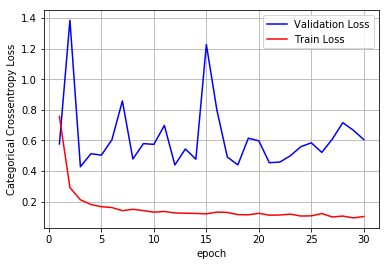

In [42]:
batch_size = 24
# Initiliazing the sequential model
from keras import regularizers
from keras.layers import BatchNormalization
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, input_dim),kernel_initializer='he_normal'))
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(0.7))
model.add(LSTM(64))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

print(confusion_matrix(Y_test, model.predict(X_test)))
score = model.evaluate(X_test, Y_test)
print(score)

#### Test Accuracy with Architecture1 is 90.43% and loss is 0.60

### Archictecture2---2 LSTM layers(64,64), 2 Dropout layers(0.5,0.4),batch_size=24

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 105s 14ms/step - loss: 0.9770

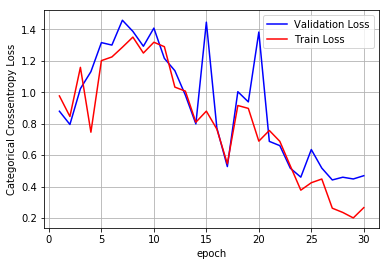

In [43]:
batch_size = 24
# Initiliazing the sequential model
from keras import regularizers
from keras.layers import BatchNormalization
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, input_dim),kernel_initializer='glorot_normal'))
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(64))
# Adding a dropout layer
model.add(Dropout(0.4))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

print(confusion_matrix(Y_test, model.predict(X_test)))
score = model.evaluate(X_test, Y_test)
print(score)

#### Test Accuracy with Architecture2 is 81.60% and loss is 0.46

### Archictecture3---2 LSTM layers(64,48), 2 Dropout layers(0.5,0.5),Batch Normalization,batch_size=24

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 48)                21696     
_________________________________________________________________
dropout_8 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 294       
Total params: 41,190
Trainable params: 41,062
Non-trainable params: 128
_________________________________________________________________
None

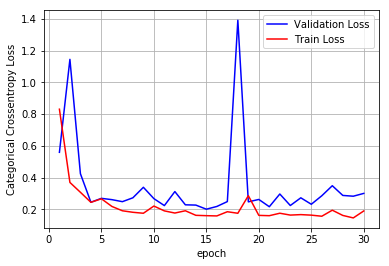

In [44]:
batch_size = 24
from keras.regularizers import L1L2
# Initiliazing the sequential model
from keras import regularizers
from keras.layers import BatchNormalization
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, input_dim),kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(48))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

print(confusion_matrix(Y_test, model.predict(X_test)))
score = model.evaluate(X_test, Y_test)
print(score)

#### Test Accuracy with Architecture3 is 90.09% and loss is 0.30

### Archictecture4---2 LSTM layers(120,100), 2 Dropout layers(0.6,0.5),batch_size=32

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128, 120)          62400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 120)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               88400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 606       
Total params: 151,406
Trainable params: 151,406
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 87s 12ms/step - loss: 1.541

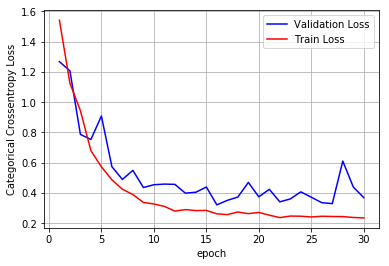

In [46]:
batch_size = 32
# Initiliazing the sequential model
from keras import regularizers
from keras.layers import BatchNormalization
model = Sequential()
# Configuring the parameters
model.add(LSTM(120, return_sequences=True, input_shape=(timesteps, input_dim),kernel_initializer='glorot_normal',kernel_regularizer=L1L2(0.01, 0.01)))
# Adding a dropout layer
model.add(Dropout(0.6))
model.add(LSTM(100))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
print(model.summary())

# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

print(confusion_matrix(Y_test, model.predict(X_test)))
score = model.evaluate(X_test, Y_test)
print(score)

#### Test Accuracy with Architecture4 is 90.90% and loss is 0.36

### Archictecture5---2 LSTM layers(80,40), 2 Dropout layers(0.5,0.32),batch_size=40

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 128, 80)           28800     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 80)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 40)                19360     
_________________________________________________________________
dropout_14 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 246       
Total params: 48,406
Trainable params: 48,406
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 73s 10ms/step - loss: 1.1680 

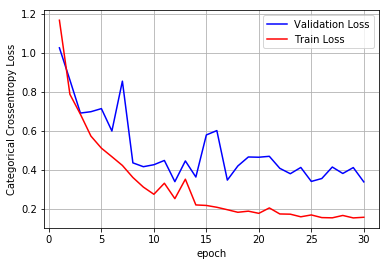

In [47]:
batch_size = 40
# Initiliazing the sequential model
from keras import regularizers
from keras.layers import BatchNormalization
model = Sequential()
# Configuring the parameters
model.add(LSTM(80, return_sequences=True, input_shape=(timesteps, input_dim),kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(40))
# Adding a dropout layer

model.add(Dropout(0.32))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

print(confusion_matrix(Y_test, model.predict(X_test)))
score = model.evaluate(X_test, Y_test)
print(score)

#### Test Accuracy with Architecture5 is 89.41% and loss is 0.33

## Archictecture6---2 LSTM layers(64,64), 2 Dropout layers(0.5,0.4),batch_size=24

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 110s 15ms/step - loss: 0.9677

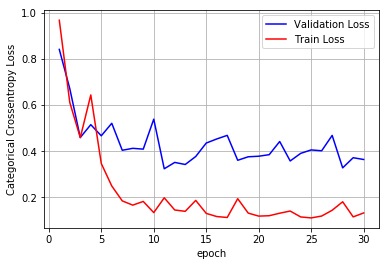

In [48]:
import matplotlib.pyplot as plt
from keras import optimizers
batch_size = 24
# Initiliazing the sequential model
from keras import regularizers
from keras.layers import BatchNormalization
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, input_dim),kernel_initializer='glorot_normal'))
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(64))
# Adding a dropout layer
model.add(Dropout(0.4))
# Adding a dense output layer with sigmoid activation
opt = optimizers.Adam(lr=0.001)
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

print(confusion_matrix(Y_test, model.predict(X_test)))
score = model.evaluate(X_test, Y_test)
print(score)

#### Test Accuracy with Architecture6 is 89.68% and loss is 0.36

### Archictecture7---2 LSTM layers(64,64), 2 Dropout layers(0.5,0.4),batch_size=32

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30


6752/7352 [==========================>...] - ETA: 13:38 - loss: 1.7974 - acc: 0.21 - ETA: 7:20 - loss: 1.7840 - acc: 0.2344 - ETA: 5:15 - loss: 1.7845 - acc: 0.218 - ETA: 4:12 - loss: 1.7859 - acc: 0.218 - ETA: 3:34 - loss: 1.7875 - acc: 0.181 - ETA: 3:08 - loss: 1.7851 - acc: 0.182 - ETA: 2:50 - loss: 1.7868 - acc: 0.169 - ETA: 2:36 - loss: 1.7857 - acc: 0.171 - ETA: 2:31 - loss: 1.7863 - acc: 0.159 - ETA: 2:22 - loss: 1.7855 - acc: 0.165 - ETA: 2:15 - loss: 1.7855 - acc: 0.159 - ETA: 2:09 - loss: 1.7843 - acc: 0.164 - ETA: 2:04 - loss: 1.7829 - acc: 0.168 - ETA: 1:59 - loss: 1.7830 - acc: 0.167 - ETA: 1:56 - loss: 1.7828 - acc: 0.166 - ETA: 1:52 - loss: 1.7810 - acc: 0.175 - ETA: 1:48 - loss: 1.7804 - acc: 0.178 - ETA: 1:45 - loss: 1.7799 - acc: 0.182 - ETA: 1:42 - loss: 1.7798 - acc: 0.187 - ETA: 1:39 - loss: 1.7787 - acc: 0.192 - ETA: 1:37 - loss: 1.7787 - acc: 0.194 - ETA: 1:35 - loss: 1.7774 - acc: 0.200 - ETA: 1:32 - loss: 1.7771 - acc: 0.207 - ETA: 1:31 - loss: 1.7780 - acc: 0.

7352/7352 [==============================] - ETA: 5s - loss: 1.5626 - acc: 0.354 - ETA: 5s - loss: 1.5624 - acc: 0.353 - ETA: 5s - loss: 1.5612 - acc: 0.354 - ETA: 4s - loss: 1.5595 - acc: 0.354 - ETA: 4s - loss: 1.5583 - acc: 0.355 - ETA: 4s - loss: 1.5574 - acc: 0.355 - ETA: 3s - loss: 1.5567 - acc: 0.356 - ETA: 3s - loss: 1.5557 - acc: 0.356 - ETA: 3s - loss: 1.5543 - acc: 0.357 - ETA: 2s - loss: 1.5529 - acc: 0.357 - ETA: 2s - loss: 1.5514 - acc: 0.358 - ETA: 2s - loss: 1.5502 - acc: 0.358 - ETA: 1s - loss: 1.5487 - acc: 0.359 - ETA: 1s - loss: 1.5478 - acc: 0.359 - ETA: 1s - loss: 1.5465 - acc: 0.359 - ETA: 0s - loss: 1.5458 - acc: 0.359 - ETA: 0s - loss: 1.5442 - acc: 0.360 - ETA: 0s - loss: 1.5428 - acc: 0.361 - 82s 11ms/step - loss: 1.5425 - acc: 0.3613 - val_loss: 1.3355 - val_acc: 0.4109
Epoch 2/30


6784/7352 [==========================>...] - ETA: 1:33 - loss: 1.3489 - acc: 0.531 - ETA: 1:24 - loss: 1.3531 - acc: 0.515 - ETA: 1:18 - loss: 1.3028 - acc: 0.510 - ETA: 1:15 - loss: 1.2554 - acc: 0.507 - ETA: 1:13 - loss: 1.2380 - acc: 0.531 - ETA: 1:12 - loss: 1.2632 - acc: 0.520 - ETA: 1:12 - loss: 1.2617 - acc: 0.513 - ETA: 1:11 - loss: 1.2475 - acc: 0.523 - ETA: 1:13 - loss: 1.2546 - acc: 0.510 - ETA: 1:33 - loss: 1.2740 - acc: 0.496 - ETA: 1:36 - loss: 1.2966 - acc: 0.471 - ETA: 1:36 - loss: 1.2979 - acc: 0.474 - ETA: 1:36 - loss: 1.2990 - acc: 0.461 - ETA: 1:33 - loss: 1.3098 - acc: 0.450 - ETA: 1:31 - loss: 1.3129 - acc: 0.443 - ETA: 1:31 - loss: 1.3135 - acc: 0.443 - ETA: 1:30 - loss: 1.3095 - acc: 0.448 - ETA: 1:28 - loss: 1.3145 - acc: 0.442 - ETA: 1:26 - loss: 1.3141 - acc: 0.444 - ETA: 1:25 - loss: 1.3034 - acc: 0.450 - ETA: 1:23 - loss: 1.3076 - acc: 0.447 - ETA: 1:22 - loss: 1.3064 - acc: 0.446 - ETA: 1:21 - loss: 1.3011 - acc: 0.449 - ETA: 1:19 - loss: 1.3065 - acc: 0.4

7352/7352 [==============================] - ETA: 5s - loss: 1.1284 - acc: 0.511 - ETA: 5s - loss: 1.1279 - acc: 0.512 - ETA: 4s - loss: 1.1273 - acc: 0.512 - ETA: 4s - loss: 1.1271 - acc: 0.512 - ETA: 4s - loss: 1.1264 - acc: 0.512 - ETA: 3s - loss: 1.1265 - acc: 0.511 - ETA: 3s - loss: 1.1251 - acc: 0.512 - ETA: 3s - loss: 1.1255 - acc: 0.512 - ETA: 2s - loss: 1.1260 - acc: 0.512 - ETA: 2s - loss: 1.1268 - acc: 0.511 - ETA: 2s - loss: 1.1261 - acc: 0.511 - ETA: 1s - loss: 1.1259 - acc: 0.511 - ETA: 1s - loss: 1.1262 - acc: 0.511 - ETA: 1s - loss: 1.1262 - acc: 0.510 - ETA: 0s - loss: 1.1249 - acc: 0.511 - ETA: 0s - loss: 1.1236 - acc: 0.512 - ETA: 0s - loss: 1.1234 - acc: 0.512 - 84s 11ms/step - loss: 1.1231 - acc: 0.5131 - val_loss: 1.1025 - val_acc: 0.5103
Epoch 3/30


6816/7352 [==========================>...] - ETA: 1:50 - loss: 0.9999 - acc: 0.531 - ETA: 1:34 - loss: 0.9059 - acc: 0.609 - ETA: 1:28 - loss: 0.9417 - acc: 0.562 - ETA: 1:24 - loss: 0.9996 - acc: 0.539 - ETA: 1:23 - loss: 0.9813 - acc: 0.537 - ETA: 1:22 - loss: 0.9609 - acc: 0.552 - ETA: 1:19 - loss: 0.9744 - acc: 0.549 - ETA: 1:19 - loss: 0.9798 - acc: 0.554 - ETA: 1:17 - loss: 0.9849 - acc: 0.548 - ETA: 1:15 - loss: 1.0003 - acc: 0.540 - ETA: 1:14 - loss: 1.0037 - acc: 0.539 - ETA: 1:13 - loss: 1.0080 - acc: 0.528 - ETA: 1:12 - loss: 1.0068 - acc: 0.533 - ETA: 1:11 - loss: 1.0031 - acc: 0.540 - ETA: 1:10 - loss: 0.9987 - acc: 0.541 - ETA: 1:09 - loss: 0.9931 - acc: 0.543 - ETA: 1:08 - loss: 0.9973 - acc: 0.542 - ETA: 1:09 - loss: 1.0075 - acc: 0.538 - ETA: 1:08 - loss: 1.0087 - acc: 0.539 - ETA: 1:08 - loss: 1.0126 - acc: 0.537 - ETA: 1:07 - loss: 1.0055 - acc: 0.543 - ETA: 1:06 - loss: 1.0002 - acc: 0.548 - ETA: 1:06 - loss: 1.0062 - acc: 0.543 - ETA: 1:06 - loss: 0.9985 - acc: 0.5

7352/7352 [==============================] - ETA: 5s - loss: 0.9125 - acc: 0.605 - ETA: 5s - loss: 0.9120 - acc: 0.605 - ETA: 4s - loss: 0.9108 - acc: 0.605 - ETA: 4s - loss: 0.9110 - acc: 0.605 - ETA: 3s - loss: 0.9107 - acc: 0.605 - ETA: 3s - loss: 0.9102 - acc: 0.605 - ETA: 3s - loss: 0.9103 - acc: 0.605 - ETA: 2s - loss: 0.9093 - acc: 0.606 - ETA: 2s - loss: 0.9090 - acc: 0.605 - ETA: 2s - loss: 0.9085 - acc: 0.606 - ETA: 1s - loss: 0.9079 - acc: 0.606 - ETA: 1s - loss: 0.9080 - acc: 0.606 - ETA: 1s - loss: 0.9089 - acc: 0.605 - ETA: 0s - loss: 0.9090 - acc: 0.605 - ETA: 0s - loss: 0.9099 - acc: 0.605 - ETA: 0s - loss: 0.9096 - acc: 0.605 - 85s 12ms/step - loss: 0.9089 - acc: 0.6054 - val_loss: 0.9499 - val_acc: 0.5806
Epoch 4/30


6816/7352 [==========================>...] - ETA: 1:17 - loss: 0.7494 - acc: 0.625 - ETA: 1:10 - loss: 0.7065 - acc: 0.671 - ETA: 1:07 - loss: 0.7573 - acc: 0.666 - ETA: 1:08 - loss: 0.8453 - acc: 0.617 - ETA: 1:09 - loss: 0.8745 - acc: 0.600 - ETA: 1:21 - loss: 0.8694 - acc: 0.593 - ETA: 1:20 - loss: 0.8551 - acc: 0.598 - ETA: 1:21 - loss: 0.8371 - acc: 0.613 - ETA: 1:19 - loss: 0.8385 - acc: 0.628 - ETA: 1:17 - loss: 0.8573 - acc: 0.625 - ETA: 1:15 - loss: 0.8402 - acc: 0.633 - ETA: 1:14 - loss: 0.8347 - acc: 0.638 - ETA: 1:13 - loss: 0.8147 - acc: 0.646 - ETA: 1:12 - loss: 0.8295 - acc: 0.642 - ETA: 1:11 - loss: 0.8174 - acc: 0.654 - ETA: 1:10 - loss: 0.8297 - acc: 0.644 - ETA: 1:09 - loss: 0.8255 - acc: 0.650 - ETA: 1:09 - loss: 0.8208 - acc: 0.652 - ETA: 1:08 - loss: 0.8193 - acc: 0.653 - ETA: 1:07 - loss: 0.8170 - acc: 0.654 - ETA: 1:07 - loss: 0.8105 - acc: 0.656 - ETA: 1:07 - loss: 0.8093 - acc: 0.657 - ETA: 1:07 - loss: 0.8169 - acc: 0.657 - ETA: 1:07 - loss: 0.8138 - acc: 0.6

7352/7352 [==============================] - ETA: 5s - loss: 0.7632 - acc: 0.661 - ETA: 5s - loss: 0.7628 - acc: 0.662 - ETA: 4s - loss: 0.7625 - acc: 0.662 - ETA: 4s - loss: 0.7621 - acc: 0.662 - ETA: 4s - loss: 0.7609 - acc: 0.663 - ETA: 3s - loss: 0.7603 - acc: 0.663 - ETA: 3s - loss: 0.7590 - acc: 0.664 - ETA: 3s - loss: 0.7588 - acc: 0.664 - ETA: 2s - loss: 0.7583 - acc: 0.664 - ETA: 2s - loss: 0.7585 - acc: 0.664 - ETA: 2s - loss: 0.7582 - acc: 0.664 - ETA: 1s - loss: 0.7584 - acc: 0.664 - ETA: 1s - loss: 0.7581 - acc: 0.664 - ETA: 0s - loss: 0.7581 - acc: 0.664 - ETA: 0s - loss: 0.7578 - acc: 0.664 - ETA: 0s - loss: 0.7578 - acc: 0.664 - 88s 12ms/step - loss: 0.7581 - acc: 0.6640 - val_loss: 0.7826 - val_acc: 0.6810
Epoch 5/30


6720/7352 [==========================>...] - ETA: 1:23 - loss: 0.4629 - acc: 0.843 - ETA: 1:11 - loss: 0.5262 - acc: 0.781 - ETA: 1:07 - loss: 0.5636 - acc: 0.760 - ETA: 1:06 - loss: 0.6537 - acc: 0.726 - ETA: 1:05 - loss: 0.6403 - acc: 0.731 - ETA: 1:05 - loss: 0.6265 - acc: 0.739 - ETA: 1:06 - loss: 0.6292 - acc: 0.741 - ETA: 1:05 - loss: 0.6318 - acc: 0.742 - ETA: 1:04 - loss: 0.6062 - acc: 0.746 - ETA: 1:05 - loss: 0.6110 - acc: 0.737 - ETA: 1:04 - loss: 0.6097 - acc: 0.738 - ETA: 1:04 - loss: 0.6156 - acc: 0.729 - ETA: 1:03 - loss: 0.6128 - acc: 0.735 - ETA: 1:03 - loss: 0.6294 - acc: 0.723 - ETA: 1:03 - loss: 0.6347 - acc: 0.712 - ETA: 1:03 - loss: 0.6335 - acc: 0.710 - ETA: 1:05 - loss: 0.6359 - acc: 0.713 - ETA: 1:05 - loss: 0.6405 - acc: 0.706 - ETA: 1:05 - loss: 0.6490 - acc: 0.700 - ETA: 1:04 - loss: 0.6474 - acc: 0.701 - ETA: 1:05 - loss: 0.6476 - acc: 0.699 - ETA: 1:05 - loss: 0.6530 - acc: 0.697 - ETA: 1:04 - loss: 0.6603 - acc: 0.694 - ETA: 1:06 - loss: 0.6642 - acc: 0.6

7352/7352 [==============================] - ETA: 6s - loss: 0.6769 - acc: 0.703 - ETA: 6s - loss: 0.6752 - acc: 0.703 - ETA: 6s - loss: 0.6755 - acc: 0.703 - ETA: 5s - loss: 0.6763 - acc: 0.702 - ETA: 5s - loss: 0.6762 - acc: 0.703 - ETA: 4s - loss: 0.6754 - acc: 0.703 - ETA: 4s - loss: 0.6748 - acc: 0.703 - ETA: 4s - loss: 0.6742 - acc: 0.704 - ETA: 3s - loss: 0.6736 - acc: 0.704 - ETA: 3s - loss: 0.6740 - acc: 0.704 - ETA: 3s - loss: 0.6755 - acc: 0.703 - ETA: 2s - loss: 0.6748 - acc: 0.704 - ETA: 2s - loss: 0.6755 - acc: 0.703 - ETA: 2s - loss: 0.6761 - acc: 0.703 - ETA: 1s - loss: 0.6759 - acc: 0.703 - ETA: 1s - loss: 0.6753 - acc: 0.704 - ETA: 1s - loss: 0.6750 - acc: 0.704 - ETA: 0s - loss: 0.6737 - acc: 0.704 - ETA: 0s - loss: 0.6735 - acc: 0.705 - 94s 13ms/step - loss: 0.6733 - acc: 0.7053 - val_loss: 0.7108 - val_acc: 0.7190
Epoch 6/30


6784/7352 [==========================>...] - ETA: 2:12 - loss: 0.9184 - acc: 0.687 - ETA: 2:20 - loss: 0.8025 - acc: 0.671 - ETA: 2:05 - loss: 0.7564 - acc: 0.666 - ETA: 2:05 - loss: 0.7514 - acc: 0.664 - ETA: 2:02 - loss: 0.7614 - acc: 0.675 - ETA: 2:00 - loss: 0.7809 - acc: 0.666 - ETA: 1:53 - loss: 0.7463 - acc: 0.692 - ETA: 1:49 - loss: 0.7659 - acc: 0.679 - ETA: 1:45 - loss: 0.7676 - acc: 0.680 - ETA: 1:41 - loss: 0.7457 - acc: 0.690 - ETA: 1:38 - loss: 0.7171 - acc: 0.698 - ETA: 1:35 - loss: 0.7003 - acc: 0.708 - ETA: 1:34 - loss: 0.7064 - acc: 0.704 - ETA: 1:32 - loss: 0.7023 - acc: 0.703 - ETA: 1:30 - loss: 0.6975 - acc: 0.702 - ETA: 1:29 - loss: 0.6945 - acc: 0.703 - ETA: 1:30 - loss: 0.6933 - acc: 0.702 - ETA: 1:29 - loss: 0.6845 - acc: 0.703 - ETA: 1:27 - loss: 0.6854 - acc: 0.700 - ETA: 1:26 - loss: 0.6785 - acc: 0.704 - ETA: 1:26 - loss: 0.6771 - acc: 0.703 - ETA: 1:24 - loss: 0.6715 - acc: 0.710 - ETA: 1:23 - loss: 0.6556 - acc: 0.718 - ETA: 1:22 - loss: 0.6588 - acc: 0.7

7352/7352 [==============================] - ETA: 6s - loss: 0.6163 - acc: 0.732 - ETA: 5s - loss: 0.6150 - acc: 0.733 - ETA: 5s - loss: 0.6154 - acc: 0.732 - ETA: 5s - loss: 0.6154 - acc: 0.732 - ETA: 4s - loss: 0.6145 - acc: 0.733 - ETA: 4s - loss: 0.6158 - acc: 0.732 - ETA: 3s - loss: 0.6148 - acc: 0.733 - ETA: 3s - loss: 0.6147 - acc: 0.733 - ETA: 3s - loss: 0.6165 - acc: 0.732 - ETA: 2s - loss: 0.6169 - acc: 0.732 - ETA: 2s - loss: 0.6179 - acc: 0.732 - ETA: 2s - loss: 0.6174 - acc: 0.732 - ETA: 1s - loss: 0.6170 - acc: 0.732 - ETA: 1s - loss: 0.6164 - acc: 0.733 - ETA: 1s - loss: 0.6164 - acc: 0.733 - ETA: 0s - loss: 0.6164 - acc: 0.732 - ETA: 0s - loss: 0.6156 - acc: 0.733 - 95s 13ms/step - loss: 0.6160 - acc: 0.7330 - val_loss: 0.6868 - val_acc: 0.7258
Epoch 7/30


6816/7352 [==========================>...] - ETA: 1:18 - loss: 0.6741 - acc: 0.687 - ETA: 1:13 - loss: 0.6154 - acc: 0.703 - ETA: 1:19 - loss: 0.6025 - acc: 0.718 - ETA: 1:18 - loss: 0.6320 - acc: 0.718 - ETA: 1:16 - loss: 0.5993 - acc: 0.731 - ETA: 1:17 - loss: 0.5758 - acc: 0.760 - ETA: 1:16 - loss: 0.5637 - acc: 0.767 - ETA: 1:16 - loss: 0.5434 - acc: 0.781 - ETA: 1:14 - loss: 0.5655 - acc: 0.770 - ETA: 1:14 - loss: 0.5760 - acc: 0.765 - ETA: 1:13 - loss: 0.5866 - acc: 0.764 - ETA: 1:15 - loss: 0.5923 - acc: 0.750 - ETA: 1:14 - loss: 0.6100 - acc: 0.745 - ETA: 1:13 - loss: 0.6080 - acc: 0.747 - ETA: 1:12 - loss: 0.6025 - acc: 0.752 - ETA: 1:11 - loss: 0.5981 - acc: 0.755 - ETA: 1:09 - loss: 0.5915 - acc: 0.759 - ETA: 1:08 - loss: 0.5897 - acc: 0.760 - ETA: 1:08 - loss: 0.5826 - acc: 0.766 - ETA: 1:07 - loss: 0.5761 - acc: 0.770 - ETA: 1:06 - loss: 0.5740 - acc: 0.772 - ETA: 1:06 - loss: 0.5682 - acc: 0.772 - ETA: 1:06 - loss: 0.5737 - acc: 0.770 - ETA: 1:05 - loss: 0.5809 - acc: 0.7

7352/7352 [==============================] - ETA: 5s - loss: 0.5623 - acc: 0.764 - ETA: 5s - loss: 0.5629 - acc: 0.764 - ETA: 5s - loss: 0.5626 - acc: 0.764 - ETA: 4s - loss: 0.5621 - acc: 0.765 - ETA: 4s - loss: 0.5616 - acc: 0.765 - ETA: 3s - loss: 0.5618 - acc: 0.765 - ETA: 3s - loss: 0.5612 - acc: 0.766 - ETA: 3s - loss: 0.5619 - acc: 0.766 - ETA: 2s - loss: 0.5616 - acc: 0.766 - ETA: 2s - loss: 0.5611 - acc: 0.766 - ETA: 2s - loss: 0.5620 - acc: 0.766 - ETA: 1s - loss: 0.5612 - acc: 0.766 - ETA: 1s - loss: 0.5612 - acc: 0.766 - ETA: 1s - loss: 0.5607 - acc: 0.766 - ETA: 0s - loss: 0.5606 - acc: 0.766 - ETA: 0s - loss: 0.5604 - acc: 0.766 - 92s 13ms/step - loss: 0.5599 - acc: 0.7663 - val_loss: 0.6380 - val_acc: 0.7503
Epoch 8/30


6752/7352 [==========================>...] - ETA: 1:45 - loss: 0.5231 - acc: 0.750 - ETA: 1:37 - loss: 0.4902 - acc: 0.718 - ETA: 1:35 - loss: 0.4926 - acc: 0.760 - ETA: 1:32 - loss: 0.4967 - acc: 0.773 - ETA: 1:30 - loss: 0.5147 - acc: 0.762 - ETA: 1:31 - loss: 0.4971 - acc: 0.786 - ETA: 1:32 - loss: 0.5054 - acc: 0.785 - ETA: 1:35 - loss: 0.5164 - acc: 0.777 - ETA: 1:34 - loss: 0.5153 - acc: 0.777 - ETA: 1:33 - loss: 0.5110 - acc: 0.781 - ETA: 1:32 - loss: 0.5243 - acc: 0.772 - ETA: 1:31 - loss: 0.5147 - acc: 0.781 - ETA: 1:29 - loss: 0.5199 - acc: 0.774 - ETA: 1:28 - loss: 0.5289 - acc: 0.770 - ETA: 1:27 - loss: 0.5137 - acc: 0.781 - ETA: 1:27 - loss: 0.5164 - acc: 0.783 - ETA: 1:26 - loss: 0.5239 - acc: 0.783 - ETA: 1:25 - loss: 0.5305 - acc: 0.781 - ETA: 1:25 - loss: 0.5389 - acc: 0.779 - ETA: 1:24 - loss: 0.5384 - acc: 0.781 - ETA: 1:26 - loss: 0.5431 - acc: 0.775 - ETA: 1:25 - loss: 0.5343 - acc: 0.781 - ETA: 1:24 - loss: 0.5301 - acc: 0.779 - ETA: 1:24 - loss: 0.5261 - acc: 0.7

7352/7352 [==============================] - ETA: 7s - loss: 0.5286 - acc: 0.781 - ETA: 7s - loss: 0.5283 - acc: 0.782 - ETA: 6s - loss: 0.5284 - acc: 0.781 - ETA: 6s - loss: 0.5278 - acc: 0.781 - ETA: 6s - loss: 0.5277 - acc: 0.782 - ETA: 5s - loss: 0.5274 - acc: 0.782 - ETA: 5s - loss: 0.5276 - acc: 0.782 - ETA: 4s - loss: 0.5272 - acc: 0.782 - ETA: 4s - loss: 0.5264 - acc: 0.783 - ETA: 3s - loss: 0.5266 - acc: 0.782 - ETA: 3s - loss: 0.5261 - acc: 0.783 - ETA: 2s - loss: 0.5252 - acc: 0.783 - ETA: 2s - loss: 0.5258 - acc: 0.783 - ETA: 2s - loss: 0.5258 - acc: 0.783 - ETA: 1s - loss: 0.5254 - acc: 0.783 - ETA: 1s - loss: 0.5255 - acc: 0.783 - ETA: 0s - loss: 0.5258 - acc: 0.783 - ETA: 0s - loss: 0.5250 - acc: 0.783 - 111s 15ms/step - loss: 0.5248 - acc: 0.7835 - val_loss: 0.6135 - val_acc: 0.7648
Epoch 9/30


6720/7352 [==========================>...] - ETA: 1:38 - loss: 0.7174 - acc: 0.750 - ETA: 1:36 - loss: 0.5965 - acc: 0.765 - ETA: 2:17 - loss: 0.5104 - acc: 0.791 - ETA: 2:57 - loss: 0.5256 - acc: 0.781 - ETA: 2:49 - loss: 0.5213 - acc: 0.781 - ETA: 2:41 - loss: 0.5231 - acc: 0.781 - ETA: 2:31 - loss: 0.5231 - acc: 0.781 - ETA: 2:28 - loss: 0.5116 - acc: 0.785 - ETA: 2:22 - loss: 0.5077 - acc: 0.781 - ETA: 2:15 - loss: 0.5090 - acc: 0.781 - ETA: 2:10 - loss: 0.5026 - acc: 0.784 - ETA: 2:07 - loss: 0.5212 - acc: 0.768 - ETA: 2:03 - loss: 0.5270 - acc: 0.766 - ETA: 2:00 - loss: 0.5236 - acc: 0.770 - ETA: 1:57 - loss: 0.5268 - acc: 0.772 - ETA: 1:55 - loss: 0.5154 - acc: 0.779 - ETA: 1:52 - loss: 0.5081 - acc: 0.784 - ETA: 1:50 - loss: 0.4993 - acc: 0.786 - ETA: 1:48 - loss: 0.4941 - acc: 0.791 - ETA: 1:46 - loss: 0.5086 - acc: 0.781 - ETA: 1:44 - loss: 0.5059 - acc: 0.781 - ETA: 1:42 - loss: 0.4964 - acc: 0.785 - ETA: 1:40 - loss: 0.4989 - acc: 0.782 - ETA: 1:39 - loss: 0.4942 - acc: 0.7

7352/7352 [==============================] - ETA: 8s - loss: 0.4845 - acc: 0.796 - ETA: 7s - loss: 0.4851 - acc: 0.796 - ETA: 7s - loss: 0.4846 - acc: 0.796 - ETA: 6s - loss: 0.4841 - acc: 0.797 - ETA: 6s - loss: 0.4836 - acc: 0.797 - ETA: 6s - loss: 0.4843 - acc: 0.797 - ETA: 5s - loss: 0.4844 - acc: 0.796 - ETA: 5s - loss: 0.4841 - acc: 0.797 - ETA: 4s - loss: 0.4849 - acc: 0.796 - ETA: 4s - loss: 0.4860 - acc: 0.796 - ETA: 3s - loss: 0.4856 - acc: 0.796 - ETA: 3s - loss: 0.4853 - acc: 0.796 - ETA: 2s - loss: 0.4849 - acc: 0.796 - ETA: 2s - loss: 0.4856 - acc: 0.796 - ETA: 2s - loss: 0.4855 - acc: 0.796 - ETA: 1s - loss: 0.4845 - acc: 0.797 - ETA: 1s - loss: 0.4844 - acc: 0.797 - ETA: 0s - loss: 0.4848 - acc: 0.797 - ETA: 0s - loss: 0.4846 - acc: 0.797 - 107s 15ms/step - loss: 0.4843 - acc: 0.7980 - val_loss: 0.6140 - val_acc: 0.7645
Epoch 10/30


6752/7352 [==========================>...] - ETA: 1:25 - loss: 0.4691 - acc: 0.812 - ETA: 1:24 - loss: 0.4303 - acc: 0.843 - ETA: 1:25 - loss: 0.4547 - acc: 0.854 - ETA: 1:32 - loss: 0.5069 - acc: 0.828 - ETA: 1:33 - loss: 0.4896 - acc: 0.812 - ETA: 1:31 - loss: 0.5049 - acc: 0.786 - ETA: 1:29 - loss: 0.4877 - acc: 0.790 - ETA: 1:29 - loss: 0.4781 - acc: 0.793 - ETA: 1:28 - loss: 0.4912 - acc: 0.795 - ETA: 1:27 - loss: 0.5145 - acc: 0.790 - ETA: 1:26 - loss: 0.4974 - acc: 0.795 - ETA: 1:25 - loss: 0.4841 - acc: 0.804 - ETA: 1:24 - loss: 0.4736 - acc: 0.814 - ETA: 1:24 - loss: 0.4779 - acc: 0.814 - ETA: 1:23 - loss: 0.4985 - acc: 0.808 - ETA: 1:23 - loss: 0.4935 - acc: 0.810 - ETA: 1:25 - loss: 0.4948 - acc: 0.812 - ETA: 1:25 - loss: 0.4990 - acc: 0.812 - ETA: 1:24 - loss: 0.5038 - acc: 0.809 - ETA: 1:24 - loss: 0.5112 - acc: 0.807 - ETA: 1:23 - loss: 0.5117 - acc: 0.808 - ETA: 1:22 - loss: 0.5085 - acc: 0.812 - ETA: 1:21 - loss: 0.5050 - acc: 0.809 - ETA: 1:20 - loss: 0.4982 - acc: 0.8

7352/7352 [==============================] - ETA: 6s - loss: 0.4527 - acc: 0.812 - ETA: 6s - loss: 0.4532 - acc: 0.812 - ETA: 6s - loss: 0.4529 - acc: 0.812 - ETA: 5s - loss: 0.4525 - acc: 0.812 - ETA: 5s - loss: 0.4519 - acc: 0.813 - ETA: 4s - loss: 0.4517 - acc: 0.813 - ETA: 4s - loss: 0.4520 - acc: 0.813 - ETA: 4s - loss: 0.4523 - acc: 0.812 - ETA: 3s - loss: 0.4526 - acc: 0.811 - ETA: 3s - loss: 0.4523 - acc: 0.812 - ETA: 3s - loss: 0.4529 - acc: 0.811 - ETA: 2s - loss: 0.4532 - acc: 0.811 - ETA: 2s - loss: 0.4532 - acc: 0.811 - ETA: 1s - loss: 0.4532 - acc: 0.811 - ETA: 1s - loss: 0.4541 - acc: 0.811 - ETA: 1s - loss: 0.4543 - acc: 0.811 - ETA: 0s - loss: 0.4540 - acc: 0.811 - ETA: 0s - loss: 0.4540 - acc: 0.811 - 97s 13ms/step - loss: 0.4534 - acc: 0.8118 - val_loss: 0.5875 - val_acc: 0.7625
Epoch 11/30


6752/7352 [==========================>...] - ETA: 2:10 - loss: 0.4619 - acc: 0.781 - ETA: 1:46 - loss: 0.4137 - acc: 0.812 - ETA: 1:38 - loss: 0.4216 - acc: 0.802 - ETA: 1:34 - loss: 0.4493 - acc: 0.773 - ETA: 1:31 - loss: 0.4644 - acc: 0.781 - ETA: 1:29 - loss: 0.4371 - acc: 0.796 - ETA: 1:27 - loss: 0.4279 - acc: 0.803 - ETA: 1:26 - loss: 0.4302 - acc: 0.812 - ETA: 1:26 - loss: 0.4325 - acc: 0.816 - ETA: 1:25 - loss: 0.4120 - acc: 0.821 - ETA: 1:24 - loss: 0.4005 - acc: 0.832 - ETA: 1:23 - loss: 0.3927 - acc: 0.835 - ETA: 1:22 - loss: 0.3878 - acc: 0.836 - ETA: 1:22 - loss: 0.3876 - acc: 0.834 - ETA: 1:24 - loss: 0.3876 - acc: 0.835 - ETA: 1:24 - loss: 0.3823 - acc: 0.841 - ETA: 1:23 - loss: 0.3733 - acc: 0.849 - ETA: 1:22 - loss: 0.3719 - acc: 0.849 - ETA: 1:21 - loss: 0.3797 - acc: 0.842 - ETA: 1:20 - loss: 0.3826 - acc: 0.839 - ETA: 1:20 - loss: 0.3797 - acc: 0.840 - ETA: 1:20 - loss: 0.3884 - acc: 0.839 - ETA: 1:20 - loss: 0.3869 - acc: 0.841 - ETA: 1:19 - loss: 0.3936 - acc: 0.8

7352/7352 [==============================] - ETA: 7s - loss: 0.4135 - acc: 0.829 - ETA: 7s - loss: 0.4137 - acc: 0.829 - ETA: 6s - loss: 0.4136 - acc: 0.829 - ETA: 6s - loss: 0.4136 - acc: 0.829 - ETA: 5s - loss: 0.4131 - acc: 0.829 - ETA: 5s - loss: 0.4126 - acc: 0.829 - ETA: 5s - loss: 0.4134 - acc: 0.829 - ETA: 4s - loss: 0.4139 - acc: 0.829 - ETA: 4s - loss: 0.4141 - acc: 0.829 - ETA: 3s - loss: 0.4141 - acc: 0.828 - ETA: 3s - loss: 0.4138 - acc: 0.829 - ETA: 2s - loss: 0.4138 - acc: 0.829 - ETA: 2s - loss: 0.4142 - acc: 0.829 - ETA: 2s - loss: 0.4139 - acc: 0.829 - ETA: 1s - loss: 0.4147 - acc: 0.828 - ETA: 1s - loss: 0.4144 - acc: 0.828 - ETA: 0s - loss: 0.4148 - acc: 0.828 - ETA: 0s - loss: 0.4144 - acc: 0.829 - 106s 14ms/step - loss: 0.4151 - acc: 0.8286 - val_loss: 0.5538 - val_acc: 0.7862
Epoch 12/30


6752/7352 [==========================>...] - ETA: 1:23 - loss: 0.4441 - acc: 0.781 - ETA: 1:23 - loss: 0.3830 - acc: 0.781 - ETA: 1:22 - loss: 0.3745 - acc: 0.812 - ETA: 1:23 - loss: 0.3925 - acc: 0.820 - ETA: 1:32 - loss: 0.3858 - acc: 0.818 - ETA: 1:30 - loss: 0.4194 - acc: 0.822 - ETA: 1:28 - loss: 0.4576 - acc: 0.825 - ETA: 1:27 - loss: 0.4487 - acc: 0.832 - ETA: 1:25 - loss: 0.4404 - acc: 0.833 - ETA: 1:25 - loss: 0.4512 - acc: 0.825 - ETA: 1:24 - loss: 0.4530 - acc: 0.826 - ETA: 1:23 - loss: 0.4505 - acc: 0.820 - ETA: 1:22 - loss: 0.4467 - acc: 0.817 - ETA: 1:22 - loss: 0.4511 - acc: 0.812 - ETA: 1:21 - loss: 0.4472 - acc: 0.812 - ETA: 1:20 - loss: 0.4429 - acc: 0.812 - ETA: 1:20 - loss: 0.4382 - acc: 0.816 - ETA: 1:20 - loss: 0.4369 - acc: 0.817 - ETA: 1:22 - loss: 0.4302 - acc: 0.822 - ETA: 1:22 - loss: 0.4241 - acc: 0.825 - ETA: 1:21 - loss: 0.4220 - acc: 0.830 - ETA: 1:21 - loss: 0.4185 - acc: 0.831 - ETA: 1:20 - loss: 0.4128 - acc: 0.831 - ETA: 1:19 - loss: 0.4103 - acc: 0.8

7352/7352 [==============================] - ETA: 7s - loss: 0.4013 - acc: 0.848 - ETA: 6s - loss: 0.4012 - acc: 0.848 - ETA: 6s - loss: 0.4025 - acc: 0.848 - ETA: 5s - loss: 0.4041 - acc: 0.847 - ETA: 5s - loss: 0.4050 - acc: 0.846 - ETA: 5s - loss: 0.4047 - acc: 0.846 - ETA: 4s - loss: 0.4053 - acc: 0.846 - ETA: 4s - loss: 0.4054 - acc: 0.846 - ETA: 3s - loss: 0.4050 - acc: 0.847 - ETA: 3s - loss: 0.4048 - acc: 0.847 - ETA: 3s - loss: 0.4051 - acc: 0.846 - ETA: 2s - loss: 0.4051 - acc: 0.846 - ETA: 2s - loss: 0.4059 - acc: 0.846 - ETA: 1s - loss: 0.4056 - acc: 0.846 - ETA: 1s - loss: 0.4053 - acc: 0.846 - ETA: 1s - loss: 0.4048 - acc: 0.846 - ETA: 0s - loss: 0.4045 - acc: 0.847 - ETA: 0s - loss: 0.4049 - acc: 0.847 - 99s 13ms/step - loss: 0.4047 - acc: 0.8474 - val_loss: 0.5956 - val_acc: 0.7825
Epoch 13/30


6752/7352 [==========================>...] - ETA: 1:24 - loss: 0.4840 - acc: 0.812 - ETA: 1:24 - loss: 0.4550 - acc: 0.812 - ETA: 1:25 - loss: 0.4116 - acc: 0.833 - ETA: 1:24 - loss: 0.4333 - acc: 0.835 - ETA: 1:24 - loss: 0.4155 - acc: 0.843 - ETA: 1:23 - loss: 0.3871 - acc: 0.859 - ETA: 1:23 - loss: 0.3810 - acc: 0.866 - ETA: 1:22 - loss: 0.4000 - acc: 0.859 - ETA: 1:21 - loss: 0.4183 - acc: 0.854 - ETA: 1:22 - loss: 0.4070 - acc: 0.856 - ETA: 1:22 - loss: 0.3935 - acc: 0.858 - ETA: 1:24 - loss: 0.3969 - acc: 0.854 - ETA: 1:23 - loss: 0.3898 - acc: 0.858 - ETA: 1:23 - loss: 0.3819 - acc: 0.861 - ETA: 1:22 - loss: 0.3688 - acc: 0.870 - ETA: 1:21 - loss: 0.3615 - acc: 0.873 - ETA: 1:21 - loss: 0.3632 - acc: 0.873 - ETA: 1:21 - loss: 0.3753 - acc: 0.866 - ETA: 1:20 - loss: 0.3714 - acc: 0.866 - ETA: 1:20 - loss: 0.3763 - acc: 0.864 - ETA: 1:19 - loss: 0.3743 - acc: 0.864 - ETA: 1:19 - loss: 0.3710 - acc: 0.865 - ETA: 1:18 - loss: 0.3697 - acc: 0.866 - ETA: 1:18 - loss: 0.3698 - acc: 0.8

7352/7352 [==============================] - ETA: 6s - loss: 0.3597 - acc: 0.875 - ETA: 6s - loss: 0.3595 - acc: 0.875 - ETA: 6s - loss: 0.3591 - acc: 0.875 - ETA: 5s - loss: 0.3594 - acc: 0.875 - ETA: 5s - loss: 0.3591 - acc: 0.875 - ETA: 4s - loss: 0.3597 - acc: 0.875 - ETA: 4s - loss: 0.3593 - acc: 0.875 - ETA: 4s - loss: 0.3591 - acc: 0.875 - ETA: 3s - loss: 0.3600 - acc: 0.875 - ETA: 3s - loss: 0.3601 - acc: 0.875 - ETA: 3s - loss: 0.3599 - acc: 0.875 - ETA: 2s - loss: 0.3599 - acc: 0.875 - ETA: 2s - loss: 0.3602 - acc: 0.875 - ETA: 1s - loss: 0.3595 - acc: 0.875 - ETA: 1s - loss: 0.3600 - acc: 0.874 - ETA: 1s - loss: 0.3602 - acc: 0.874 - ETA: 0s - loss: 0.3605 - acc: 0.874 - ETA: 0s - loss: 0.3599 - acc: 0.874 - 97s 13ms/step - loss: 0.3598 - acc: 0.8747 - val_loss: 0.4913 - val_acc: 0.8137
Epoch 14/30


6784/7352 [==========================>...] - ETA: 1:22 - loss: 0.1701 - acc: 1.000 - ETA: 1:18 - loss: 0.2650 - acc: 0.968 - ETA: 1:17 - loss: 0.4170 - acc: 0.906 - ETA: 1:21 - loss: 0.4492 - acc: 0.882 - ETA: 1:22 - loss: 0.4273 - acc: 0.868 - ETA: 1:21 - loss: 0.4465 - acc: 0.859 - ETA: 1:21 - loss: 0.4462 - acc: 0.861 - ETA: 1:21 - loss: 0.4502 - acc: 0.851 - ETA: 1:20 - loss: 0.4509 - acc: 0.840 - ETA: 1:24 - loss: 0.4416 - acc: 0.846 - ETA: 1:23 - loss: 0.4337 - acc: 0.852 - ETA: 1:22 - loss: 0.4234 - acc: 0.854 - ETA: 1:21 - loss: 0.4142 - acc: 0.863 - ETA: 1:20 - loss: 0.4190 - acc: 0.863 - ETA: 1:19 - loss: 0.4090 - acc: 0.868 - ETA: 1:19 - loss: 0.4006 - acc: 0.873 - ETA: 1:18 - loss: 0.3940 - acc: 0.875 - ETA: 1:17 - loss: 0.4027 - acc: 0.871 - ETA: 1:17 - loss: 0.3974 - acc: 0.871 - ETA: 1:17 - loss: 0.3962 - acc: 0.873 - ETA: 1:17 - loss: 0.3960 - acc: 0.875 - ETA: 1:16 - loss: 0.3858 - acc: 0.877 - ETA: 1:15 - loss: 0.3796 - acc: 0.880 - ETA: 1:15 - loss: 0.3809 - acc: 0.8

7352/7352 [==============================] - ETA: 5s - loss: 0.3274 - acc: 0.891 - ETA: 5s - loss: 0.3272 - acc: 0.891 - ETA: 5s - loss: 0.3271 - acc: 0.891 - ETA: 4s - loss: 0.3264 - acc: 0.891 - ETA: 4s - loss: 0.3260 - acc: 0.892 - ETA: 4s - loss: 0.3261 - acc: 0.892 - ETA: 3s - loss: 0.3253 - acc: 0.892 - ETA: 3s - loss: 0.3253 - acc: 0.892 - ETA: 3s - loss: 0.3247 - acc: 0.893 - ETA: 2s - loss: 0.3249 - acc: 0.892 - ETA: 2s - loss: 0.3246 - acc: 0.892 - ETA: 2s - loss: 0.3248 - acc: 0.892 - ETA: 1s - loss: 0.3245 - acc: 0.892 - ETA: 1s - loss: 0.3242 - acc: 0.893 - ETA: 0s - loss: 0.3239 - acc: 0.893 - ETA: 0s - loss: 0.3238 - acc: 0.893 - ETA: 0s - loss: 0.3238 - acc: 0.893 - 88s 12ms/step - loss: 0.3238 - acc: 0.8936 - val_loss: 0.5201 - val_acc: 0.8144
Epoch 15/30


6816/7352 [==========================>...] - ETA: 1:09 - loss: 0.4090 - acc: 0.843 - ETA: 1:30 - loss: 0.3779 - acc: 0.843 - ETA: 1:25 - loss: 0.3391 - acc: 0.885 - ETA: 1:20 - loss: 0.3483 - acc: 0.875 - ETA: 1:18 - loss: 0.3377 - acc: 0.881 - ETA: 1:15 - loss: 0.3233 - acc: 0.885 - ETA: 1:12 - loss: 0.3134 - acc: 0.892 - ETA: 1:11 - loss: 0.3099 - acc: 0.894 - ETA: 1:10 - loss: 0.3094 - acc: 0.895 - ETA: 1:09 - loss: 0.3020 - acc: 0.903 - ETA: 1:08 - loss: 0.2989 - acc: 0.906 - ETA: 1:07 - loss: 0.3003 - acc: 0.903 - ETA: 1:06 - loss: 0.3007 - acc: 0.896 - ETA: 1:06 - loss: 0.2924 - acc: 0.899 - ETA: 1:05 - loss: 0.3060 - acc: 0.891 - ETA: 1:05 - loss: 0.3039 - acc: 0.892 - ETA: 1:05 - loss: 0.3032 - acc: 0.893 - ETA: 1:04 - loss: 0.3018 - acc: 0.895 - ETA: 1:03 - loss: 0.2994 - acc: 0.898 - ETA: 1:06 - loss: 0.2968 - acc: 0.900 - ETA: 1:05 - loss: 0.2944 - acc: 0.901 - ETA: 1:05 - loss: 0.2913 - acc: 0.903 - ETA: 1:04 - loss: 0.2894 - acc: 0.904 - ETA: 1:03 - loss: 0.2825 - acc: 0.9

7352/7352 [==============================] - ETA: 4s - loss: 0.2915 - acc: 0.901 - ETA: 4s - loss: 0.2916 - acc: 0.901 - ETA: 4s - loss: 0.2919 - acc: 0.901 - ETA: 4s - loss: 0.2914 - acc: 0.901 - ETA: 3s - loss: 0.2920 - acc: 0.900 - ETA: 3s - loss: 0.2921 - acc: 0.901 - ETA: 3s - loss: 0.2920 - acc: 0.901 - ETA: 2s - loss: 0.2917 - acc: 0.901 - ETA: 2s - loss: 0.2916 - acc: 0.901 - ETA: 2s - loss: 0.2914 - acc: 0.901 - ETA: 1s - loss: 0.2914 - acc: 0.901 - ETA: 1s - loss: 0.2909 - acc: 0.901 - ETA: 1s - loss: 0.2909 - acc: 0.901 - ETA: 0s - loss: 0.2905 - acc: 0.901 - ETA: 0s - loss: 0.2906 - acc: 0.901 - ETA: 0s - loss: 0.2906 - acc: 0.901 - 80s 11ms/step - loss: 0.2907 - acc: 0.9013 - val_loss: 0.5279 - val_acc: 0.8205
Epoch 16/30


6816/7352 [==========================>...] - ETA: 1:06 - loss: 0.2529 - acc: 0.906 - ETA: 1:05 - loss: 0.3038 - acc: 0.890 - ETA: 1:16 - loss: 0.3309 - acc: 0.864 - ETA: 1:17 - loss: 0.2933 - acc: 0.898 - ETA: 1:15 - loss: 0.3033 - acc: 0.887 - ETA: 1:14 - loss: 0.2908 - acc: 0.890 - ETA: 1:12 - loss: 0.2782 - acc: 0.892 - ETA: 1:11 - loss: 0.2644 - acc: 0.898 - ETA: 1:10 - loss: 0.2609 - acc: 0.902 - ETA: 1:09 - loss: 0.2673 - acc: 0.896 - ETA: 1:08 - loss: 0.2610 - acc: 0.900 - ETA: 1:07 - loss: 0.2605 - acc: 0.903 - ETA: 1:06 - loss: 0.2661 - acc: 0.901 - ETA: 1:06 - loss: 0.2616 - acc: 0.904 - ETA: 1:06 - loss: 0.2551 - acc: 0.908 - ETA: 1:06 - loss: 0.2506 - acc: 0.908 - ETA: 1:05 - loss: 0.2479 - acc: 0.913 - ETA: 1:05 - loss: 0.2481 - acc: 0.913 - ETA: 1:04 - loss: 0.2498 - acc: 0.914 - ETA: 1:04 - loss: 0.2458 - acc: 0.917 - ETA: 1:05 - loss: 0.2553 - acc: 0.913 - ETA: 1:05 - loss: 0.2611 - acc: 0.909 - ETA: 1:04 - loss: 0.2615 - acc: 0.909 - ETA: 1:04 - loss: 0.2567 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.2843 - acc: 0.900 - ETA: 4s - loss: 0.2842 - acc: 0.900 - ETA: 4s - loss: 0.2842 - acc: 0.900 - ETA: 4s - loss: 0.2833 - acc: 0.901 - ETA: 4s - loss: 0.2832 - acc: 0.901 - ETA: 3s - loss: 0.2835 - acc: 0.901 - ETA: 3s - loss: 0.2827 - acc: 0.901 - ETA: 3s - loss: 0.2831 - acc: 0.901 - ETA: 2s - loss: 0.2827 - acc: 0.901 - ETA: 2s - loss: 0.2824 - acc: 0.901 - ETA: 2s - loss: 0.2820 - acc: 0.901 - ETA: 1s - loss: 0.2819 - acc: 0.902 - ETA: 1s - loss: 0.2821 - acc: 0.902 - ETA: 0s - loss: 0.2815 - acc: 0.902 - ETA: 0s - loss: 0.2807 - acc: 0.902 - ETA: 0s - loss: 0.2802 - acc: 0.903 - 90s 12ms/step - loss: 0.2799 - acc: 0.9032 - val_loss: 0.4695 - val_acc: 0.8351
Epoch 17/30


6784/7352 [==========================>...] - ETA: 1:43 - loss: 0.1781 - acc: 0.937 - ETA: 1:39 - loss: 0.1763 - acc: 0.953 - ETA: 1:34 - loss: 0.1892 - acc: 0.937 - ETA: 1:30 - loss: 0.2095 - acc: 0.937 - ETA: 1:29 - loss: 0.2058 - acc: 0.937 - ETA: 1:37 - loss: 0.2089 - acc: 0.937 - ETA: 1:33 - loss: 0.2136 - acc: 0.933 - ETA: 1:30 - loss: 0.2094 - acc: 0.937 - ETA: 1:27 - loss: 0.2135 - acc: 0.937 - ETA: 1:24 - loss: 0.2116 - acc: 0.937 - ETA: 1:23 - loss: 0.2146 - acc: 0.934 - ETA: 1:23 - loss: 0.2220 - acc: 0.932 - ETA: 1:22 - loss: 0.2243 - acc: 0.935 - ETA: 1:21 - loss: 0.2222 - acc: 0.935 - ETA: 1:20 - loss: 0.2182 - acc: 0.937 - ETA: 1:20 - loss: 0.2198 - acc: 0.933 - ETA: 1:19 - loss: 0.2152 - acc: 0.935 - ETA: 1:17 - loss: 0.2164 - acc: 0.935 - ETA: 1:17 - loss: 0.2142 - acc: 0.937 - ETA: 1:15 - loss: 0.2125 - acc: 0.937 - ETA: 1:17 - loss: 0.2169 - acc: 0.933 - ETA: 1:17 - loss: 0.2271 - acc: 0.930 - ETA: 1:16 - loss: 0.2245 - acc: 0.932 - ETA: 1:15 - loss: 0.2260 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.2390 - acc: 0.921 - ETA: 4s - loss: 0.2388 - acc: 0.921 - ETA: 4s - loss: 0.2397 - acc: 0.921 - ETA: 4s - loss: 0.2392 - acc: 0.921 - ETA: 3s - loss: 0.2389 - acc: 0.921 - ETA: 3s - loss: 0.2385 - acc: 0.921 - ETA: 3s - loss: 0.2377 - acc: 0.921 - ETA: 3s - loss: 0.2374 - acc: 0.922 - ETA: 2s - loss: 0.2377 - acc: 0.921 - ETA: 2s - loss: 0.2371 - acc: 0.922 - ETA: 2s - loss: 0.2380 - acc: 0.921 - ETA: 1s - loss: 0.2389 - acc: 0.921 - ETA: 1s - loss: 0.2384 - acc: 0.921 - ETA: 1s - loss: 0.2376 - acc: 0.921 - ETA: 0s - loss: 0.2374 - acc: 0.922 - ETA: 0s - loss: 0.2380 - acc: 0.921 - ETA: 0s - loss: 0.2383 - acc: 0.921 - 79s 11ms/step - loss: 0.2383 - acc: 0.9217 - val_loss: 0.4434 - val_acc: 0.8514
Epoch 18/30


6784/7352 [==========================>...] - ETA: 1:03 - loss: 0.1357 - acc: 0.968 - ETA: 1:03 - loss: 0.2045 - acc: 0.937 - ETA: 1:02 - loss: 0.1983 - acc: 0.927 - ETA: 1:03 - loss: 0.2046 - acc: 0.921 - ETA: 1:03 - loss: 0.2020 - acc: 0.925 - ETA: 1:03 - loss: 0.1909 - acc: 0.932 - ETA: 1:02 - loss: 0.2339 - acc: 0.915 - ETA: 1:02 - loss: 0.2195 - acc: 0.925 - ETA: 1:02 - loss: 0.2357 - acc: 0.923 - ETA: 1:03 - loss: 0.2366 - acc: 0.921 - ETA: 1:04 - loss: 0.2306 - acc: 0.926 - ETA: 1:08 - loss: 0.2406 - acc: 0.921 - ETA: 1:11 - loss: 0.2572 - acc: 0.913 - ETA: 1:11 - loss: 0.2450 - acc: 0.919 - ETA: 1:10 - loss: 0.2429 - acc: 0.920 - ETA: 1:10 - loss: 0.2412 - acc: 0.919 - ETA: 1:09 - loss: 0.2467 - acc: 0.919 - ETA: 1:08 - loss: 0.2447 - acc: 0.918 - ETA: 1:08 - loss: 0.2529 - acc: 0.916 - ETA: 1:08 - loss: 0.2593 - acc: 0.915 - ETA: 1:07 - loss: 0.2557 - acc: 0.916 - ETA: 1:07 - loss: 0.2587 - acc: 0.914 - ETA: 1:06 - loss: 0.2600 - acc: 0.913 - ETA: 1:06 - loss: 0.2623 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.2430 - acc: 0.916 - ETA: 5s - loss: 0.2424 - acc: 0.917 - ETA: 4s - loss: 0.2420 - acc: 0.917 - ETA: 4s - loss: 0.2428 - acc: 0.917 - ETA: 4s - loss: 0.2430 - acc: 0.917 - ETA: 3s - loss: 0.2429 - acc: 0.917 - ETA: 3s - loss: 0.2423 - acc: 0.917 - ETA: 3s - loss: 0.2419 - acc: 0.917 - ETA: 2s - loss: 0.2415 - acc: 0.917 - ETA: 2s - loss: 0.2417 - acc: 0.917 - ETA: 2s - loss: 0.2413 - acc: 0.918 - ETA: 1s - loss: 0.2409 - acc: 0.918 - ETA: 1s - loss: 0.2406 - acc: 0.918 - ETA: 1s - loss: 0.2400 - acc: 0.918 - ETA: 0s - loss: 0.2395 - acc: 0.918 - ETA: 0s - loss: 0.2396 - acc: 0.918 - ETA: 0s - loss: 0.2390 - acc: 0.918 - 83s 11ms/step - loss: 0.2387 - acc: 0.9188 - val_loss: 0.4443 - val_acc: 0.8456
Epoch 19/30


6784/7352 [==========================>...] - ETA: 1:08 - loss: 0.0850 - acc: 1.000 - ETA: 1:07 - loss: 0.1070 - acc: 1.000 - ETA: 1:23 - loss: 0.1295 - acc: 0.979 - ETA: 1:22 - loss: 0.1320 - acc: 0.968 - ETA: 1:20 - loss: 0.1608 - acc: 0.956 - ETA: 1:18 - loss: 0.1729 - acc: 0.953 - ETA: 1:18 - loss: 0.1755 - acc: 0.950 - ETA: 1:17 - loss: 0.1710 - acc: 0.949 - ETA: 1:15 - loss: 0.1689 - acc: 0.951 - ETA: 1:14 - loss: 0.1623 - acc: 0.953 - ETA: 1:14 - loss: 0.1613 - acc: 0.954 - ETA: 1:14 - loss: 0.1556 - acc: 0.958 - ETA: 1:12 - loss: 0.1574 - acc: 0.956 - ETA: 1:12 - loss: 0.1600 - acc: 0.955 - ETA: 1:11 - loss: 0.1642 - acc: 0.954 - ETA: 1:11 - loss: 0.1705 - acc: 0.953 - ETA: 1:10 - loss: 0.1764 - acc: 0.948 - ETA: 1:11 - loss: 0.1870 - acc: 0.944 - ETA: 1:12 - loss: 0.1909 - acc: 0.942 - ETA: 1:11 - loss: 0.1876 - acc: 0.942 - ETA: 1:10 - loss: 0.1860 - acc: 0.943 - ETA: 1:09 - loss: 0.1839 - acc: 0.943 - ETA: 1:09 - loss: 0.1969 - acc: 0.938 - ETA: 1:08 - loss: 0.1951 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.1994 - acc: 0.933 - ETA: 5s - loss: 0.1993 - acc: 0.933 - ETA: 4s - loss: 0.1990 - acc: 0.933 - ETA: 4s - loss: 0.1992 - acc: 0.933 - ETA: 4s - loss: 0.1993 - acc: 0.933 - ETA: 3s - loss: 0.1994 - acc: 0.933 - ETA: 3s - loss: 0.1990 - acc: 0.933 - ETA: 3s - loss: 0.1996 - acc: 0.933 - ETA: 2s - loss: 0.2016 - acc: 0.932 - ETA: 2s - loss: 0.2021 - acc: 0.932 - ETA: 2s - loss: 0.2024 - acc: 0.932 - ETA: 1s - loss: 0.2029 - acc: 0.932 - ETA: 1s - loss: 0.2034 - acc: 0.932 - ETA: 1s - loss: 0.2035 - acc: 0.932 - ETA: 0s - loss: 0.2043 - acc: 0.931 - ETA: 0s - loss: 0.2052 - acc: 0.931 - ETA: 0s - loss: 0.2052 - acc: 0.931 - 82s 11ms/step - loss: 0.2052 - acc: 0.9314 - val_loss: 0.4700 - val_acc: 0.8432
Epoch 20/30


6752/7352 [==========================>...] - ETA: 1:12 - loss: 0.1731 - acc: 0.937 - ETA: 1:06 - loss: 0.2235 - acc: 0.937 - ETA: 1:07 - loss: 0.2570 - acc: 0.927 - ETA: 1:06 - loss: 0.2396 - acc: 0.921 - ETA: 1:04 - loss: 0.2189 - acc: 0.931 - ETA: 1:03 - loss: 0.2300 - acc: 0.911 - ETA: 1:02 - loss: 0.2138 - acc: 0.919 - ETA: 1:03 - loss: 0.2137 - acc: 0.921 - ETA: 1:03 - loss: 0.1987 - acc: 0.927 - ETA: 1:03 - loss: 0.2100 - acc: 0.925 - ETA: 1:02 - loss: 0.1982 - acc: 0.931 - ETA: 1:02 - loss: 0.2085 - acc: 0.924 - ETA: 1:01 - loss: 0.2085 - acc: 0.925 - ETA: 1:05 - loss: 0.2035 - acc: 0.926 - ETA: 1:04 - loss: 0.1990 - acc: 0.929 - ETA: 1:04 - loss: 0.2089 - acc: 0.921 - ETA: 1:04 - loss: 0.2068 - acc: 0.922 - ETA: 1:04 - loss: 0.2033 - acc: 0.925 - ETA: 1:03 - loss: 0.2033 - acc: 0.926 - ETA: 1:03 - loss: 0.2083 - acc: 0.925 - ETA: 1:02 - loss: 0.2093 - acc: 0.921 - ETA: 1:02 - loss: 0.2082 - acc: 0.921 - ETA: 1:01 - loss: 0.2041 - acc: 0.923 - ETA: 1:02 - loss: 0.2102 - acc: 0.9

7352/7352 [==============================] - ETA: 6s - loss: 0.1938 - acc: 0.935 - ETA: 5s - loss: 0.1933 - acc: 0.935 - ETA: 5s - loss: 0.1929 - acc: 0.935 - ETA: 5s - loss: 0.1934 - acc: 0.935 - ETA: 4s - loss: 0.1932 - acc: 0.935 - ETA: 4s - loss: 0.1938 - acc: 0.934 - ETA: 4s - loss: 0.1940 - acc: 0.934 - ETA: 3s - loss: 0.1938 - acc: 0.934 - ETA: 3s - loss: 0.1933 - acc: 0.935 - ETA: 3s - loss: 0.1938 - acc: 0.935 - ETA: 2s - loss: 0.1939 - acc: 0.934 - ETA: 2s - loss: 0.1939 - acc: 0.934 - ETA: 1s - loss: 0.1941 - acc: 0.934 - ETA: 1s - loss: 0.1942 - acc: 0.934 - ETA: 1s - loss: 0.1938 - acc: 0.935 - ETA: 0s - loss: 0.1935 - acc: 0.935 - ETA: 0s - loss: 0.1938 - acc: 0.934 - ETA: 0s - loss: 0.1946 - acc: 0.934 - 86s 12ms/step - loss: 0.1944 - acc: 0.9347 - val_loss: 0.4361 - val_acc: 0.8571
Epoch 21/30


6784/7352 [==========================>...] - ETA: 1:17 - loss: 0.1380 - acc: 0.937 - ETA: 1:12 - loss: 0.2136 - acc: 0.921 - ETA: 1:14 - loss: 0.2270 - acc: 0.927 - ETA: 1:15 - loss: 0.2298 - acc: 0.929 - ETA: 1:15 - loss: 0.2495 - acc: 0.912 - ETA: 1:13 - loss: 0.2230 - acc: 0.921 - ETA: 1:12 - loss: 0.2538 - acc: 0.910 - ETA: 1:11 - loss: 0.2557 - acc: 0.906 - ETA: 1:10 - loss: 0.2499 - acc: 0.913 - ETA: 1:10 - loss: 0.2314 - acc: 0.921 - ETA: 1:11 - loss: 0.2232 - acc: 0.920 - ETA: 1:15 - loss: 0.2192 - acc: 0.921 - ETA: 1:15 - loss: 0.2106 - acc: 0.925 - ETA: 1:15 - loss: 0.2073 - acc: 0.926 - ETA: 1:14 - loss: 0.2084 - acc: 0.925 - ETA: 1:14 - loss: 0.2128 - acc: 0.925 - ETA: 1:13 - loss: 0.2063 - acc: 0.928 - ETA: 1:12 - loss: 0.2107 - acc: 0.928 - ETA: 1:12 - loss: 0.2052 - acc: 0.930 - ETA: 1:11 - loss: 0.2042 - acc: 0.929 - ETA: 1:10 - loss: 0.2044 - acc: 0.927 - ETA: 1:10 - loss: 0.2016 - acc: 0.929 - ETA: 1:09 - loss: 0.1996 - acc: 0.929 - ETA: 1:08 - loss: 0.1972 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.1870 - acc: 0.932 - ETA: 5s - loss: 0.1875 - acc: 0.932 - ETA: 4s - loss: 0.1870 - acc: 0.932 - ETA: 4s - loss: 0.1867 - acc: 0.932 - ETA: 4s - loss: 0.1864 - acc: 0.932 - ETA: 3s - loss: 0.1868 - acc: 0.932 - ETA: 3s - loss: 0.1869 - acc: 0.932 - ETA: 3s - loss: 0.1875 - acc: 0.932 - ETA: 2s - loss: 0.1888 - acc: 0.932 - ETA: 2s - loss: 0.1882 - acc: 0.932 - ETA: 2s - loss: 0.1887 - acc: 0.932 - ETA: 1s - loss: 0.1884 - acc: 0.932 - ETA: 1s - loss: 0.1879 - acc: 0.932 - ETA: 1s - loss: 0.1884 - acc: 0.932 - ETA: 0s - loss: 0.1881 - acc: 0.932 - ETA: 0s - loss: 0.1877 - acc: 0.932 - ETA: 0s - loss: 0.1875 - acc: 0.932 - 80s 11ms/step - loss: 0.1877 - acc: 0.9323 - val_loss: 0.4158 - val_acc: 0.8599
Epoch 22/30


6816/7352 [==========================>...] - ETA: 1:07 - loss: 0.2875 - acc: 0.875 - ETA: 1:06 - loss: 0.2289 - acc: 0.906 - ETA: 1:04 - loss: 0.2244 - acc: 0.895 - ETA: 1:03 - loss: 0.1852 - acc: 0.921 - ETA: 1:03 - loss: 0.1855 - acc: 0.925 - ETA: 1:03 - loss: 0.1814 - acc: 0.932 - ETA: 1:04 - loss: 0.1971 - acc: 0.933 - ETA: 1:05 - loss: 0.1796 - acc: 0.941 - ETA: 1:06 - loss: 0.1832 - acc: 0.937 - ETA: 1:07 - loss: 0.1799 - acc: 0.934 - ETA: 1:07 - loss: 0.1835 - acc: 0.931 - ETA: 1:08 - loss: 0.1939 - acc: 0.927 - ETA: 1:11 - loss: 0.1849 - acc: 0.930 - ETA: 1:11 - loss: 0.1810 - acc: 0.933 - ETA: 1:10 - loss: 0.1818 - acc: 0.933 - ETA: 1:10 - loss: 0.1746 - acc: 0.937 - ETA: 1:09 - loss: 0.1755 - acc: 0.939 - ETA: 1:08 - loss: 0.1772 - acc: 0.939 - ETA: 1:08 - loss: 0.1769 - acc: 0.939 - ETA: 1:07 - loss: 0.1812 - acc: 0.935 - ETA: 1:06 - loss: 0.1795 - acc: 0.936 - ETA: 1:06 - loss: 0.1747 - acc: 0.937 - ETA: 1:05 - loss: 0.1779 - acc: 0.934 - ETA: 1:04 - loss: 0.1745 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.1871 - acc: 0.933 - ETA: 4s - loss: 0.1871 - acc: 0.933 - ETA: 4s - loss: 0.1873 - acc: 0.933 - ETA: 4s - loss: 0.1875 - acc: 0.933 - ETA: 3s - loss: 0.1875 - acc: 0.933 - ETA: 3s - loss: 0.1869 - acc: 0.933 - ETA: 3s - loss: 0.1868 - acc: 0.933 - ETA: 2s - loss: 0.1873 - acc: 0.933 - ETA: 2s - loss: 0.1876 - acc: 0.933 - ETA: 2s - loss: 0.1881 - acc: 0.933 - ETA: 1s - loss: 0.1879 - acc: 0.933 - ETA: 1s - loss: 0.1879 - acc: 0.933 - ETA: 1s - loss: 0.1879 - acc: 0.933 - ETA: 0s - loss: 0.1881 - acc: 0.933 - ETA: 0s - loss: 0.1883 - acc: 0.932 - ETA: 0s - loss: 0.1879 - acc: 0.932 - 80s 11ms/step - loss: 0.1876 - acc: 0.9329 - val_loss: 0.4368 - val_acc: 0.8561
Epoch 23/30


6784/7352 [==========================>...] - ETA: 1:06 - loss: 0.1376 - acc: 0.937 - ETA: 1:06 - loss: 0.0897 - acc: 0.968 - ETA: 1:07 - loss: 0.0839 - acc: 0.979 - ETA: 1:06 - loss: 0.1276 - acc: 0.960 - ETA: 1:09 - loss: 0.1450 - acc: 0.956 - ETA: 1:08 - loss: 0.1622 - acc: 0.947 - ETA: 1:08 - loss: 0.1566 - acc: 0.950 - ETA: 1:10 - loss: 0.1825 - acc: 0.949 - ETA: 1:10 - loss: 0.1915 - acc: 0.941 - ETA: 1:10 - loss: 0.2059 - acc: 0.937 - ETA: 1:10 - loss: 0.2009 - acc: 0.937 - ETA: 1:10 - loss: 0.1939 - acc: 0.940 - ETA: 1:14 - loss: 0.2002 - acc: 0.935 - ETA: 1:14 - loss: 0.2036 - acc: 0.930 - ETA: 1:14 - loss: 0.2004 - acc: 0.931 - ETA: 1:13 - loss: 0.1967 - acc: 0.933 - ETA: 1:13 - loss: 0.2022 - acc: 0.928 - ETA: 1:12 - loss: 0.2012 - acc: 0.928 - ETA: 1:12 - loss: 0.2020 - acc: 0.927 - ETA: 1:11 - loss: 0.2012 - acc: 0.926 - ETA: 1:10 - loss: 0.2006 - acc: 0.927 - ETA: 1:10 - loss: 0.2032 - acc: 0.926 - ETA: 1:09 - loss: 0.1987 - acc: 0.926 - ETA: 1:09 - loss: 0.1970 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.1811 - acc: 0.937 - ETA: 5s - loss: 0.1806 - acc: 0.937 - ETA: 4s - loss: 0.1801 - acc: 0.938 - ETA: 4s - loss: 0.1801 - acc: 0.938 - ETA: 4s - loss: 0.1804 - acc: 0.937 - ETA: 3s - loss: 0.1800 - acc: 0.938 - ETA: 3s - loss: 0.1797 - acc: 0.938 - ETA: 3s - loss: 0.1796 - acc: 0.938 - ETA: 2s - loss: 0.1794 - acc: 0.938 - ETA: 2s - loss: 0.1794 - acc: 0.938 - ETA: 2s - loss: 0.1788 - acc: 0.938 - ETA: 1s - loss: 0.1783 - acc: 0.938 - ETA: 1s - loss: 0.1780 - acc: 0.938 - ETA: 1s - loss: 0.1779 - acc: 0.939 - ETA: 0s - loss: 0.1790 - acc: 0.938 - ETA: 0s - loss: 0.1787 - acc: 0.938 - ETA: 0s - loss: 0.1788 - acc: 0.938 - 81s 11ms/step - loss: 0.1792 - acc: 0.9387 - val_loss: 0.3752 - val_acc: 0.8785
Epoch 24/30


6816/7352 [==========================>...] - ETA: 1:16 - loss: 0.1771 - acc: 0.906 - ETA: 1:15 - loss: 0.1418 - acc: 0.937 - ETA: 1:12 - loss: 0.1200 - acc: 0.947 - ETA: 1:13 - loss: 0.1044 - acc: 0.960 - ETA: 1:11 - loss: 0.1108 - acc: 0.962 - ETA: 1:08 - loss: 0.1108 - acc: 0.963 - ETA: 1:08 - loss: 0.1278 - acc: 0.959 - ETA: 1:07 - loss: 0.1200 - acc: 0.960 - ETA: 1:06 - loss: 0.1497 - acc: 0.954 - ETA: 1:11 - loss: 0.1620 - acc: 0.950 - ETA: 1:10 - loss: 0.1644 - acc: 0.948 - ETA: 1:10 - loss: 0.1596 - acc: 0.947 - ETA: 1:10 - loss: 0.1571 - acc: 0.949 - ETA: 1:10 - loss: 0.1568 - acc: 0.950 - ETA: 1:10 - loss: 0.1515 - acc: 0.954 - ETA: 1:10 - loss: 0.1484 - acc: 0.957 - ETA: 1:09 - loss: 0.1547 - acc: 0.954 - ETA: 1:09 - loss: 0.1525 - acc: 0.954 - ETA: 1:08 - loss: 0.1550 - acc: 0.952 - ETA: 1:07 - loss: 0.1671 - acc: 0.946 - ETA: 1:07 - loss: 0.1663 - acc: 0.947 - ETA: 1:06 - loss: 0.1624 - acc: 0.948 - ETA: 1:05 - loss: 0.1583 - acc: 0.951 - ETA: 1:05 - loss: 0.1686 - acc: 0.9

7352/7352 [==============================] - ETA: 4s - loss: 0.1608 - acc: 0.941 - ETA: 4s - loss: 0.1616 - acc: 0.941 - ETA: 4s - loss: 0.1621 - acc: 0.941 - ETA: 3s - loss: 0.1622 - acc: 0.941 - ETA: 3s - loss: 0.1630 - acc: 0.940 - ETA: 3s - loss: 0.1628 - acc: 0.941 - ETA: 3s - loss: 0.1630 - acc: 0.941 - ETA: 2s - loss: 0.1626 - acc: 0.941 - ETA: 2s - loss: 0.1627 - acc: 0.941 - ETA: 2s - loss: 0.1626 - acc: 0.941 - ETA: 1s - loss: 0.1622 - acc: 0.941 - ETA: 1s - loss: 0.1630 - acc: 0.941 - ETA: 1s - loss: 0.1631 - acc: 0.941 - ETA: 0s - loss: 0.1632 - acc: 0.941 - ETA: 0s - loss: 0.1629 - acc: 0.941 - ETA: 0s - loss: 0.1628 - acc: 0.941 - 78s 11ms/step - loss: 0.1632 - acc: 0.9410 - val_loss: 0.4111 - val_acc: 0.8680
Epoch 25/30


6816/7352 [==========================>...] - ETA: 1:31 - loss: 0.0937 - acc: 1.000 - ETA: 1:16 - loss: 0.1308 - acc: 0.953 - ETA: 1:11 - loss: 0.1807 - acc: 0.947 - ETA: 1:08 - loss: 0.1585 - acc: 0.953 - ETA: 1:07 - loss: 0.1567 - acc: 0.950 - ETA: 1:06 - loss: 0.1407 - acc: 0.958 - ETA: 1:06 - loss: 0.1433 - acc: 0.955 - ETA: 1:05 - loss: 0.1457 - acc: 0.957 - ETA: 1:05 - loss: 0.1628 - acc: 0.951 - ETA: 1:04 - loss: 0.1533 - acc: 0.956 - ETA: 1:04 - loss: 0.1446 - acc: 0.957 - ETA: 1:03 - loss: 0.1589 - acc: 0.947 - ETA: 1:03 - loss: 0.1544 - acc: 0.949 - ETA: 1:03 - loss: 0.1532 - acc: 0.948 - ETA: 1:03 - loss: 0.1555 - acc: 0.947 - ETA: 1:02 - loss: 0.1499 - acc: 0.949 - ETA: 1:02 - loss: 0.1437 - acc: 0.952 - ETA: 1:05 - loss: 0.1472 - acc: 0.949 - ETA: 1:04 - loss: 0.1464 - acc: 0.947 - ETA: 1:04 - loss: 0.1468 - acc: 0.946 - ETA: 1:04 - loss: 0.1499 - acc: 0.944 - ETA: 1:03 - loss: 0.1475 - acc: 0.946 - ETA: 1:03 - loss: 0.1486 - acc: 0.945 - ETA: 1:02 - loss: 0.1618 - acc: 0.9

7352/7352 [==============================] - ETA: 4s - loss: 0.1811 - acc: 0.932 - ETA: 4s - loss: 0.1808 - acc: 0.932 - ETA: 4s - loss: 0.1823 - acc: 0.932 - ETA: 3s - loss: 0.1824 - acc: 0.932 - ETA: 3s - loss: 0.1825 - acc: 0.932 - ETA: 3s - loss: 0.1822 - acc: 0.932 - ETA: 2s - loss: 0.1820 - acc: 0.932 - ETA: 2s - loss: 0.1817 - acc: 0.932 - ETA: 2s - loss: 0.1819 - acc: 0.932 - ETA: 2s - loss: 0.1818 - acc: 0.932 - ETA: 1s - loss: 0.1814 - acc: 0.932 - ETA: 1s - loss: 0.1813 - acc: 0.932 - ETA: 1s - loss: 0.1810 - acc: 0.932 - ETA: 0s - loss: 0.1807 - acc: 0.932 - ETA: 0s - loss: 0.1806 - acc: 0.932 - ETA: 0s - loss: 0.1802 - acc: 0.932 - 78s 11ms/step - loss: 0.1801 - acc: 0.9328 - val_loss: 0.3502 - val_acc: 0.8823
Epoch 26/30


6784/7352 [==========================>...] - ETA: 1:17 - loss: 0.1468 - acc: 0.906 - ETA: 1:12 - loss: 0.1067 - acc: 0.953 - ETA: 1:15 - loss: 0.0950 - acc: 0.968 - ETA: 1:16 - loss: 0.1062 - acc: 0.960 - ETA: 1:19 - loss: 0.1137 - acc: 0.950 - ETA: 1:22 - loss: 0.1179 - acc: 0.942 - ETA: 1:20 - loss: 0.1358 - acc: 0.933 - ETA: 1:19 - loss: 0.1434 - acc: 0.925 - ETA: 1:19 - loss: 0.1569 - acc: 0.923 - ETA: 1:17 - loss: 0.1554 - acc: 0.925 - ETA: 1:17 - loss: 0.1619 - acc: 0.917 - ETA: 1:16 - loss: 0.1552 - acc: 0.921 - ETA: 1:15 - loss: 0.1490 - acc: 0.925 - ETA: 1:14 - loss: 0.1509 - acc: 0.928 - ETA: 1:13 - loss: 0.1486 - acc: 0.931 - ETA: 1:12 - loss: 0.1508 - acc: 0.933 - ETA: 1:11 - loss: 0.1539 - acc: 0.930 - ETA: 1:11 - loss: 0.1498 - acc: 0.932 - ETA: 1:10 - loss: 0.1532 - acc: 0.932 - ETA: 1:10 - loss: 0.1500 - acc: 0.935 - ETA: 1:10 - loss: 0.1451 - acc: 0.939 - ETA: 1:11 - loss: 0.1419 - acc: 0.941 - ETA: 1:11 - loss: 0.1426 - acc: 0.941 - ETA: 1:10 - loss: 0.1416 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.1611 - acc: 0.940 - ETA: 5s - loss: 0.1611 - acc: 0.940 - ETA: 5s - loss: 0.1612 - acc: 0.940 - ETA: 4s - loss: 0.1613 - acc: 0.940 - ETA: 4s - loss: 0.1611 - acc: 0.940 - ETA: 4s - loss: 0.1605 - acc: 0.940 - ETA: 3s - loss: 0.1603 - acc: 0.940 - ETA: 3s - loss: 0.1598 - acc: 0.941 - ETA: 3s - loss: 0.1593 - acc: 0.941 - ETA: 2s - loss: 0.1591 - acc: 0.941 - ETA: 2s - loss: 0.1588 - acc: 0.941 - ETA: 2s - loss: 0.1588 - acc: 0.941 - ETA: 1s - loss: 0.1585 - acc: 0.941 - ETA: 1s - loss: 0.1582 - acc: 0.942 - ETA: 0s - loss: 0.1585 - acc: 0.941 - ETA: 0s - loss: 0.1584 - acc: 0.941 - ETA: 0s - loss: 0.1582 - acc: 0.941 - 89s 12ms/step - loss: 0.1586 - acc: 0.9416 - val_loss: 0.3947 - val_acc: 0.8765
Epoch 27/30


6784/7352 [==========================>...] - ETA: 1:13 - loss: 0.0447 - acc: 1.000 - ETA: 1:10 - loss: 0.1189 - acc: 0.968 - ETA: 1:08 - loss: 0.1345 - acc: 0.968 - ETA: 1:08 - loss: 0.1279 - acc: 0.968 - ETA: 1:07 - loss: 0.1147 - acc: 0.968 - ETA: 1:06 - loss: 0.1213 - acc: 0.968 - ETA: 1:05 - loss: 0.1263 - acc: 0.968 - ETA: 1:05 - loss: 0.1278 - acc: 0.964 - ETA: 1:05 - loss: 0.1341 - acc: 0.961 - ETA: 1:04 - loss: 0.1546 - acc: 0.962 - ETA: 1:04 - loss: 0.1897 - acc: 0.951 - ETA: 1:05 - loss: 0.1816 - acc: 0.950 - ETA: 1:10 - loss: 0.1779 - acc: 0.951 - ETA: 1:09 - loss: 0.1788 - acc: 0.950 - ETA: 1:09 - loss: 0.1747 - acc: 0.950 - ETA: 1:09 - loss: 0.1901 - acc: 0.941 - ETA: 1:08 - loss: 0.1892 - acc: 0.941 - ETA: 1:08 - loss: 0.1854 - acc: 0.942 - ETA: 1:07 - loss: 0.1884 - acc: 0.940 - ETA: 1:07 - loss: 0.1955 - acc: 0.937 - ETA: 1:06 - loss: 0.1917 - acc: 0.939 - ETA: 1:06 - loss: 0.1965 - acc: 0.938 - ETA: 1:06 - loss: 0.1969 - acc: 0.936 - ETA: 1:05 - loss: 0.1936 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.1607 - acc: 0.941 - ETA: 5s - loss: 0.1609 - acc: 0.941 - ETA: 4s - loss: 0.1609 - acc: 0.941 - ETA: 4s - loss: 0.1608 - acc: 0.941 - ETA: 4s - loss: 0.1615 - acc: 0.941 - ETA: 3s - loss: 0.1616 - acc: 0.941 - ETA: 3s - loss: 0.1617 - acc: 0.941 - ETA: 3s - loss: 0.1626 - acc: 0.940 - ETA: 2s - loss: 0.1626 - acc: 0.941 - ETA: 2s - loss: 0.1621 - acc: 0.941 - ETA: 2s - loss: 0.1623 - acc: 0.941 - ETA: 1s - loss: 0.1624 - acc: 0.941 - ETA: 1s - loss: 0.1623 - acc: 0.941 - ETA: 1s - loss: 0.1623 - acc: 0.941 - ETA: 0s - loss: 0.1620 - acc: 0.941 - ETA: 0s - loss: 0.1621 - acc: 0.941 - ETA: 0s - loss: 0.1618 - acc: 0.941 - 83s 11ms/step - loss: 0.1616 - acc: 0.9414 - val_loss: 0.3618 - val_acc: 0.8785
Epoch 28/30


6816/7352 [==========================>...] - ETA: 1:02 - loss: 0.0695 - acc: 1.000 - ETA: 1:14 - loss: 0.1923 - acc: 0.937 - ETA: 1:13 - loss: 0.2228 - acc: 0.895 - ETA: 1:13 - loss: 0.1898 - acc: 0.914 - ETA: 1:17 - loss: 0.2042 - acc: 0.900 - ETA: 1:15 - loss: 0.1898 - acc: 0.911 - ETA: 1:13 - loss: 0.1831 - acc: 0.915 - ETA: 1:12 - loss: 0.1790 - acc: 0.914 - ETA: 1:12 - loss: 0.1769 - acc: 0.920 - ETA: 1:16 - loss: 0.1757 - acc: 0.921 - ETA: 1:16 - loss: 0.1696 - acc: 0.923 - ETA: 1:14 - loss: 0.1644 - acc: 0.927 - ETA: 1:13 - loss: 0.1595 - acc: 0.930 - ETA: 1:13 - loss: 0.1672 - acc: 0.928 - ETA: 1:11 - loss: 0.1646 - acc: 0.929 - ETA: 1:11 - loss: 0.1613 - acc: 0.929 - ETA: 1:10 - loss: 0.1681 - acc: 0.930 - ETA: 1:10 - loss: 0.1612 - acc: 0.934 - ETA: 1:09 - loss: 0.1614 - acc: 0.934 - ETA: 1:08 - loss: 0.1616 - acc: 0.934 - ETA: 1:09 - loss: 0.1624 - acc: 0.933 - ETA: 1:08 - loss: 0.1618 - acc: 0.933 - ETA: 1:07 - loss: 0.1647 - acc: 0.930 - ETA: 1:07 - loss: 0.1647 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.1566 - acc: 0.937 - ETA: 4s - loss: 0.1565 - acc: 0.937 - ETA: 4s - loss: 0.1562 - acc: 0.937 - ETA: 4s - loss: 0.1562 - acc: 0.938 - ETA: 3s - loss: 0.1563 - acc: 0.937 - ETA: 3s - loss: 0.1568 - acc: 0.937 - ETA: 3s - loss: 0.1564 - acc: 0.938 - ETA: 2s - loss: 0.1567 - acc: 0.937 - ETA: 2s - loss: 0.1574 - acc: 0.937 - ETA: 2s - loss: 0.1571 - acc: 0.937 - ETA: 1s - loss: 0.1569 - acc: 0.937 - ETA: 1s - loss: 0.1568 - acc: 0.937 - ETA: 1s - loss: 0.1573 - acc: 0.937 - ETA: 0s - loss: 0.1574 - acc: 0.937 - ETA: 0s - loss: 0.1573 - acc: 0.937 - ETA: 0s - loss: 0.1567 - acc: 0.937 - 80s 11ms/step - loss: 0.1571 - acc: 0.9376 - val_loss: 0.3601 - val_acc: 0.8761
Epoch 29/30


6816/7352 [==========================>...] - ETA: 1:12 - loss: 0.1821 - acc: 0.937 - ETA: 1:07 - loss: 0.1660 - acc: 0.937 - ETA: 1:07 - loss: 0.1321 - acc: 0.947 - ETA: 1:14 - loss: 0.1375 - acc: 0.937 - ETA: 1:12 - loss: 0.1430 - acc: 0.931 - ETA: 1:11 - loss: 0.1832 - acc: 0.916 - ETA: 1:10 - loss: 0.1802 - acc: 0.915 - ETA: 1:09 - loss: 0.1757 - acc: 0.921 - ETA: 1:08 - loss: 0.1638 - acc: 0.930 - ETA: 1:07 - loss: 0.1623 - acc: 0.934 - ETA: 1:06 - loss: 0.1719 - acc: 0.929 - ETA: 1:06 - loss: 0.1646 - acc: 0.932 - ETA: 1:05 - loss: 0.1536 - acc: 0.937 - ETA: 1:05 - loss: 0.1598 - acc: 0.935 - ETA: 1:05 - loss: 0.1638 - acc: 0.933 - ETA: 1:04 - loss: 0.1595 - acc: 0.937 - ETA: 1:04 - loss: 0.1647 - acc: 0.935 - ETA: 1:04 - loss: 0.1662 - acc: 0.934 - ETA: 1:04 - loss: 0.1635 - acc: 0.934 - ETA: 1:03 - loss: 0.1584 - acc: 0.935 - ETA: 1:03 - loss: 0.1589 - acc: 0.934 - ETA: 1:04 - loss: 0.1542 - acc: 0.937 - ETA: 1:03 - loss: 0.1519 - acc: 0.940 - ETA: 1:02 - loss: 0.1465 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.1535 - acc: 0.941 - ETA: 5s - loss: 0.1533 - acc: 0.941 - ETA: 4s - loss: 0.1537 - acc: 0.941 - ETA: 4s - loss: 0.1532 - acc: 0.941 - ETA: 3s - loss: 0.1531 - acc: 0.941 - ETA: 3s - loss: 0.1532 - acc: 0.941 - ETA: 3s - loss: 0.1532 - acc: 0.941 - ETA: 2s - loss: 0.1527 - acc: 0.942 - ETA: 2s - loss: 0.1524 - acc: 0.942 - ETA: 2s - loss: 0.1530 - acc: 0.941 - ETA: 1s - loss: 0.1526 - acc: 0.942 - ETA: 1s - loss: 0.1532 - acc: 0.941 - ETA: 1s - loss: 0.1529 - acc: 0.942 - ETA: 0s - loss: 0.1529 - acc: 0.942 - ETA: 0s - loss: 0.1527 - acc: 0.942 - ETA: 0s - loss: 0.1535 - acc: 0.941 - 87s 12ms/step - loss: 0.1538 - acc: 0.9418 - val_loss: 0.3621 - val_acc: 0.8856
Epoch 30/30


6784/7352 [==========================>...] - ETA: 1:24 - loss: 0.2691 - acc: 0.906 - ETA: 1:17 - loss: 0.1719 - acc: 0.953 - ETA: 1:16 - loss: 0.2325 - acc: 0.947 - ETA: 1:14 - loss: 0.1832 - acc: 0.960 - ETA: 1:13 - loss: 0.2281 - acc: 0.943 - ETA: 1:13 - loss: 0.2016 - acc: 0.947 - ETA: 1:15 - loss: 0.1894 - acc: 0.950 - ETA: 1:18 - loss: 0.1840 - acc: 0.953 - ETA: 1:17 - loss: 0.1955 - acc: 0.947 - ETA: 1:16 - loss: 0.1880 - acc: 0.946 - ETA: 1:15 - loss: 0.1867 - acc: 0.946 - ETA: 1:16 - loss: 0.1795 - acc: 0.945 - ETA: 1:15 - loss: 0.1830 - acc: 0.944 - ETA: 1:14 - loss: 0.1811 - acc: 0.946 - ETA: 1:14 - loss: 0.1761 - acc: 0.947 - ETA: 1:15 - loss: 0.1735 - acc: 0.947 - ETA: 1:14 - loss: 0.1718 - acc: 0.944 - ETA: 1:14 - loss: 0.1767 - acc: 0.942 - ETA: 1:13 - loss: 0.1803 - acc: 0.942 - ETA: 1:12 - loss: 0.1753 - acc: 0.943 - ETA: 1:11 - loss: 0.1772 - acc: 0.940 - ETA: 1:11 - loss: 0.1752 - acc: 0.940 - ETA: 1:10 - loss: 0.1713 - acc: 0.941 - ETA: 1:10 - loss: 0.1821 - acc: 0.9

7352/7352 [==============================] - ETA: 5s - loss: 0.1438 - acc: 0.948 - ETA: 5s - loss: 0.1433 - acc: 0.948 - ETA: 5s - loss: 0.1433 - acc: 0.948 - ETA: 4s - loss: 0.1438 - acc: 0.948 - ETA: 4s - loss: 0.1438 - acc: 0.948 - ETA: 4s - loss: 0.1435 - acc: 0.948 - ETA: 3s - loss: 0.1436 - acc: 0.948 - ETA: 3s - loss: 0.1433 - acc: 0.948 - ETA: 2s - loss: 0.1435 - acc: 0.948 - ETA: 2s - loss: 0.1435 - acc: 0.947 - ETA: 2s - loss: 0.1433 - acc: 0.948 - ETA: 1s - loss: 0.1429 - acc: 0.948 - ETA: 1s - loss: 0.1426 - acc: 0.948 - ETA: 1s - loss: 0.1425 - acc: 0.948 - ETA: 0s - loss: 0.1420 - acc: 0.948 - ETA: 0s - loss: 0.1425 - acc: 0.948 - ETA: 0s - loss: 0.1423 - acc: 0.948 - 86s 12ms/step - loss: 0.1422 - acc: 0.9482 - val_loss: 0.3585 - val_acc: 0.8897
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   

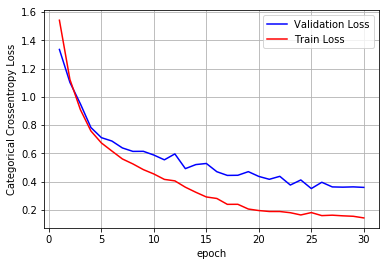

In [158]:
from keras import optimizers
batch_size = 32
# Initiliazing the sequential model
from keras import regularizers
from keras.layers import BatchNormalization
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, input_dim),kernel_initializer='glorot_normal'))
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(64))
# Adding a dropout layer
model.add(Dropout(0.4))
# Adding a dense output layer with sigmoid activation
sgd = optimizers.Adam(lr=0.0001)
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
print(model.summary())

# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

print(confusion_matrix(Y_test, model.predict(X_test)))
score = model.evaluate(X_test, Y_test)
print(score)

#### Test Accuracy with Architecture7 is 88.97% and loss is 0.35

### Archictecture8---2 LSTM layers(64,48), 2 Dropout layers(0.5,0.5),Batch Normalization,batch_size=48

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_23 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 48)                21696     
_________________________________________________________________
dropout_24 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 294       
Total params: 41,190
Trainable params: 41,062
Non-trainable params: 128
_________________________________________________________________
None

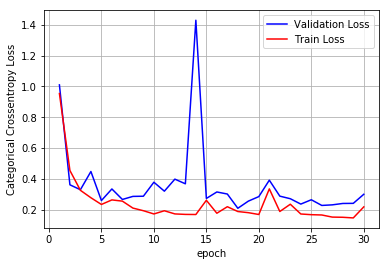

In [52]:
batch_size = 48
from keras.regularizers import L1L2
# Initiliazing the sequential model
from keras import regularizers
from keras.layers import BatchNormalization
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, input_dim),kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(48))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

print(confusion_matrix(Y_test, model.predict(X_test)))
score = model.evaluate(X_test, Y_test)
print(score)

#### Test Accuracy with Architecture8 is 90.66% and loss is 0.30

# Divide and Conquer Approach 

### Generating data into two classes of static(stationary) and dynamic(moving) activities 

In [113]:
X_first_train=[]
X_first_test=[]
Y_first_train=[]
Y_first_test=[]

In [114]:
from tqdm import tqdm
for i in tqdm(range(7352)):
    if (np.where(Y_train[i]==1)[0]<=2):
        X_first_train.append(X_train[i])
        Y_first_train.append([1,0])
    else:
        X_first_train.append(X_train[i])
        Y_first_train.append([0,1])
        

100%|██████████████████████████████████████████████████████████████████████████| 7352/7352 [00:00<00:00, 175509.67it/s]


In [115]:
for i in tqdm(range(2947)):
    if (np.where(Y_train[i]==1)[0]<=2):
        X_first_test.append(X_train[i])
        Y_first_test.append([1,0])
    else:
        X_first_test.append(X_train[i])
        Y_first_test.append([0,1])

100%|██████████████████████████████████████████████████████████████████████████| 2947/2947 [00:00<00:00, 134294.65it/s]


In [116]:
X_first_train=np.array(X_first_train)
X_first_test=np.array(X_first_test)
Y_first_train=np.array(Y_first_train)
Y_first_test=np.array(Y_first_test)

In [117]:
X_first_train.shape

(7352, 128, 9)

In [118]:
X_first_test.shape

(2947, 128, 9)

In [119]:
Y_first_train.shape

(7352, 2)

In [120]:
Y_first_test.shape

(2947, 2)

### LSTM Model to predict whether given activity is static(stationary) or dynamic(moving)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 48)                21696     
_________________________________________________________________
dropout_11 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 98        
Total params: 40,994
Trainable params: 40,866
Non-trainable params: 128
_________________________________________________________________
None

4992/7352 [===================>..........] - ETA: 17:08 - loss: 0.8017 - acc: 0.58 - ETA: 9:18 - loss: 0.7525 - acc: 0.6042 - ETA: 6:40 - loss: 0.7067 - acc: 0.652 - ETA: 5:23 - loss: 0.6925 - acc: 0.666 - ETA: 4:36 - loss: 0.7022 - acc: 0.666 - ETA: 4:06 - loss: 0.6942 - acc: 0.680 - ETA: 3:43 - loss: 0.6764 - acc: 0.690 - ETA: 3:26 - loss: 0.6869 - acc: 0.682 - ETA: 3:15 - loss: 0.6676 - acc: 0.703 - ETA: 3:05 - loss: 0.6712 - acc: 0.704 - ETA: 2:56 - loss: 0.6578 - acc: 0.712 - ETA: 2:57 - loss: 0.6441 - acc: 0.722 - ETA: 2:49 - loss: 0.6350 - acc: 0.730 - ETA: 2:43 - loss: 0.6254 - acc: 0.738 - ETA: 2:38 - loss: 0.6204 - acc: 0.736 - ETA: 2:32 - loss: 0.6192 - acc: 0.739 - ETA: 2:28 - loss: 0.6096 - acc: 0.745 - ETA: 2:23 - loss: 0.6053 - acc: 0.745 - ETA: 2:20 - loss: 0.5946 - acc: 0.754 - ETA: 2:17 - loss: 0.5912 - acc: 0.756 - ETA: 2:13 - loss: 0.5844 - acc: 0.763 - ETA: 2:10 - loss: 0.5765 - acc: 0.767 - ETA: 2:08 - loss: 0.5727 - acc: 0.769 - ETA: 2:05 - loss: 0.5700 - acc: 0.

7352/7352 [==============================] - ETA: 32s - loss: 0.2017 - acc: 0.94 - ETA: 32s - loss: 0.2011 - acc: 0.95 - ETA: 32s - loss: 0.2004 - acc: 0.95 - ETA: 31s - loss: 0.1997 - acc: 0.95 - ETA: 31s - loss: 0.1991 - acc: 0.95 - ETA: 31s - loss: 0.1985 - acc: 0.95 - ETA: 30s - loss: 0.1979 - acc: 0.95 - ETA: 30s - loss: 0.1973 - acc: 0.95 - ETA: 30s - loss: 0.1966 - acc: 0.95 - ETA: 29s - loss: 0.1960 - acc: 0.95 - ETA: 29s - loss: 0.1958 - acc: 0.95 - ETA: 29s - loss: 0.1952 - acc: 0.95 - ETA: 28s - loss: 0.1947 - acc: 0.95 - ETA: 28s - loss: 0.1945 - acc: 0.95 - ETA: 27s - loss: 0.1939 - acc: 0.95 - ETA: 27s - loss: 0.1933 - acc: 0.95 - ETA: 27s - loss: 0.1927 - acc: 0.95 - ETA: 26s - loss: 0.1921 - acc: 0.95 - ETA: 26s - loss: 0.1915 - acc: 0.95 - ETA: 26s - loss: 0.1909 - acc: 0.95 - ETA: 25s - loss: 0.1903 - acc: 0.95 - ETA: 25s - loss: 0.1898 - acc: 0.95 - ETA: 25s - loss: 0.1892 - acc: 0.95 - ETA: 24s - loss: 0.1887 - acc: 0.95 - ETA: 24s - loss: 0.1882 - acc: 0.95 - ETA: 

5016/7352 [===================>..........] - ETA: 1:26 - loss: 0.0411 - acc: 1.000 - ETA: 1:27 - loss: 0.0389 - acc: 1.000 - ETA: 1:28 - loss: 0.0416 - acc: 1.000 - ETA: 1:32 - loss: 0.0448 - acc: 1.000 - ETA: 1:33 - loss: 0.0512 - acc: 0.991 - ETA: 1:33 - loss: 0.0506 - acc: 0.993 - ETA: 1:32 - loss: 0.0493 - acc: 0.994 - ETA: 1:31 - loss: 0.0482 - acc: 0.994 - ETA: 1:30 - loss: 0.0581 - acc: 0.990 - ETA: 1:29 - loss: 0.0565 - acc: 0.991 - ETA: 1:29 - loss: 0.0553 - acc: 0.992 - ETA: 1:27 - loss: 0.0539 - acc: 0.993 - ETA: 1:31 - loss: 0.0529 - acc: 0.993 - ETA: 1:31 - loss: 0.0609 - acc: 0.991 - ETA: 1:31 - loss: 0.0597 - acc: 0.991 - ETA: 1:30 - loss: 0.0583 - acc: 0.992 - ETA: 1:30 - loss: 0.0585 - acc: 0.992 - ETA: 1:30 - loss: 0.0573 - acc: 0.993 - ETA: 1:29 - loss: 0.0565 - acc: 0.993 - ETA: 1:29 - loss: 0.0559 - acc: 0.993 - ETA: 1:28 - loss: 0.0557 - acc: 0.994 - ETA: 1:28 - loss: 0.0549 - acc: 0.994 - ETA: 1:27 - loss: 0.0544 - acc: 0.994 - ETA: 1:26 - loss: 0.0569 - acc: 0.9

7352/7352 [==============================] - ETA: 30s - loss: 0.0490 - acc: 0.99 - ETA: 29s - loss: 0.0489 - acc: 0.99 - ETA: 29s - loss: 0.0489 - acc: 0.99 - ETA: 29s - loss: 0.0488 - acc: 0.99 - ETA: 28s - loss: 0.0488 - acc: 0.99 - ETA: 28s - loss: 0.0487 - acc: 0.99 - ETA: 28s - loss: 0.0486 - acc: 0.99 - ETA: 27s - loss: 0.0485 - acc: 0.99 - ETA: 27s - loss: 0.0485 - acc: 0.99 - ETA: 27s - loss: 0.0484 - acc: 0.99 - ETA: 27s - loss: 0.0483 - acc: 0.99 - ETA: 26s - loss: 0.0483 - acc: 0.99 - ETA: 26s - loss: 0.0483 - acc: 0.99 - ETA: 26s - loss: 0.0482 - acc: 0.99 - ETA: 25s - loss: 0.0481 - acc: 0.99 - ETA: 25s - loss: 0.0481 - acc: 0.99 - ETA: 25s - loss: 0.0481 - acc: 0.99 - ETA: 24s - loss: 0.0480 - acc: 0.99 - ETA: 24s - loss: 0.0480 - acc: 0.99 - ETA: 24s - loss: 0.0479 - acc: 0.99 - ETA: 23s - loss: 0.0478 - acc: 0.99 - ETA: 23s - loss: 0.0478 - acc: 0.99 - ETA: 23s - loss: 0.0477 - acc: 0.99 - ETA: 22s - loss: 0.0476 - acc: 0.99 - ETA: 22s - loss: 0.0476 - acc: 0.99 - ETA: 

5016/7352 [===================>..........] - ETA: 1:28 - loss: 0.0278 - acc: 1.000 - ETA: 1:28 - loss: 0.0272 - acc: 1.000 - ETA: 1:25 - loss: 0.0280 - acc: 1.000 - ETA: 1:25 - loss: 0.0280 - acc: 1.000 - ETA: 1:26 - loss: 0.0283 - acc: 1.000 - ETA: 1:25 - loss: 0.0282 - acc: 1.000 - ETA: 1:24 - loss: 0.0283 - acc: 1.000 - ETA: 1:24 - loss: 0.0282 - acc: 1.000 - ETA: 1:25 - loss: 0.0280 - acc: 1.000 - ETA: 1:26 - loss: 0.0283 - acc: 1.000 - ETA: 1:25 - loss: 0.0289 - acc: 1.000 - ETA: 1:25 - loss: 0.0288 - acc: 1.000 - ETA: 1:25 - loss: 0.0287 - acc: 1.000 - ETA: 1:25 - loss: 0.0288 - acc: 1.000 - ETA: 1:24 - loss: 0.0288 - acc: 1.000 - ETA: 1:24 - loss: 0.0292 - acc: 1.000 - ETA: 1:29 - loss: 0.0292 - acc: 1.000 - ETA: 1:29 - loss: 0.0292 - acc: 1.000 - ETA: 1:28 - loss: 0.0292 - acc: 1.000 - ETA: 1:27 - loss: 0.0292 - acc: 1.000 - ETA: 1:26 - loss: 0.0293 - acc: 1.000 - ETA: 1:26 - loss: 0.0292 - acc: 1.000 - ETA: 1:25 - loss: 0.0292 - acc: 1.000 - ETA: 1:25 - loss: 0.0297 - acc: 1.0

7352/7352 [==============================] - ETA: 29s - loss: 0.0317 - acc: 0.99 - ETA: 29s - loss: 0.0317 - acc: 0.99 - ETA: 29s - loss: 0.0317 - acc: 0.99 - ETA: 28s - loss: 0.0316 - acc: 0.99 - ETA: 28s - loss: 0.0316 - acc: 0.99 - ETA: 28s - loss: 0.0315 - acc: 0.99 - ETA: 27s - loss: 0.0315 - acc: 0.99 - ETA: 27s - loss: 0.0314 - acc: 0.99 - ETA: 27s - loss: 0.0314 - acc: 0.99 - ETA: 26s - loss: 0.0314 - acc: 0.99 - ETA: 26s - loss: 0.0313 - acc: 0.99 - ETA: 26s - loss: 0.0313 - acc: 0.99 - ETA: 25s - loss: 0.0312 - acc: 0.99 - ETA: 25s - loss: 0.0312 - acc: 0.99 - ETA: 25s - loss: 0.0312 - acc: 0.99 - ETA: 25s - loss: 0.0311 - acc: 0.99 - ETA: 24s - loss: 0.0311 - acc: 0.99 - ETA: 24s - loss: 0.0311 - acc: 0.99 - ETA: 24s - loss: 0.0310 - acc: 0.99 - ETA: 23s - loss: 0.0310 - acc: 0.99 - ETA: 23s - loss: 0.0309 - acc: 0.99 - ETA: 23s - loss: 0.0309 - acc: 0.99 - ETA: 23s - loss: 0.0308 - acc: 0.99 - ETA: 22s - loss: 0.0308 - acc: 0.99 - ETA: 22s - loss: 0.0308 - acc: 0.99 - ETA: 

5016/7352 [===================>..........] - ETA: 1:25 - loss: 0.0186 - acc: 1.000 - ETA: 1:42 - loss: 0.0207 - acc: 1.000 - ETA: 1:39 - loss: 0.0203 - acc: 1.000 - ETA: 1:36 - loss: 0.0199 - acc: 1.000 - ETA: 1:33 - loss: 0.0198 - acc: 1.000 - ETA: 1:36 - loss: 0.0197 - acc: 1.000 - ETA: 1:41 - loss: 0.0197 - acc: 1.000 - ETA: 1:38 - loss: 0.0196 - acc: 1.000 - ETA: 1:36 - loss: 0.0195 - acc: 1.000 - ETA: 1:35 - loss: 0.0195 - acc: 1.000 - ETA: 1:34 - loss: 0.0196 - acc: 1.000 - ETA: 1:33 - loss: 0.0196 - acc: 1.000 - ETA: 1:32 - loss: 0.0196 - acc: 1.000 - ETA: 1:31 - loss: 0.0195 - acc: 1.000 - ETA: 1:30 - loss: 0.0195 - acc: 1.000 - ETA: 1:30 - loss: 0.0195 - acc: 1.000 - ETA: 1:29 - loss: 0.0314 - acc: 0.997 - ETA: 1:28 - loss: 0.0306 - acc: 0.997 - ETA: 1:28 - loss: 0.0300 - acc: 0.997 - ETA: 1:27 - loss: 0.0295 - acc: 0.997 - ETA: 1:27 - loss: 0.0290 - acc: 0.998 - ETA: 1:26 - loss: 0.0285 - acc: 0.998 - ETA: 1:25 - loss: 0.0282 - acc: 0.998 - ETA: 1:27 - loss: 0.0279 - acc: 0.9

7352/7352 [==============================] - ETA: 28s - loss: 0.0242 - acc: 0.99 - ETA: 28s - loss: 0.0242 - acc: 0.99 - ETA: 28s - loss: 0.0241 - acc: 0.99 - ETA: 27s - loss: 0.0241 - acc: 0.99 - ETA: 27s - loss: 0.0241 - acc: 0.99 - ETA: 27s - loss: 0.0240 - acc: 0.99 - ETA: 27s - loss: 0.0240 - acc: 0.99 - ETA: 26s - loss: 0.0239 - acc: 0.99 - ETA: 26s - loss: 0.0239 - acc: 0.99 - ETA: 26s - loss: 0.0239 - acc: 0.99 - ETA: 25s - loss: 0.0238 - acc: 0.99 - ETA: 25s - loss: 0.0238 - acc: 0.99 - ETA: 25s - loss: 0.0238 - acc: 0.99 - ETA: 25s - loss: 0.0237 - acc: 0.99 - ETA: 24s - loss: 0.0252 - acc: 0.99 - ETA: 24s - loss: 0.0252 - acc: 0.99 - ETA: 24s - loss: 0.0251 - acc: 0.99 - ETA: 23s - loss: 0.0251 - acc: 0.99 - ETA: 23s - loss: 0.0250 - acc: 0.99 - ETA: 23s - loss: 0.0250 - acc: 0.99 - ETA: 22s - loss: 0.0250 - acc: 0.99 - ETA: 22s - loss: 0.0249 - acc: 0.99 - ETA: 22s - loss: 0.0249 - acc: 0.99 - ETA: 22s - loss: 0.0248 - acc: 0.99 - ETA: 21s - loss: 0.0248 - acc: 0.99 - ETA: 

5016/7352 [===================>..........] - ETA: 2:47 - loss: 0.0139 - acc: 1.000 - ETA: 2:12 - loss: 0.0158 - acc: 1.000 - ETA: 2:01 - loss: 0.0150 - acc: 1.000 - ETA: 1:54 - loss: 0.0147 - acc: 1.000 - ETA: 1:49 - loss: 0.0145 - acc: 1.000 - ETA: 1:44 - loss: 0.0145 - acc: 1.000 - ETA: 1:41 - loss: 0.0145 - acc: 1.000 - ETA: 1:41 - loss: 0.0145 - acc: 1.000 - ETA: 1:39 - loss: 0.0144 - acc: 1.000 - ETA: 1:38 - loss: 0.0143 - acc: 1.000 - ETA: 1:38 - loss: 0.0143 - acc: 1.000 - ETA: 1:37 - loss: 0.0142 - acc: 1.000 - ETA: 1:37 - loss: 0.0142 - acc: 1.000 - ETA: 1:37 - loss: 0.0142 - acc: 1.000 - ETA: 1:36 - loss: 0.0142 - acc: 1.000 - ETA: 1:35 - loss: 0.0141 - acc: 1.000 - ETA: 1:34 - loss: 0.0142 - acc: 1.000 - ETA: 1:37 - loss: 0.0141 - acc: 1.000 - ETA: 1:36 - loss: 0.0141 - acc: 1.000 - ETA: 1:35 - loss: 0.0141 - acc: 1.000 - ETA: 1:35 - loss: 0.0141 - acc: 1.000 - ETA: 1:35 - loss: 0.0140 - acc: 1.000 - ETA: 1:34 - loss: 0.0140 - acc: 1.000 - ETA: 1:34 - loss: 0.0140 - acc: 1.0

7352/7352 [==============================] - ETA: 31s - loss: 0.0143 - acc: 0.99 - ETA: 30s - loss: 0.0142 - acc: 0.99 - ETA: 30s - loss: 0.0142 - acc: 0.99 - ETA: 30s - loss: 0.0142 - acc: 0.99 - ETA: 29s - loss: 0.0142 - acc: 0.99 - ETA: 29s - loss: 0.0142 - acc: 0.99 - ETA: 29s - loss: 0.0142 - acc: 0.99 - ETA: 28s - loss: 0.0141 - acc: 0.99 - ETA: 28s - loss: 0.0141 - acc: 0.99 - ETA: 28s - loss: 0.0141 - acc: 0.99 - ETA: 27s - loss: 0.0141 - acc: 0.99 - ETA: 27s - loss: 0.0141 - acc: 0.99 - ETA: 27s - loss: 0.0141 - acc: 0.99 - ETA: 26s - loss: 0.0141 - acc: 0.99 - ETA: 26s - loss: 0.0140 - acc: 0.99 - ETA: 26s - loss: 0.0140 - acc: 0.99 - ETA: 25s - loss: 0.0140 - acc: 0.99 - ETA: 25s - loss: 0.0140 - acc: 0.99 - ETA: 25s - loss: 0.0140 - acc: 0.99 - ETA: 24s - loss: 0.0140 - acc: 0.99 - ETA: 24s - loss: 0.0140 - acc: 0.99 - ETA: 24s - loss: 0.0139 - acc: 0.99 - ETA: 23s - loss: 0.0139 - acc: 0.99 - ETA: 23s - loss: 0.0139 - acc: 0.99 - ETA: 23s - loss: 0.0139 - acc: 0.99 - ETA: 

5016/7352 [===================>..........] - ETA: 1:55 - loss: 0.0097 - acc: 1.000 - ETA: 2:03 - loss: 0.0102 - acc: 1.000 - ETA: 1:48 - loss: 0.0100 - acc: 1.000 - ETA: 1:42 - loss: 0.0100 - acc: 1.000 - ETA: 1:39 - loss: 0.0099 - acc: 1.000 - ETA: 1:38 - loss: 0.0101 - acc: 1.000 - ETA: 1:35 - loss: 0.0101 - acc: 1.000 - ETA: 1:35 - loss: 0.0100 - acc: 1.000 - ETA: 1:34 - loss: 0.0102 - acc: 1.000 - ETA: 1:33 - loss: 0.0101 - acc: 1.000 - ETA: 1:32 - loss: 0.0101 - acc: 1.000 - ETA: 1:31 - loss: 0.0100 - acc: 1.000 - ETA: 1:30 - loss: 0.0100 - acc: 1.000 - ETA: 1:29 - loss: 0.0099 - acc: 1.000 - ETA: 1:29 - loss: 0.0099 - acc: 1.000 - ETA: 1:28 - loss: 0.0099 - acc: 1.000 - ETA: 1:28 - loss: 0.0099 - acc: 1.000 - ETA: 1:27 - loss: 0.0099 - acc: 1.000 - ETA: 1:31 - loss: 0.0098 - acc: 1.000 - ETA: 1:31 - loss: 0.0098 - acc: 1.000 - ETA: 1:30 - loss: 0.0098 - acc: 1.000 - ETA: 1:30 - loss: 0.0098 - acc: 1.000 - ETA: 1:29 - loss: 0.0098 - acc: 1.000 - ETA: 1:28 - loss: 0.0097 - acc: 1.0

7352/7352 [==============================] - ETA: 31s - loss: 0.0123 - acc: 0.99 - ETA: 31s - loss: 0.0123 - acc: 0.99 - ETA: 30s - loss: 0.0123 - acc: 0.99 - ETA: 30s - loss: 0.0123 - acc: 0.99 - ETA: 30s - loss: 0.0122 - acc: 0.99 - ETA: 29s - loss: 0.0122 - acc: 0.99 - ETA: 29s - loss: 0.0122 - acc: 0.99 - ETA: 29s - loss: 0.0122 - acc: 0.99 - ETA: 28s - loss: 0.0122 - acc: 0.99 - ETA: 28s - loss: 0.0122 - acc: 0.99 - ETA: 28s - loss: 0.0122 - acc: 0.99 - ETA: 27s - loss: 0.0121 - acc: 0.99 - ETA: 27s - loss: 0.0121 - acc: 0.99 - ETA: 27s - loss: 0.0121 - acc: 0.99 - ETA: 26s - loss: 0.0121 - acc: 0.99 - ETA: 26s - loss: 0.0121 - acc: 0.99 - ETA: 26s - loss: 0.0121 - acc: 0.99 - ETA: 25s - loss: 0.0121 - acc: 0.99 - ETA: 25s - loss: 0.0121 - acc: 0.99 - ETA: 25s - loss: 0.0120 - acc: 0.99 - ETA: 24s - loss: 0.0120 - acc: 0.99 - ETA: 24s - loss: 0.0120 - acc: 0.99 - ETA: 24s - loss: 0.0120 - acc: 0.99 - ETA: 23s - loss: 0.0120 - acc: 0.99 - ETA: 23s - loss: 0.0120 - acc: 0.99 - ETA: 

5016/7352 [===================>..........] - ETA: 2:05 - loss: 0.0076 - acc: 1.000 - ETA: 2:03 - loss: 0.0080 - acc: 1.000 - ETA: 1:54 - loss: 0.0080 - acc: 1.000 - ETA: 1:48 - loss: 0.0079 - acc: 1.000 - ETA: 1:44 - loss: 0.0086 - acc: 1.000 - ETA: 1:41 - loss: 0.0086 - acc: 1.000 - ETA: 1:39 - loss: 0.0085 - acc: 1.000 - ETA: 1:38 - loss: 0.0084 - acc: 1.000 - ETA: 1:37 - loss: 0.0083 - acc: 1.000 - ETA: 1:35 - loss: 0.0082 - acc: 1.000 - ETA: 1:35 - loss: 0.0082 - acc: 1.000 - ETA: 1:34 - loss: 0.0082 - acc: 1.000 - ETA: 1:33 - loss: 0.0082 - acc: 1.000 - ETA: 1:32 - loss: 0.0082 - acc: 1.000 - ETA: 1:32 - loss: 0.0081 - acc: 1.000 - ETA: 1:31 - loss: 0.0081 - acc: 1.000 - ETA: 1:30 - loss: 0.0082 - acc: 1.000 - ETA: 1:31 - loss: 0.0082 - acc: 1.000 - ETA: 1:32 - loss: 0.0082 - acc: 1.000 - ETA: 1:31 - loss: 0.0082 - acc: 1.000 - ETA: 1:30 - loss: 0.0082 - acc: 1.000 - ETA: 1:29 - loss: 0.0082 - acc: 1.000 - ETA: 1:29 - loss: 0.0082 - acc: 1.000 - ETA: 1:29 - loss: 0.0081 - acc: 1.0

7352/7352 [==============================] - ETA: 30s - loss: 0.0100 - acc: 0.99 - ETA: 30s - loss: 0.0100 - acc: 0.99 - ETA: 29s - loss: 0.0100 - acc: 0.99 - ETA: 29s - loss: 0.0100 - acc: 0.99 - ETA: 29s - loss: 0.0099 - acc: 0.99 - ETA: 28s - loss: 0.0099 - acc: 0.99 - ETA: 28s - loss: 0.0099 - acc: 0.99 - ETA: 28s - loss: 0.0099 - acc: 0.99 - ETA: 27s - loss: 0.0099 - acc: 0.99 - ETA: 27s - loss: 0.0099 - acc: 0.99 - ETA: 27s - loss: 0.0098 - acc: 0.99 - ETA: 26s - loss: 0.0098 - acc: 0.99 - ETA: 26s - loss: 0.0098 - acc: 0.99 - ETA: 26s - loss: 0.0098 - acc: 0.99 - ETA: 25s - loss: 0.0098 - acc: 0.99 - ETA: 25s - loss: 0.0098 - acc: 0.99 - ETA: 25s - loss: 0.0097 - acc: 0.99 - ETA: 24s - loss: 0.0097 - acc: 0.99 - ETA: 24s - loss: 0.0097 - acc: 0.99 - ETA: 24s - loss: 0.0097 - acc: 0.99 - ETA: 24s - loss: 0.0097 - acc: 0.99 - ETA: 23s - loss: 0.0097 - acc: 0.99 - ETA: 23s - loss: 0.0097 - acc: 0.99 - ETA: 23s - loss: 0.0096 - acc: 0.99 - ETA: 22s - loss: 0.0096 - acc: 0.99 - ETA: 

5016/7352 [===================>..........] - ETA: 1:36 - loss: 0.0068 - acc: 1.000 - ETA: 1:31 - loss: 0.0060 - acc: 1.000 - ETA: 1:33 - loss: 0.0057 - acc: 1.000 - ETA: 1:35 - loss: 0.0057 - acc: 1.000 - ETA: 1:46 - loss: 0.0056 - acc: 1.000 - ETA: 1:44 - loss: 0.0056 - acc: 1.000 - ETA: 1:42 - loss: 0.0055 - acc: 1.000 - ETA: 1:41 - loss: 0.0061 - acc: 1.000 - ETA: 1:39 - loss: 0.0060 - acc: 1.000 - ETA: 1:38 - loss: 0.0060 - acc: 1.000 - ETA: 1:37 - loss: 0.0059 - acc: 1.000 - ETA: 1:36 - loss: 0.0059 - acc: 1.000 - ETA: 1:35 - loss: 0.0059 - acc: 1.000 - ETA: 1:35 - loss: 0.0058 - acc: 1.000 - ETA: 1:34 - loss: 0.0215 - acc: 0.997 - ETA: 1:33 - loss: 0.0205 - acc: 0.997 - ETA: 1:32 - loss: 0.0196 - acc: 0.997 - ETA: 1:31 - loss: 0.0188 - acc: 0.997 - ETA: 1:30 - loss: 0.0181 - acc: 0.997 - ETA: 1:30 - loss: 0.0176 - acc: 0.997 - ETA: 1:32 - loss: 0.0516 - acc: 0.990 - ETA: 1:33 - loss: 0.0496 - acc: 0.990 - ETA: 1:33 - loss: 0.0556 - acc: 0.989 - ETA: 1:32 - loss: 0.0941 - acc: 0.9

7352/7352 [==============================] - ETA: 30s - loss: 0.0349 - acc: 0.99 - ETA: 30s - loss: 0.0348 - acc: 0.99 - ETA: 30s - loss: 0.0347 - acc: 0.99 - ETA: 29s - loss: 0.0346 - acc: 0.99 - ETA: 29s - loss: 0.0345 - acc: 0.99 - ETA: 29s - loss: 0.0344 - acc: 0.99 - ETA: 28s - loss: 0.0343 - acc: 0.99 - ETA: 28s - loss: 0.0342 - acc: 0.99 - ETA: 28s - loss: 0.0341 - acc: 0.99 - ETA: 28s - loss: 0.0340 - acc: 0.99 - ETA: 27s - loss: 0.0339 - acc: 0.99 - ETA: 27s - loss: 0.0338 - acc: 0.99 - ETA: 27s - loss: 0.0337 - acc: 0.99 - ETA: 26s - loss: 0.0336 - acc: 0.99 - ETA: 26s - loss: 0.0335 - acc: 0.99 - ETA: 26s - loss: 0.0334 - acc: 0.99 - ETA: 25s - loss: 0.0333 - acc: 0.99 - ETA: 25s - loss: 0.0332 - acc: 0.99 - ETA: 25s - loss: 0.0331 - acc: 0.99 - ETA: 24s - loss: 0.0330 - acc: 0.99 - ETA: 24s - loss: 0.0329 - acc: 0.99 - ETA: 24s - loss: 0.0328 - acc: 0.99 - ETA: 23s - loss: 0.0327 - acc: 0.99 - ETA: 23s - loss: 0.0326 - acc: 0.99 - ETA: 23s - loss: 0.0325 - acc: 0.99 - ETA: 

5016/7352 [===================>..........] - ETA: 1:22 - loss: 0.0223 - acc: 1.000 - ETA: 1:22 - loss: 0.0196 - acc: 1.000 - ETA: 1:24 - loss: 0.0177 - acc: 1.000 - ETA: 1:31 - loss: 0.0158 - acc: 1.000 - ETA: 1:33 - loss: 0.0147 - acc: 1.000 - ETA: 1:35 - loss: 0.0140 - acc: 1.000 - ETA: 1:34 - loss: 0.0134 - acc: 1.000 - ETA: 1:32 - loss: 0.0130 - acc: 1.000 - ETA: 1:32 - loss: 0.0127 - acc: 1.000 - ETA: 1:31 - loss: 0.0125 - acc: 1.000 - ETA: 1:31 - loss: 0.0123 - acc: 1.000 - ETA: 1:30 - loss: 0.0121 - acc: 1.000 - ETA: 1:29 - loss: 0.0119 - acc: 1.000 - ETA: 1:28 - loss: 0.0118 - acc: 1.000 - ETA: 1:27 - loss: 0.0117 - acc: 1.000 - ETA: 1:26 - loss: 0.0116 - acc: 1.000 - ETA: 1:26 - loss: 0.0115 - acc: 1.000 - ETA: 1:26 - loss: 0.0114 - acc: 1.000 - ETA: 1:26 - loss: 0.0113 - acc: 1.000 - ETA: 1:25 - loss: 0.0112 - acc: 1.000 - ETA: 1:25 - loss: 0.0112 - acc: 1.000 - ETA: 1:25 - loss: 0.0115 - acc: 1.000 - ETA: 1:26 - loss: 0.0114 - acc: 1.000 - ETA: 1:26 - loss: 0.0113 - acc: 1.0

7352/7352 [==============================] - ETA: 30s - loss: 0.0120 - acc: 0.99 - ETA: 29s - loss: 0.0120 - acc: 0.99 - ETA: 29s - loss: 0.0120 - acc: 0.99 - ETA: 29s - loss: 0.0119 - acc: 0.99 - ETA: 28s - loss: 0.0119 - acc: 0.99 - ETA: 28s - loss: 0.0119 - acc: 0.99 - ETA: 28s - loss: 0.0119 - acc: 0.99 - ETA: 28s - loss: 0.0119 - acc: 0.99 - ETA: 27s - loss: 0.0118 - acc: 0.99 - ETA: 27s - loss: 0.0118 - acc: 0.99 - ETA: 27s - loss: 0.0118 - acc: 0.99 - ETA: 26s - loss: 0.0118 - acc: 0.99 - ETA: 26s - loss: 0.0118 - acc: 0.99 - ETA: 26s - loss: 0.0117 - acc: 0.99 - ETA: 25s - loss: 0.0117 - acc: 0.99 - ETA: 25s - loss: 0.0117 - acc: 0.99 - ETA: 25s - loss: 0.0117 - acc: 0.99 - ETA: 24s - loss: 0.0117 - acc: 0.99 - ETA: 24s - loss: 0.0116 - acc: 0.99 - ETA: 24s - loss: 0.0116 - acc: 0.99 - ETA: 23s - loss: 0.0116 - acc: 0.99 - ETA: 23s - loss: 0.0116 - acc: 0.99 - ETA: 23s - loss: 0.0116 - acc: 0.99 - ETA: 22s - loss: 0.0115 - acc: 0.99 - ETA: 22s - loss: 0.0115 - acc: 0.99 - ETA: 

5016/7352 [===================>..........] - ETA: 1:39 - loss: 0.0085 - acc: 1.000 - ETA: 1:38 - loss: 0.0097 - acc: 1.000 - ETA: 1:35 - loss: 0.0100 - acc: 1.000 - ETA: 1:32 - loss: 0.0206 - acc: 0.989 - ETA: 1:29 - loss: 0.0183 - acc: 0.991 - ETA: 1:29 - loss: 0.0176 - acc: 0.993 - ETA: 1:28 - loss: 0.0164 - acc: 0.994 - ETA: 1:31 - loss: 0.0157 - acc: 0.994 - ETA: 1:32 - loss: 0.0150 - acc: 0.995 - ETA: 1:33 - loss: 0.0146 - acc: 0.995 - ETA: 1:38 - loss: 0.0141 - acc: 0.996 - ETA: 1:36 - loss: 0.0137 - acc: 0.996 - ETA: 1:34 - loss: 0.0133 - acc: 0.996 - ETA: 1:34 - loss: 0.0131 - acc: 0.997 - ETA: 1:34 - loss: 0.0129 - acc: 0.997 - ETA: 1:34 - loss: 0.0275 - acc: 0.994 - ETA: 1:34 - loss: 0.0265 - acc: 0.995 - ETA: 1:34 - loss: 0.0255 - acc: 0.995 - ETA: 1:34 - loss: 0.0247 - acc: 0.995 - ETA: 1:33 - loss: 0.0240 - acc: 0.995 - ETA: 1:32 - loss: 0.0235 - acc: 0.996 - ETA: 1:32 - loss: 0.0250 - acc: 0.996 - ETA: 1:33 - loss: 0.0254 - acc: 0.996 - ETA: 1:32 - loss: 0.0295 - acc: 0.9

7352/7352 [==============================] - ETA: 30s - loss: 0.0162 - acc: 0.99 - ETA: 30s - loss: 0.0163 - acc: 0.99 - ETA: 30s - loss: 0.0163 - acc: 0.99 - ETA: 29s - loss: 0.0163 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 28s - loss: 0.0161 - acc: 0.99 - ETA: 28s - loss: 0.0161 - acc: 0.99 - ETA: 28s - loss: 0.0161 - acc: 0.99 - ETA: 27s - loss: 0.0160 - acc: 0.99 - ETA: 27s - loss: 0.0160 - acc: 0.99 - ETA: 27s - loss: 0.0160 - acc: 0.99 - ETA: 26s - loss: 0.0159 - acc: 0.99 - ETA: 26s - loss: 0.0159 - acc: 0.99 - ETA: 26s - loss: 0.0159 - acc: 0.99 - ETA: 25s - loss: 0.0158 - acc: 0.99 - ETA: 25s - loss: 0.0158 - acc: 0.99 - ETA: 25s - loss: 0.0158 - acc: 0.99 - ETA: 24s - loss: 0.0157 - acc: 0.99 - ETA: 24s - loss: 0.0157 - acc: 0.99 - ETA: 24s - loss: 0.0157 - acc: 0.99 - ETA: 23s - loss: 0.0156 - acc: 0.99 - ETA: 23s - loss: 0.0156 - acc: 0.99 - ETA: 23s - loss: 0.0156 - acc: 0.99 - ETA: 23s - loss: 0.0155 - acc: 0.99 - ETA: 

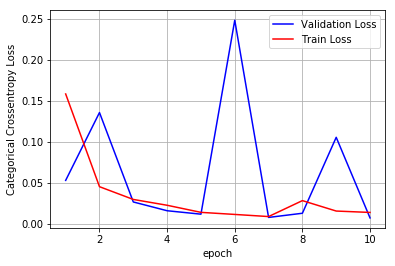

In [122]:
batch_size = 24
from keras.regularizers import L1L2
# Initiliazing the sequential model
from keras import regularizers
from keras.layers import BatchNormalization
model_first = Sequential()
# Configuring the parameters
model_first.add(LSTM(64, return_sequences=True, input_shape=(timesteps, input_dim),kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model_first.add(BatchNormalization())
# Adding a dropout layer
model_first.add(Dropout(0.5))
model_first.add(LSTM(48))
# Adding a dropout layer
model_first.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model_first.add(Dense(2, activation='softmax'))
model_first.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model_first.summary())

# Training the model
history_first=model_first.fit(X_first_train,
          Y_first_train,
          batch_size=batch_size,
          validation_data=(X_first_test, Y_first_test),
          epochs=10)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,10+1))

vy = history_first.history['val_loss']
ty = history_first.history['loss']
plt_dynamic(x, vy, ty, ax)

print(confusion_matrix(Y_first_test, model.predict(X_first_test)))
score = model_first.evaluate(X_first_test, Y_first_test)
print(score)

#### So we are classifying whether a activity is static(stationary) or dynamic(moving) with 99.96% accuracy after this we will build two seperate model one for classfying 3 classes of static(stationary) activity and one for classfying 3 classes of dynamic(moving) activity

### Generating data for dynamic(moving) and static(stationary) seperately with there 3 classes

In [123]:
Y_train.shape

(7352, 6)

In [124]:
X_train.shape

(7352, 128, 9)

In [125]:
X_moving_train=[]
Y_moving_train=[]
X_stationary_train=[]
Y_stationary_train=[]

In [126]:
from tqdm import tqdm
for i in tqdm(range(7352)):
    if (np.where(Y_train[i]==1)[0]==0):
        X_moving_train.append(X_train[i])
        Y_moving_train.append([1,0,0])
    elif (np.where(Y_train[i]==1)[0]==1):
        X_moving_train.append(X_train[i])
        Y_moving_train.append([0,1,0])
    elif (np.where(Y_train[i]==1)[0]==2):
        X_moving_train.append(X_train[i])
        Y_moving_train.append([0,0,1])
    elif (np.where(Y_train[i]==1)[0]==3):
        X_stationary_train.append(X_train[i])
        Y_stationary_train.append([1,0,0])
    elif (np.where(Y_train[i]==1)[0]==4):
        X_stationary_train.append(X_train[i])
        Y_stationary_train.append([0,1,0])
    elif (np.where(Y_train[i]==1)[0]==5):
        X_stationary_train.append(X_train[i])
        Y_stationary_train.append([0,0,1])
        

100%|███████████████████████████████████████████████████████████████████████████| 7352/7352 [00:00<00:00, 64661.30it/s]


In [127]:
X_moving_train=np.array(X_moving_train)
Y_moving_train=np.array(Y_moving_train)
X_stationary_train=np.array(X_stationary_train)
Y_stationary_train=np.array(Y_stationary_train)

In [128]:
X_moving_train.shape

(3285, 128, 9)

In [129]:
Y_moving_train.shape

(3285, 3)

In [130]:
X_stationary_train.shape

(4067, 128, 9)

In [131]:
Y_stationary_train.shape

(4067, 3)

In [132]:
X_moving_test=[]
Y_moving_test=[]
X_stationary_test=[]
Y_stationary_test=[]

In [133]:
X_test.shape

(2947, 128, 9)

In [134]:
Y_test.shape

(2947, 6)

In [135]:
from tqdm import tqdm
for i in tqdm(range(2947)):
    if (np.where(Y_test[i]==1)[0]==0):
        X_moving_test.append(X_test[i])
        Y_moving_test.append([1,0,0])
    elif (np.where(Y_test[i]==1)[0]==1):
        X_moving_test.append(X_test[i])
        Y_moving_test.append([0,1,0])
    elif (np.where(Y_test[i]==1)[0]==2):
        X_moving_test.append(X_test[i])
        Y_moving_test.append([0,0,1])
    elif (np.where(Y_test[i]==1)[0]==3):
        X_stationary_test.append(X_test[i])
        Y_stationary_test.append([1,0,0])
    elif (np.where(Y_test[i]==1)[0]==4):
        X_stationary_test.append(X_test[i])
        Y_stationary_test.append([0,1,0])
    elif (np.where(Y_test[i]==1)[0]==5):
        X_stationary_test.append(X_test[i])
        Y_stationary_test.append([0,0,1])
        

100%|███████████████████████████████████████████████████████████████████████████| 2947/2947 [00:00<00:00, 59099.84it/s]


In [136]:
X_moving_test=np.array(X_moving_test)
Y_moving_test=np.array(Y_moving_test)
X_stationary_test=np.array(X_stationary_test)
Y_stationary_test=np.array(Y_stationary_test)

In [137]:
X_moving_test.shape

(1387, 128, 9)

In [138]:
Y_moving_test.shape

(1387, 3)

In [139]:
X_stationary_test.shape

(1560, 128, 9)

In [140]:
Y_stationary_test.shape

(1560, 3)

### LSTM model for Dynamic(Moving) Activities 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 48)                21696     
_________________________________________________________________
dropout_13 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 147       
Total params: 41,043
Trainable params: 40,915
Non-trainable params: 128
_________________________________________________________________
None

3285/3285 [==============================] - ETA: 45s - loss: 0.2195 - acc: 0.95 - ETA: 43s - loss: 0.3024 - acc: 0.93 - ETA: 42s - loss: 0.2791 - acc: 0.95 - ETA: 43s - loss: 0.2701 - acc: 0.95 - ETA: 43s - loss: 0.2635 - acc: 0.95 - ETA: 42s - loss: 0.3301 - acc: 0.93 - ETA: 42s - loss: 0.3407 - acc: 0.92 - ETA: 41s - loss: 0.3259 - acc: 0.93 - ETA: 40s - loss: 0.3457 - acc: 0.93 - ETA: 41s - loss: 0.3483 - acc: 0.93 - ETA: 40s - loss: 0.3480 - acc: 0.93 - ETA: 40s - loss: 0.3324 - acc: 0.93 - ETA: 39s - loss: 0.3345 - acc: 0.93 - ETA: 39s - loss: 0.3267 - acc: 0.93 - ETA: 40s - loss: 0.3246 - acc: 0.93 - ETA: 40s - loss: 0.3352 - acc: 0.93 - ETA: 39s - loss: 0.3412 - acc: 0.93 - ETA: 39s - loss: 0.3419 - acc: 0.92 - ETA: 38s - loss: 0.3491 - acc: 0.92 - ETA: 38s - loss: 0.3480 - acc: 0.92 - ETA: 37s - loss: 0.3510 - acc: 0.92 - ETA: 37s - loss: 0.3481 - acc: 0.92 - ETA: 36s - loss: 0.3527 - acc: 0.92 - ETA: 36s - loss: 0.3460 - acc: 0.92 - ETA: 36s - loss: 0.3441 - acc: 0.92 - ETA: 

3285/3285 [==============================] - ETA: 39s - loss: 0.1041 - acc: 1.00 - ETA: 40s - loss: 0.1041 - acc: 1.00 - ETA: 39s - loss: 0.0987 - acc: 1.00 - ETA: 39s - loss: 0.1070 - acc: 1.00 - ETA: 40s - loss: 0.1161 - acc: 0.99 - ETA: 39s - loss: 0.1386 - acc: 0.98 - ETA: 39s - loss: 0.1463 - acc: 0.98 - ETA: 38s - loss: 0.1790 - acc: 0.97 - ETA: 38s - loss: 0.1686 - acc: 0.97 - ETA: 39s - loss: 0.1664 - acc: 0.97 - ETA: 38s - loss: 0.1591 - acc: 0.97 - ETA: 37s - loss: 0.1604 - acc: 0.97 - ETA: 37s - loss: 0.1572 - acc: 0.97 - ETA: 36s - loss: 0.1521 - acc: 0.97 - ETA: 36s - loss: 0.1468 - acc: 0.98 - ETA: 37s - loss: 0.1424 - acc: 0.98 - ETA: 37s - loss: 0.1397 - acc: 0.98 - ETA: 36s - loss: 0.1403 - acc: 0.98 - ETA: 36s - loss: 0.1377 - acc: 0.98 - ETA: 36s - loss: 0.1388 - acc: 0.98 - ETA: 35s - loss: 0.1371 - acc: 0.98 - ETA: 35s - loss: 0.1356 - acc: 0.98 - ETA: 35s - loss: 0.1435 - acc: 0.98 - ETA: 34s - loss: 0.1419 - acc: 0.98 - ETA: 34s - loss: 0.1410 - acc: 0.98 - ETA: 

3285/3285 [==============================] - ETA: 36s - loss: 0.0591 - acc: 1.00 - ETA: 37s - loss: 0.0556 - acc: 1.00 - ETA: 37s - loss: 0.0551 - acc: 1.00 - ETA: 38s - loss: 0.0579 - acc: 1.00 - ETA: 39s - loss: 0.0583 - acc: 1.00 - ETA: 39s - loss: 0.0591 - acc: 1.00 - ETA: 39s - loss: 0.0603 - acc: 1.00 - ETA: 40s - loss: 0.0721 - acc: 0.98 - ETA: 40s - loss: 0.0713 - acc: 0.99 - ETA: 39s - loss: 0.0702 - acc: 0.99 - ETA: 39s - loss: 0.0685 - acc: 0.99 - ETA: 39s - loss: 0.0733 - acc: 0.98 - ETA: 38s - loss: 0.0732 - acc: 0.99 - ETA: 38s - loss: 0.0723 - acc: 0.99 - ETA: 39s - loss: 0.0762 - acc: 0.98 - ETA: 38s - loss: 0.0747 - acc: 0.98 - ETA: 38s - loss: 0.0749 - acc: 0.99 - ETA: 37s - loss: 0.0745 - acc: 0.99 - ETA: 37s - loss: 0.0742 - acc: 0.99 - ETA: 37s - loss: 0.0767 - acc: 0.98 - ETA: 36s - loss: 0.0762 - acc: 0.99 - ETA: 36s - loss: 0.0763 - acc: 0.99 - ETA: 35s - loss: 0.0762 - acc: 0.99 - ETA: 35s - loss: 0.0758 - acc: 0.99 - ETA: 35s - loss: 0.0753 - acc: 0.99 - ETA: 

3285/3285 [==============================] - ETA: 41s - loss: 0.1542 - acc: 0.95 - ETA: 38s - loss: 0.2100 - acc: 0.95 - ETA: 38s - loss: 0.1591 - acc: 0.97 - ETA: 38s - loss: 0.1320 - acc: 0.97 - ETA: 37s - loss: 0.1174 - acc: 0.98 - ETA: 36s - loss: 0.1104 - acc: 0.98 - ETA: 36s - loss: 0.1417 - acc: 0.97 - ETA: 36s - loss: 0.1506 - acc: 0.96 - ETA: 37s - loss: 0.1443 - acc: 0.96 - ETA: 37s - loss: 0.1875 - acc: 0.95 - ETA: 36s - loss: 0.1943 - acc: 0.95 - ETA: 36s - loss: 0.1942 - acc: 0.95 - ETA: 35s - loss: 0.1867 - acc: 0.95 - ETA: 35s - loss: 0.1801 - acc: 0.96 - ETA: 34s - loss: 0.1749 - acc: 0.96 - ETA: 34s - loss: 0.1749 - acc: 0.96 - ETA: 35s - loss: 0.1773 - acc: 0.96 - ETA: 35s - loss: 0.1882 - acc: 0.95 - ETA: 34s - loss: 0.1819 - acc: 0.96 - ETA: 34s - loss: 0.1771 - acc: 0.96 - ETA: 33s - loss: 0.1828 - acc: 0.96 - ETA: 33s - loss: 0.1783 - acc: 0.96 - ETA: 33s - loss: 0.1760 - acc: 0.96 - ETA: 32s - loss: 0.1719 - acc: 0.96 - ETA: 32s - loss: 0.1689 - acc: 0.96 - ETA: 

3285/3285 [==============================] - ETA: 39s - loss: 0.4044 - acc: 0.91 - ETA: 37s - loss: 0.2403 - acc: 0.95 - ETA: 43s - loss: 0.2568 - acc: 0.94 - ETA: 42s - loss: 0.3073 - acc: 0.93 - ETA: 40s - loss: 0.2708 - acc: 0.93 - ETA: 40s - loss: 0.2736 - acc: 0.93 - ETA: 39s - loss: 0.2749 - acc: 0.92 - ETA: 39s - loss: 0.2563 - acc: 0.93 - ETA: 38s - loss: 0.2384 - acc: 0.93 - ETA: 38s - loss: 0.2227 - acc: 0.94 - ETA: 37s - loss: 0.2150 - acc: 0.94 - ETA: 38s - loss: 0.2015 - acc: 0.95 - ETA: 38s - loss: 0.1898 - acc: 0.95 - ETA: 37s - loss: 0.2263 - acc: 0.94 - ETA: 37s - loss: 0.2148 - acc: 0.95 - ETA: 36s - loss: 0.2049 - acc: 0.95 - ETA: 36s - loss: 0.2075 - acc: 0.95 - ETA: 35s - loss: 0.2023 - acc: 0.95 - ETA: 35s - loss: 0.1960 - acc: 0.95 - ETA: 35s - loss: 0.2018 - acc: 0.95 - ETA: 35s - loss: 0.1998 - acc: 0.95 - ETA: 35s - loss: 0.1966 - acc: 0.95 - ETA: 34s - loss: 0.1950 - acc: 0.95 - ETA: 34s - loss: 0.2017 - acc: 0.95 - ETA: 33s - loss: 0.2082 - acc: 0.95 - ETA: 

3285/3285 [==============================] - ETA: 44s - loss: 0.0638 - acc: 1.00 - ETA: 42s - loss: 0.0569 - acc: 1.00 - ETA: 42s - loss: 0.0513 - acc: 1.00 - ETA: 42s - loss: 0.0505 - acc: 1.00 - ETA: 47s - loss: 0.0501 - acc: 1.00 - ETA: 46s - loss: 0.0519 - acc: 1.00 - ETA: 47s - loss: 0.0571 - acc: 0.99 - ETA: 48s - loss: 0.0559 - acc: 0.99 - ETA: 49s - loss: 0.0602 - acc: 0.99 - ETA: 50s - loss: 0.0607 - acc: 0.99 - ETA: 51s - loss: 0.0805 - acc: 0.98 - ETA: 52s - loss: 0.0788 - acc: 0.98 - ETA: 53s - loss: 0.0763 - acc: 0.99 - ETA: 53s - loss: 0.0811 - acc: 0.98 - ETA: 53s - loss: 0.0828 - acc: 0.98 - ETA: 53s - loss: 0.0812 - acc: 0.98 - ETA: 52s - loss: 0.0793 - acc: 0.98 - ETA: 51s - loss: 0.0773 - acc: 0.98 - ETA: 50s - loss: 0.0984 - acc: 0.98 - ETA: 49s - loss: 0.1108 - acc: 0.97 - ETA: 48s - loss: 0.1080 - acc: 0.98 - ETA: 47s - loss: 0.1107 - acc: 0.97 - ETA: 47s - loss: 0.1103 - acc: 0.98 - ETA: 46s - loss: 0.1121 - acc: 0.97 - ETA: 45s - loss: 0.1161 - acc: 0.97 - ETA: 

3285/3285 [==============================] - ETA: 38s - loss: 0.0778 - acc: 1.00 - ETA: 40s - loss: 0.0620 - acc: 1.00 - ETA: 40s - loss: 0.0561 - acc: 1.00 - ETA: 40s - loss: 0.0520 - acc: 1.00 - ETA: 39s - loss: 0.0662 - acc: 0.99 - ETA: 38s - loss: 0.0630 - acc: 0.99 - ETA: 38s - loss: 0.0604 - acc: 0.99 - ETA: 39s - loss: 0.0619 - acc: 0.99 - ETA: 40s - loss: 0.0598 - acc: 0.99 - ETA: 40s - loss: 0.0584 - acc: 0.99 - ETA: 40s - loss: 0.0571 - acc: 0.99 - ETA: 39s - loss: 0.0558 - acc: 0.99 - ETA: 39s - loss: 0.0599 - acc: 0.99 - ETA: 38s - loss: 0.0587 - acc: 0.99 - ETA: 38s - loss: 0.0578 - acc: 0.99 - ETA: 38s - loss: 0.0628 - acc: 0.99 - ETA: 38s - loss: 0.0617 - acc: 0.99 - ETA: 37s - loss: 0.0607 - acc: 0.99 - ETA: 37s - loss: 0.0630 - acc: 0.99 - ETA: 37s - loss: 0.0619 - acc: 0.99 - ETA: 36s - loss: 0.0609 - acc: 0.99 - ETA: 36s - loss: 0.0600 - acc: 0.99 - ETA: 35s - loss: 0.0592 - acc: 0.99 - ETA: 35s - loss: 0.0585 - acc: 0.99 - ETA: 36s - loss: 0.0584 - acc: 0.99 - ETA: 

3285/3285 [==============================] - ETA: 44s - loss: 0.0361 - acc: 1.00 - ETA: 43s - loss: 0.0374 - acc: 1.00 - ETA: 43s - loss: 0.0363 - acc: 1.00 - ETA: 42s - loss: 0.0363 - acc: 1.00 - ETA: 42s - loss: 0.0361 - acc: 1.00 - ETA: 41s - loss: 0.0362 - acc: 1.00 - ETA: 42s - loss: 0.0378 - acc: 1.00 - ETA: 41s - loss: 0.0390 - acc: 1.00 - ETA: 40s - loss: 0.0608 - acc: 0.99 - ETA: 39s - loss: 0.0584 - acc: 0.99 - ETA: 38s - loss: 0.0573 - acc: 0.99 - ETA: 38s - loss: 0.0600 - acc: 0.99 - ETA: 37s - loss: 0.0583 - acc: 0.99 - ETA: 38s - loss: 0.0570 - acc: 0.99 - ETA: 37s - loss: 0.0555 - acc: 0.99 - ETA: 37s - loss: 0.0542 - acc: 0.99 - ETA: 36s - loss: 0.0539 - acc: 0.99 - ETA: 36s - loss: 0.0530 - acc: 0.99 - ETA: 35s - loss: 0.0521 - acc: 0.99 - ETA: 35s - loss: 0.0517 - acc: 0.99 - ETA: 35s - loss: 0.0509 - acc: 0.99 - ETA: 35s - loss: 0.0502 - acc: 0.99 - ETA: 34s - loss: 0.0497 - acc: 0.99 - ETA: 35s - loss: 0.0492 - acc: 0.99 - ETA: 34s - loss: 0.0510 - acc: 0.99 - ETA: 

3285/3285 [==============================] - ETA: 39s - loss: 0.0435 - acc: 1.00 - ETA: 39s - loss: 0.0426 - acc: 1.00 - ETA: 39s - loss: 0.0759 - acc: 0.97 - ETA: 39s - loss: 0.0679 - acc: 0.97 - ETA: 40s - loss: 0.0705 - acc: 0.97 - ETA: 38s - loss: 0.0672 - acc: 0.97 - ETA: 41s - loss: 0.0705 - acc: 0.98 - ETA: 40s - loss: 0.0729 - acc: 0.97 - ETA: 39s - loss: 0.0805 - acc: 0.97 - ETA: 40s - loss: 0.0773 - acc: 0.97 - ETA: 39s - loss: 0.0915 - acc: 0.97 - ETA: 39s - loss: 0.0912 - acc: 0.97 - ETA: 39s - loss: 0.0877 - acc: 0.97 - ETA: 39s - loss: 0.0935 - acc: 0.97 - ETA: 38s - loss: 0.0907 - acc: 0.97 - ETA: 38s - loss: 0.0929 - acc: 0.97 - ETA: 38s - loss: 0.0931 - acc: 0.97 - ETA: 37s - loss: 0.0907 - acc: 0.97 - ETA: 37s - loss: 0.0888 - acc: 0.97 - ETA: 36s - loss: 0.0899 - acc: 0.97 - ETA: 35s - loss: 0.0888 - acc: 0.97 - ETA: 35s - loss: 0.0875 - acc: 0.97 - ETA: 35s - loss: 0.0861 - acc: 0.98 - ETA: 35s - loss: 0.0849 - acc: 0.98 - ETA: 35s - loss: 0.0844 - acc: 0.98 - ETA: 

3285/3285 [==============================] - ETA: 45s - loss: 0.0408 - acc: 1.00 - ETA: 51s - loss: 0.0385 - acc: 1.00 - ETA: 49s - loss: 0.0373 - acc: 1.00 - ETA: 47s - loss: 0.0372 - acc: 1.00 - ETA: 46s - loss: 0.0378 - acc: 1.00 - ETA: 45s - loss: 0.0373 - acc: 1.00 - ETA: 44s - loss: 0.0384 - acc: 1.00 - ETA: 43s - loss: 0.0380 - acc: 1.00 - ETA: 43s - loss: 0.0377 - acc: 1.00 - ETA: 42s - loss: 0.0375 - acc: 1.00 - ETA: 41s - loss: 0.0380 - acc: 1.00 - ETA: 42s - loss: 0.0380 - acc: 1.00 - ETA: 44s - loss: 0.0380 - acc: 1.00 - ETA: 43s - loss: 0.0379 - acc: 1.00 - ETA: 43s - loss: 0.0377 - acc: 1.00 - ETA: 43s - loss: 0.0379 - acc: 1.00 - ETA: 43s - loss: 0.0379 - acc: 1.00 - ETA: 43s - loss: 0.0381 - acc: 1.00 - ETA: 42s - loss: 0.0380 - acc: 1.00 - ETA: 41s - loss: 0.0379 - acc: 1.00 - ETA: 41s - loss: 0.0378 - acc: 1.00 - ETA: 41s - loss: 0.0378 - acc: 1.00 - ETA: 41s - loss: 0.0377 - acc: 1.00 - ETA: 42s - loss: 0.0381 - acc: 1.00 - ETA: 42s - loss: 0.0381 - acc: 1.00 - ETA: 

3285/3285 [==============================] - ETA: 40s - loss: 0.0312 - acc: 1.00 - ETA: 47s - loss: 0.0368 - acc: 1.00 - ETA: 54s - loss: 0.0350 - acc: 1.00 - ETA: 50s - loss: 0.0356 - acc: 1.00 - ETA: 48s - loss: 0.0351 - acc: 1.00 - ETA: 47s - loss: 0.0367 - acc: 1.00 - ETA: 47s - loss: 0.0359 - acc: 1.00 - ETA: 46s - loss: 0.0356 - acc: 1.00 - ETA: 45s - loss: 0.0352 - acc: 1.00 - ETA: 44s - loss: 0.0351 - acc: 1.00 - ETA: 43s - loss: 0.0349 - acc: 1.00 - ETA: 43s - loss: 0.0350 - acc: 1.00 - ETA: 42s - loss: 0.0349 - acc: 1.00 - ETA: 42s - loss: 0.0347 - acc: 1.00 - ETA: 41s - loss: 0.0447 - acc: 0.99 - ETA: 41s - loss: 0.0440 - acc: 0.99 - ETA: 40s - loss: 0.0432 - acc: 0.99 - ETA: 39s - loss: 0.0431 - acc: 0.99 - ETA: 40s - loss: 0.0428 - acc: 0.99 - ETA: 39s - loss: 0.0443 - acc: 0.99 - ETA: 39s - loss: 0.0441 - acc: 0.99 - ETA: 39s - loss: 0.0439 - acc: 0.99 - ETA: 38s - loss: 0.0439 - acc: 0.99 - ETA: 38s - loss: 0.0560 - acc: 0.99 - ETA: 38s - loss: 0.0567 - acc: 0.99 - ETA: 

3285/3285 [==============================] - ETA: 1:07 - loss: 0.0446 - acc: 1.000 - ETA: 59s - loss: 0.0407 - acc: 1.000 - ETA: 55s - loss: 0.0374 - acc: 1.00 - ETA: 53s - loss: 0.0369 - acc: 1.00 - ETA: 51s - loss: 0.0356 - acc: 1.00 - ETA: 50s - loss: 0.0366 - acc: 1.00 - ETA: 50s - loss: 0.0372 - acc: 1.00 - ETA: 49s - loss: 0.0364 - acc: 1.00 - ETA: 48s - loss: 0.0360 - acc: 1.00 - ETA: 47s - loss: 0.0355 - acc: 1.00 - ETA: 47s - loss: 0.0390 - acc: 1.00 - ETA: 46s - loss: 0.0382 - acc: 1.00 - ETA: 48s - loss: 0.0381 - acc: 1.00 - ETA: 48s - loss: 0.0375 - acc: 1.00 - ETA: 48s - loss: 0.0406 - acc: 0.99 - ETA: 47s - loss: 0.0400 - acc: 0.99 - ETA: 47s - loss: 0.0400 - acc: 0.99 - ETA: 46s - loss: 0.0406 - acc: 0.99 - ETA: 46s - loss: 0.0404 - acc: 0.99 - ETA: 45s - loss: 0.0400 - acc: 0.99 - ETA: 44s - loss: 0.0395 - acc: 0.99 - ETA: 44s - loss: 0.0392 - acc: 0.99 - ETA: 43s - loss: 0.0389 - acc: 0.99 - ETA: 43s - loss: 0.0386 - acc: 0.99 - ETA: 42s - loss: 0.0399 - acc: 0.99 - ET

3285/3285 [==============================] - ETA: 43s - loss: 0.0364 - acc: 1.00 - ETA: 42s - loss: 0.0330 - acc: 1.00 - ETA: 43s - loss: 0.0320 - acc: 1.00 - ETA: 42s - loss: 0.0328 - acc: 1.00 - ETA: 42s - loss: 0.0328 - acc: 1.00 - ETA: 42s - loss: 0.0346 - acc: 1.00 - ETA: 42s - loss: 0.0360 - acc: 1.00 - ETA: 44s - loss: 0.0358 - acc: 1.00 - ETA: 44s - loss: 0.0352 - acc: 1.00 - ETA: 43s - loss: 0.0348 - acc: 1.00 - ETA: 43s - loss: 0.0353 - acc: 1.00 - ETA: 42s - loss: 0.0445 - acc: 0.99 - ETA: 41s - loss: 0.0432 - acc: 0.99 - ETA: 41s - loss: 0.0427 - acc: 0.99 - ETA: 41s - loss: 0.0420 - acc: 0.99 - ETA: 41s - loss: 0.0412 - acc: 0.99 - ETA: 40s - loss: 0.0404 - acc: 0.99 - ETA: 40s - loss: 0.0399 - acc: 0.99 - ETA: 39s - loss: 0.0393 - acc: 0.99 - ETA: 39s - loss: 0.0425 - acc: 0.99 - ETA: 38s - loss: 0.0419 - acc: 0.99 - ETA: 38s - loss: 0.0416 - acc: 0.99 - ETA: 37s - loss: 0.0411 - acc: 0.99 - ETA: 37s - loss: 0.0409 - acc: 0.99 - ETA: 37s - loss: 0.0446 - acc: 0.99 - ETA: 

3285/3285 [==============================] - ETA: 43s - loss: 0.0348 - acc: 1.00 - ETA: 42s - loss: 0.0317 - acc: 1.00 - ETA: 41s - loss: 0.0299 - acc: 1.00 - ETA: 41s - loss: 0.0289 - acc: 1.00 - ETA: 41s - loss: 0.0306 - acc: 1.00 - ETA: 41s - loss: 0.0315 - acc: 1.00 - ETA: 41s - loss: 0.0315 - acc: 1.00 - ETA: 41s - loss: 0.0314 - acc: 1.00 - ETA: 40s - loss: 0.0317 - acc: 1.00 - ETA: 40s - loss: 0.0312 - acc: 1.00 - ETA: 40s - loss: 0.0316 - acc: 1.00 - ETA: 39s - loss: 0.0313 - acc: 1.00 - ETA: 39s - loss: 0.0315 - acc: 1.00 - ETA: 39s - loss: 0.0315 - acc: 1.00 - ETA: 40s - loss: 0.0311 - acc: 1.00 - ETA: 40s - loss: 0.0319 - acc: 1.00 - ETA: 39s - loss: 0.0318 - acc: 1.00 - ETA: 39s - loss: 0.0315 - acc: 1.00 - ETA: 39s - loss: 0.0314 - acc: 1.00 - ETA: 38s - loss: 0.0313 - acc: 1.00 - ETA: 38s - loss: 0.0311 - acc: 1.00 - ETA: 38s - loss: 0.0310 - acc: 1.00 - ETA: 37s - loss: 0.0314 - acc: 1.00 - ETA: 37s - loss: 0.0313 - acc: 1.00 - ETA: 37s - loss: 0.0313 - acc: 1.00 - ETA: 

3285/3285 [==============================] - ETA: 41s - loss: 0.0245 - acc: 1.00 - ETA: 42s - loss: 0.0245 - acc: 1.00 - ETA: 42s - loss: 0.0259 - acc: 1.00 - ETA: 42s - loss: 0.0254 - acc: 1.00 - ETA: 41s - loss: 0.0253 - acc: 1.00 - ETA: 41s - loss: 0.0251 - acc: 1.00 - ETA: 46s - loss: 0.0681 - acc: 0.99 - ETA: 45s - loss: 0.0675 - acc: 0.98 - ETA: 44s - loss: 0.0626 - acc: 0.99 - ETA: 43s - loss: 0.0590 - acc: 0.99 - ETA: 43s - loss: 0.0560 - acc: 0.99 - ETA: 42s - loss: 0.0537 - acc: 0.99 - ETA: 42s - loss: 0.0516 - acc: 0.99 - ETA: 41s - loss: 0.0496 - acc: 0.99 - ETA: 41s - loss: 0.0480 - acc: 0.99 - ETA: 40s - loss: 0.0469 - acc: 0.99 - ETA: 40s - loss: 0.0458 - acc: 0.99 - ETA: 39s - loss: 0.0617 - acc: 0.99 - ETA: 39s - loss: 0.0598 - acc: 0.99 - ETA: 38s - loss: 0.0581 - acc: 0.99 - ETA: 38s - loss: 0.0569 - acc: 0.99 - ETA: 38s - loss: 0.0554 - acc: 0.99 - ETA: 39s - loss: 0.0540 - acc: 0.99 - ETA: 39s - loss: 0.0530 - acc: 0.99 - ETA: 39s - loss: 0.0519 - acc: 0.99 - ETA: 

3285/3285 [==============================] - ETA: 42s - loss: 0.0269 - acc: 1.00 - ETA: 42s - loss: 0.0248 - acc: 1.00 - ETA: 40s - loss: 0.0238 - acc: 1.00 - ETA: 38s - loss: 0.0241 - acc: 1.00 - ETA: 38s - loss: 0.0237 - acc: 1.00 - ETA: 38s - loss: 0.0243 - acc: 1.00 - ETA: 38s - loss: 0.0243 - acc: 1.00 - ETA: 37s - loss: 0.0243 - acc: 1.00 - ETA: 37s - loss: 0.0248 - acc: 1.00 - ETA: 36s - loss: 0.0246 - acc: 1.00 - ETA: 36s - loss: 0.0243 - acc: 1.00 - ETA: 36s - loss: 0.0241 - acc: 1.00 - ETA: 36s - loss: 0.0246 - acc: 1.00 - ETA: 37s - loss: 0.0245 - acc: 1.00 - ETA: 36s - loss: 0.0243 - acc: 1.00 - ETA: 36s - loss: 0.0241 - acc: 1.00 - ETA: 36s - loss: 0.0241 - acc: 1.00 - ETA: 36s - loss: 0.0241 - acc: 1.00 - ETA: 35s - loss: 0.0241 - acc: 1.00 - ETA: 35s - loss: 0.0240 - acc: 1.00 - ETA: 35s - loss: 0.0241 - acc: 1.00 - ETA: 34s - loss: 0.0240 - acc: 1.00 - ETA: 34s - loss: 0.0240 - acc: 1.00 - ETA: 34s - loss: 0.0239 - acc: 1.00 - ETA: 33s - loss: 0.0239 - acc: 1.00 - ETA: 

3285/3285 [==============================] - ETA: 40s - loss: 0.0205 - acc: 1.00 - ETA: 39s - loss: 0.0205 - acc: 1.00 - ETA: 47s - loss: 0.0213 - acc: 1.00 - ETA: 46s - loss: 0.0211 - acc: 1.00 - ETA: 45s - loss: 0.0215 - acc: 1.00 - ETA: 43s - loss: 0.0214 - acc: 1.00 - ETA: 43s - loss: 0.0215 - acc: 1.00 - ETA: 41s - loss: 0.0215 - acc: 1.00 - ETA: 40s - loss: 0.0214 - acc: 1.00 - ETA: 39s - loss: 0.0215 - acc: 1.00 - ETA: 39s - loss: 0.0215 - acc: 1.00 - ETA: 38s - loss: 0.0216 - acc: 1.00 - ETA: 38s - loss: 0.0217 - acc: 1.00 - ETA: 37s - loss: 0.0217 - acc: 1.00 - ETA: 36s - loss: 0.0219 - acc: 1.00 - ETA: 36s - loss: 0.0220 - acc: 1.00 - ETA: 35s - loss: 0.0220 - acc: 1.00 - ETA: 35s - loss: 0.0219 - acc: 1.00 - ETA: 35s - loss: 0.0219 - acc: 1.00 - ETA: 35s - loss: 0.0219 - acc: 1.00 - ETA: 35s - loss: 0.0220 - acc: 1.00 - ETA: 35s - loss: 0.0219 - acc: 1.00 - ETA: 35s - loss: 0.0219 - acc: 1.00 - ETA: 34s - loss: 0.0219 - acc: 1.00 - ETA: 34s - loss: 0.0218 - acc: 1.00 - ETA: 

3285/3285 [==============================] - ETA: 47s - loss: 0.0324 - acc: 1.00 - ETA: 52s - loss: 0.0271 - acc: 1.00 - ETA: 1:00 - loss: 0.0288 - acc: 1.000 - ETA: 1:02 - loss: 0.0292 - acc: 1.000 - ETA: 1:09 - loss: 0.0279 - acc: 1.000 - ETA: 1:05 - loss: 0.0269 - acc: 1.000 - ETA: 1:02 - loss: 0.0265 - acc: 1.000 - ETA: 1:00 - loss: 0.0263 - acc: 1.000 - ETA: 58s - loss: 0.0281 - acc: 1.000 - ETA: 56s - loss: 0.0328 - acc: 0.99 - ETA: 54s - loss: 0.0318 - acc: 0.99 - ETA: 52s - loss: 0.0310 - acc: 0.99 - ETA: 51s - loss: 0.0303 - acc: 0.99 - ETA: 49s - loss: 0.0299 - acc: 0.99 - ETA: 48s - loss: 0.0295 - acc: 0.99 - ETA: 47s - loss: 0.0290 - acc: 0.99 - ETA: 46s - loss: 0.0288 - acc: 0.99 - ETA: 45s - loss: 0.0286 - acc: 0.99 - ETA: 44s - loss: 0.0384 - acc: 0.99 - ETA: 45s - loss: 0.0376 - acc: 0.99 - ETA: 44s - loss: 0.0369 - acc: 0.99 - ETA: 43s - loss: 0.0363 - acc: 0.99 - ETA: 43s - loss: 0.0357 - acc: 0.99 - ETA: 42s - loss: 0.0423 - acc: 0.99 - ETA: 41s - loss: 0.0414 - acc:

3285/3285 [==============================] - ETA: 1:27 - loss: 0.1003 - acc: 0.958 - ETA: 1:07 - loss: 0.0665 - acc: 0.979 - ETA: 1:03 - loss: 0.0556 - acc: 0.986 - ETA: 1:01 - loss: 0.0554 - acc: 0.989 - ETA: 59s - loss: 0.0555 - acc: 0.983 - ETA: 1:05 - loss: 0.0522 - acc: 0.986 - ETA: 1:07 - loss: 0.0562 - acc: 0.982 - ETA: 1:08 - loss: 0.0528 - acc: 0.984 - ETA: 1:05 - loss: 0.0529 - acc: 0.981 - ETA: 1:02 - loss: 0.0509 - acc: 0.983 - ETA: 1:00 - loss: 0.0492 - acc: 0.984 - ETA: 1:02 - loss: 0.0473 - acc: 0.986 - ETA: 1:01 - loss: 0.0458 - acc: 0.987 - ETA: 1:00 - loss: 0.0460 - acc: 0.988 - ETA: 1:00 - loss: 0.0457 - acc: 0.988 - ETA: 59s - loss: 0.0458 - acc: 0.989 - ETA: 58s - loss: 0.0447 - acc: 0.99 - ETA: 57s - loss: 0.0440 - acc: 0.99 - ETA: 56s - loss: 0.0437 - acc: 0.99 - ETA: 55s - loss: 0.0436 - acc: 0.99 - ETA: 54s - loss: 0.0431 - acc: 0.99 - ETA: 52s - loss: 0.0423 - acc: 0.99 - ETA: 52s - loss: 0.0415 - acc: 0.99 - ETA: 51s - loss: 0.0409 - acc: 0.99 - ETA: 51s - lo

3285/3285 [==============================] - ETA: 42s - loss: 0.0386 - acc: 1.00 - ETA: 44s - loss: 0.0314 - acc: 1.00 - ETA: 48s - loss: 0.0293 - acc: 1.00 - ETA: 53s - loss: 0.0299 - acc: 1.00 - ETA: 53s - loss: 0.0298 - acc: 1.00 - ETA: 51s - loss: 0.0318 - acc: 1.00 - ETA: 49s - loss: 0.0307 - acc: 1.00 - ETA: 48s - loss: 0.0310 - acc: 1.00 - ETA: 47s - loss: 0.0339 - acc: 1.00 - ETA: 46s - loss: 0.0335 - acc: 1.00 - ETA: 45s - loss: 0.0334 - acc: 1.00 - ETA: 44s - loss: 0.0328 - acc: 1.00 - ETA: 43s - loss: 0.0331 - acc: 1.00 - ETA: 43s - loss: 0.0326 - acc: 1.00 - ETA: 43s - loss: 0.0320 - acc: 1.00 - ETA: 42s - loss: 0.0318 - acc: 1.00 - ETA: 41s - loss: 0.0316 - acc: 1.00 - ETA: 41s - loss: 0.0314 - acc: 1.00 - ETA: 40s - loss: 0.0319 - acc: 1.00 - ETA: 41s - loss: 0.0321 - acc: 1.00 - ETA: 41s - loss: 0.0319 - acc: 1.00 - ETA: 40s - loss: 0.0315 - acc: 1.00 - ETA: 39s - loss: 0.0313 - acc: 1.00 - ETA: 39s - loss: 0.0312 - acc: 1.00 - ETA: 38s - loss: 0.0310 - acc: 1.00 - ETA: 

3285/3285 [==============================] - ETA: 40s - loss: 0.0216 - acc: 1.00 - ETA: 39s - loss: 0.0233 - acc: 1.00 - ETA: 38s - loss: 0.0230 - acc: 1.00 - ETA: 38s - loss: 0.0230 - acc: 1.00 - ETA: 38s - loss: 0.0231 - acc: 1.00 - ETA: 38s - loss: 0.0253 - acc: 1.00 - ETA: 38s - loss: 0.0249 - acc: 1.00 - ETA: 39s - loss: 0.0257 - acc: 1.00 - ETA: 38s - loss: 0.0254 - acc: 1.00 - ETA: 38s - loss: 0.0699 - acc: 0.99 - ETA: 38s - loss: 0.0700 - acc: 0.99 - ETA: 37s - loss: 0.0771 - acc: 0.98 - ETA: 37s - loss: 0.0729 - acc: 0.99 - ETA: 37s - loss: 0.0695 - acc: 0.99 - ETA: 37s - loss: 0.0664 - acc: 0.99 - ETA: 39s - loss: 0.0636 - acc: 0.99 - ETA: 39s - loss: 0.0616 - acc: 0.99 - ETA: 38s - loss: 0.0602 - acc: 0.99 - ETA: 38s - loss: 0.0583 - acc: 0.99 - ETA: 37s - loss: 0.0567 - acc: 0.99 - ETA: 37s - loss: 0.0550 - acc: 0.99 - ETA: 37s - loss: 0.0535 - acc: 0.99 - ETA: 36s - loss: 0.0521 - acc: 0.99 - ETA: 36s - loss: 0.0517 - acc: 0.99 - ETA: 35s - loss: 0.0504 - acc: 0.99 - ETA: 

3285/3285 [==============================] - ETA: 45s - loss: 0.0437 - acc: 1.00 - ETA: 41s - loss: 0.0542 - acc: 0.97 - ETA: 39s - loss: 0.0432 - acc: 0.98 - ETA: 39s - loss: 0.0379 - acc: 0.98 - ETA: 38s - loss: 0.0354 - acc: 0.99 - ETA: 38s - loss: 0.0367 - acc: 0.99 - ETA: 38s - loss: 0.0469 - acc: 0.98 - ETA: 38s - loss: 0.0439 - acc: 0.98 - ETA: 38s - loss: 0.0423 - acc: 0.99 - ETA: 38s - loss: 0.0400 - acc: 0.99 - ETA: 38s - loss: 0.0383 - acc: 0.99 - ETA: 37s - loss: 0.0367 - acc: 0.99 - ETA: 37s - loss: 0.0355 - acc: 0.99 - ETA: 36s - loss: 0.0346 - acc: 0.99 - ETA: 37s - loss: 0.0336 - acc: 0.99 - ETA: 38s - loss: 0.0328 - acc: 0.99 - ETA: 37s - loss: 0.0325 - acc: 0.99 - ETA: 37s - loss: 0.0536 - acc: 0.99 - ETA: 36s - loss: 0.0519 - acc: 0.99 - ETA: 36s - loss: 0.0504 - acc: 0.99 - ETA: 36s - loss: 0.0490 - acc: 0.99 - ETA: 35s - loss: 0.0476 - acc: 0.99 - ETA: 35s - loss: 0.0465 - acc: 0.99 - ETA: 35s - loss: 0.0454 - acc: 0.99 - ETA: 34s - loss: 0.0444 - acc: 0.99 - ETA: 

3285/3285 [==============================] - ETA: 38s - loss: 0.0197 - acc: 1.00 - ETA: 37s - loss: 0.0208 - acc: 1.00 - ETA: 38s - loss: 0.0210 - acc: 1.00 - ETA: 40s - loss: 0.0232 - acc: 1.00 - ETA: 39s - loss: 0.0231 - acc: 1.00 - ETA: 39s - loss: 0.0227 - acc: 1.00 - ETA: 39s - loss: 0.0225 - acc: 1.00 - ETA: 38s - loss: 0.0222 - acc: 1.00 - ETA: 37s - loss: 0.0221 - acc: 1.00 - ETA: 36s - loss: 0.0219 - acc: 1.00 - ETA: 36s - loss: 0.0218 - acc: 1.00 - ETA: 35s - loss: 0.0217 - acc: 1.00 - ETA: 35s - loss: 0.0215 - acc: 1.00 - ETA: 35s - loss: 0.0217 - acc: 1.00 - ETA: 34s - loss: 0.0216 - acc: 1.00 - ETA: 34s - loss: 0.0215 - acc: 1.00 - ETA: 35s - loss: 0.0216 - acc: 1.00 - ETA: 34s - loss: 0.0215 - acc: 1.00 - ETA: 34s - loss: 0.0214 - acc: 1.00 - ETA: 34s - loss: 0.0300 - acc: 0.99 - ETA: 33s - loss: 0.0298 - acc: 0.99 - ETA: 33s - loss: 0.0295 - acc: 0.99 - ETA: 33s - loss: 0.0291 - acc: 0.99 - ETA: 33s - loss: 0.0289 - acc: 0.99 - ETA: 33s - loss: 0.0287 - acc: 0.99 - ETA: 

3285/3285 [==============================] - ETA: 41s - loss: 0.0208 - acc: 1.00 - ETA: 40s - loss: 0.0194 - acc: 1.00 - ETA: 40s - loss: 0.0201 - acc: 1.00 - ETA: 40s - loss: 0.0203 - acc: 1.00 - ETA: 40s - loss: 0.0202 - acc: 1.00 - ETA: 39s - loss: 0.0208 - acc: 1.00 - ETA: 39s - loss: 0.0234 - acc: 1.00 - ETA: 39s - loss: 0.0232 - acc: 1.00 - ETA: 42s - loss: 0.0232 - acc: 1.00 - ETA: 42s - loss: 0.0227 - acc: 1.00 - ETA: 41s - loss: 0.0226 - acc: 1.00 - ETA: 41s - loss: 0.0226 - acc: 1.00 - ETA: 40s - loss: 0.0232 - acc: 1.00 - ETA: 40s - loss: 0.0242 - acc: 1.00 - ETA: 39s - loss: 0.0238 - acc: 1.00 - ETA: 39s - loss: 0.0235 - acc: 1.00 - ETA: 38s - loss: 0.0234 - acc: 1.00 - ETA: 38s - loss: 0.0232 - acc: 1.00 - ETA: 37s - loss: 0.0229 - acc: 1.00 - ETA: 37s - loss: 0.0228 - acc: 1.00 - ETA: 36s - loss: 0.0226 - acc: 1.00 - ETA: 36s - loss: 0.0226 - acc: 1.00 - ETA: 35s - loss: 0.0224 - acc: 1.00 - ETA: 35s - loss: 0.0230 - acc: 1.00 - ETA: 35s - loss: 0.0231 - acc: 1.00 - ETA: 

3285/3285 [==============================] - ETA: 39s - loss: 0.0179 - acc: 1.00 - ETA: 40s - loss: 0.0174 - acc: 1.00 - ETA: 38s - loss: 0.0179 - acc: 1.00 - ETA: 45s - loss: 0.0184 - acc: 1.00 - ETA: 45s - loss: 0.0180 - acc: 1.00 - ETA: 44s - loss: 0.0659 - acc: 0.99 - ETA: 42s - loss: 0.0588 - acc: 0.99 - ETA: 42s - loss: 0.0535 - acc: 0.99 - ETA: 41s - loss: 0.0496 - acc: 0.99 - ETA: 40s - loss: 0.0465 - acc: 0.99 - ETA: 39s - loss: 0.0440 - acc: 0.99 - ETA: 39s - loss: 0.0418 - acc: 0.99 - ETA: 38s - loss: 0.0399 - acc: 0.99 - ETA: 38s - loss: 0.0382 - acc: 0.99 - ETA: 37s - loss: 0.0370 - acc: 0.99 - ETA: 37s - loss: 0.0357 - acc: 0.99 - ETA: 37s - loss: 0.0346 - acc: 0.99 - ETA: 37s - loss: 0.0336 - acc: 0.99 - ETA: 36s - loss: 0.0330 - acc: 0.99 - ETA: 36s - loss: 0.0322 - acc: 0.99 - ETA: 36s - loss: 0.0326 - acc: 0.99 - ETA: 36s - loss: 0.0320 - acc: 0.99 - ETA: 36s - loss: 0.0314 - acc: 0.99 - ETA: 35s - loss: 0.0309 - acc: 0.99 - ETA: 35s - loss: 0.0304 - acc: 0.99 - ETA: 

3285/3285 [==============================] - ETA: 1:10 - loss: 0.0278 - acc: 1.000 - ETA: 55s - loss: 0.0317 - acc: 1.000 - ETA: 50s - loss: 0.0293 - acc: 1.00 - ETA: 49s - loss: 0.0278 - acc: 1.00 - ETA: 47s - loss: 0.0271 - acc: 1.00 - ETA: 46s - loss: 0.0287 - acc: 1.00 - ETA: 45s - loss: 0.0277 - acc: 1.00 - ETA: 45s - loss: 0.0279 - acc: 1.00 - ETA: 44s - loss: 0.0280 - acc: 1.00 - ETA: 43s - loss: 0.0279 - acc: 1.00 - ETA: 43s - loss: 0.0372 - acc: 0.99 - ETA: 43s - loss: 0.0360 - acc: 0.99 - ETA: 42s - loss: 0.0351 - acc: 0.99 - ETA: 42s - loss: 0.0347 - acc: 0.99 - ETA: 41s - loss: 0.0370 - acc: 0.99 - ETA: 44s - loss: 0.0366 - acc: 0.99 - ETA: 43s - loss: 0.0360 - acc: 0.99 - ETA: 43s - loss: 0.0417 - acc: 0.99 - ETA: 43s - loss: 0.0483 - acc: 0.99 - ETA: 42s - loss: 0.0480 - acc: 0.99 - ETA: 42s - loss: 0.0468 - acc: 0.99 - ETA: 42s - loss: 0.0488 - acc: 0.99 - ETA: 41s - loss: 0.0477 - acc: 0.99 - ETA: 41s - loss: 0.0471 - acc: 0.99 - ETA: 41s - loss: 0.0461 - acc: 0.99 - ET

3285/3285 [==============================] - ETA: 42s - loss: 0.0236 - acc: 1.00 - ETA: 43s - loss: 0.0217 - acc: 1.00 - ETA: 45s - loss: 0.0219 - acc: 1.00 - ETA: 44s - loss: 0.0225 - acc: 1.00 - ETA: 42s - loss: 0.0326 - acc: 0.99 - ETA: 42s - loss: 0.0307 - acc: 0.99 - ETA: 46s - loss: 0.0417 - acc: 0.98 - ETA: 45s - loss: 0.0390 - acc: 0.98 - ETA: 44s - loss: 0.0371 - acc: 0.99 - ETA: 43s - loss: 0.0355 - acc: 0.99 - ETA: 43s - loss: 0.0631 - acc: 0.98 - ETA: 42s - loss: 0.0739 - acc: 0.98 - ETA: 42s - loss: 0.0699 - acc: 0.98 - ETA: 41s - loss: 0.0947 - acc: 0.97 - ETA: 40s - loss: 0.1129 - acc: 0.97 - ETA: 40s - loss: 0.1121 - acc: 0.97 - ETA: 39s - loss: 0.1153 - acc: 0.97 - ETA: 39s - loss: 0.1232 - acc: 0.97 - ETA: 38s - loss: 0.1179 - acc: 0.97 - ETA: 38s - loss: 0.1173 - acc: 0.97 - ETA: 38s - loss: 0.1132 - acc: 0.97 - ETA: 37s - loss: 0.1093 - acc: 0.97 - ETA: 38s - loss: 0.1099 - acc: 0.97 - ETA: 38s - loss: 0.1064 - acc: 0.97 - ETA: 37s - loss: 0.1033 - acc: 0.97 - ETA: 

3285/3285 [==============================] - ETA: 38s - loss: 0.0578 - acc: 1.00 - ETA: 39s - loss: 0.0482 - acc: 1.00 - ETA: 39s - loss: 0.0425 - acc: 1.00 - ETA: 39s - loss: 0.0391 - acc: 1.00 - ETA: 38s - loss: 0.0381 - acc: 1.00 - ETA: 41s - loss: 0.0371 - acc: 1.00 - ETA: 40s - loss: 0.0363 - acc: 1.00 - ETA: 40s - loss: 0.0358 - acc: 1.00 - ETA: 39s - loss: 0.0394 - acc: 1.00 - ETA: 39s - loss: 0.0387 - acc: 1.00 - ETA: 38s - loss: 0.0378 - acc: 1.00 - ETA: 38s - loss: 0.0375 - acc: 1.00 - ETA: 38s - loss: 0.0369 - acc: 1.00 - ETA: 37s - loss: 0.0364 - acc: 1.00 - ETA: 37s - loss: 0.0361 - acc: 1.00 - ETA: 38s - loss: 0.0357 - acc: 1.00 - ETA: 38s - loss: 0.0356 - acc: 1.00 - ETA: 38s - loss: 0.0351 - acc: 1.00 - ETA: 38s - loss: 0.0366 - acc: 0.99 - ETA: 37s - loss: 0.0393 - acc: 0.99 - ETA: 37s - loss: 0.0387 - acc: 0.99 - ETA: 37s - loss: 0.0386 - acc: 0.99 - ETA: 36s - loss: 0.0385 - acc: 0.99 - ETA: 36s - loss: 0.0411 - acc: 0.99 - ETA: 36s - loss: 0.0406 - acc: 0.99 - ETA: 

1387/1387 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 3ms/step
[0.33100935304302403, 0.95529920692141312]


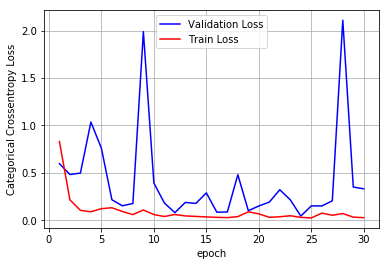

In [141]:
batch_size = 24
from keras.regularizers import L1L2
# Initiliazing the sequential model
from keras import regularizers
from keras.layers import BatchNormalization
model_moving = Sequential()
# Configuring the parameters
model_moving.add(LSTM(64, return_sequences=True, input_shape=(timesteps, input_dim),kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model_moving.add(BatchNormalization())
# Adding a dropout layer
model_moving.add(Dropout(0.5))
model_moving.add(LSTM(48))
# Adding a dropout layer
model_moving.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model_moving.add(Dense(3, activation='softmax'))
model_moving.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model_moving.summary())

# Training the model
history=model_moving.fit(X_moving_train,
          Y_moving_train,
          batch_size=batch_size,
          validation_data=(X_moving_test, Y_moving_test),
          epochs=epochs)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

#print(confusion_matrix(Y_moving_test, model.predict(X_moving_test)))
score = model_moving.evaluate(X_moving_test, Y_moving_test)
print(score)

#### We are getting 95.52% accuracy in classifying dynamic(moving) activities which is quite good 

### LSTM model for Static(Stationary) Activities 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_14 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 48)                21696     
_________________________________________________________________
dropout_15 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 147       
Total params: 41,043
Trainable params: 40,915
Non-trainable params: 128
_________________________________________________________________
None

4067/4067 [==============================] - ETA: 49s - loss: 0.4163 - acc: 0.87 - ETA: 52s - loss: 0.3998 - acc: 0.85 - ETA: 51s - loss: 0.3556 - acc: 0.86 - ETA: 50s - loss: 0.3414 - acc: 0.87 - ETA: 51s - loss: 0.3106 - acc: 0.89 - ETA: 50s - loss: 0.2987 - acc: 0.89 - ETA: 56s - loss: 0.2918 - acc: 0.89 - ETA: 57s - loss: 0.3107 - acc: 0.88 - ETA: 55s - loss: 0.3079 - acc: 0.88 - ETA: 54s - loss: 0.3207 - acc: 0.87 - ETA: 53s - loss: 0.3311 - acc: 0.87 - ETA: 52s - loss: 0.3318 - acc: 0.87 - ETA: 52s - loss: 0.3384 - acc: 0.87 - ETA: 51s - loss: 0.3275 - acc: 0.87 - ETA: 51s - loss: 0.3235 - acc: 0.87 - ETA: 50s - loss: 0.3414 - acc: 0.86 - ETA: 50s - loss: 0.3389 - acc: 0.86 - ETA: 49s - loss: 0.3305 - acc: 0.86 - ETA: 49s - loss: 0.3276 - acc: 0.86 - ETA: 48s - loss: 0.3320 - acc: 0.86 - ETA: 48s - loss: 0.3277 - acc: 0.87 - ETA: 47s - loss: 0.3236 - acc: 0.87 - ETA: 47s - loss: 0.3187 - acc: 0.87 - ETA: 48s - loss: 0.3158 - acc: 0.87 - ETA: 48s - loss: 0.3154 - acc: 0.87 - ETA: 

4067/4067 [==============================] - ETA: 1:10 - loss: 0.3550 - acc: 0.875 - ETA: 1:02 - loss: 0.2417 - acc: 0.916 - ETA: 59s - loss: 0.2388 - acc: 0.930 - ETA: 56s - loss: 0.2336 - acc: 0.92 - ETA: 54s - loss: 0.2337 - acc: 0.91 - ETA: 53s - loss: 0.2194 - acc: 0.92 - ETA: 52s - loss: 0.2292 - acc: 0.91 - ETA: 51s - loss: 0.2208 - acc: 0.92 - ETA: 51s - loss: 0.2155 - acc: 0.92 - ETA: 50s - loss: 0.2279 - acc: 0.92 - ETA: 50s - loss: 0.2309 - acc: 0.91 - ETA: 49s - loss: 0.2281 - acc: 0.92 - ETA: 49s - loss: 0.2565 - acc: 0.91 - ETA: 49s - loss: 0.2583 - acc: 0.90 - ETA: 48s - loss: 0.2575 - acc: 0.91 - ETA: 48s - loss: 0.2445 - acc: 0.91 - ETA: 50s - loss: 0.2535 - acc: 0.91 - ETA: 50s - loss: 0.2594 - acc: 0.90 - ETA: 50s - loss: 0.2608 - acc: 0.91 - ETA: 50s - loss: 0.2626 - acc: 0.90 - ETA: 49s - loss: 0.2597 - acc: 0.90 - ETA: 49s - loss: 0.2632 - acc: 0.90 - ETA: 49s - loss: 0.2680 - acc: 0.90 - ETA: 48s - loss: 0.2638 - acc: 0.90 - ETA: 48s - loss: 0.2719 - acc: 0.90 - 

4067/4067 [==============================] - ETA: 52s - loss: 0.2792 - acc: 0.91 - ETA: 54s - loss: 0.2809 - acc: 0.91 - ETA: 53s - loss: 0.3083 - acc: 0.87 - ETA: 51s - loss: 0.2590 - acc: 0.90 - ETA: 55s - loss: 0.2804 - acc: 0.90 - ETA: 56s - loss: 0.2630 - acc: 0.90 - ETA: 55s - loss: 0.2686 - acc: 0.90 - ETA: 54s - loss: 0.2781 - acc: 0.90 - ETA: 52s - loss: 0.2692 - acc: 0.90 - ETA: 52s - loss: 0.2636 - acc: 0.90 - ETA: 51s - loss: 0.2628 - acc: 0.90 - ETA: 51s - loss: 0.2600 - acc: 0.90 - ETA: 50s - loss: 0.2533 - acc: 0.90 - ETA: 49s - loss: 0.2419 - acc: 0.91 - ETA: 49s - loss: 0.2564 - acc: 0.90 - ETA: 48s - loss: 0.2466 - acc: 0.91 - ETA: 48s - loss: 0.2470 - acc: 0.90 - ETA: 48s - loss: 0.2514 - acc: 0.90 - ETA: 47s - loss: 0.2553 - acc: 0.90 - ETA: 47s - loss: 0.2488 - acc: 0.90 - ETA: 47s - loss: 0.2477 - acc: 0.90 - ETA: 48s - loss: 0.2450 - acc: 0.90 - ETA: 48s - loss: 0.2456 - acc: 0.90 - ETA: 47s - loss: 0.2424 - acc: 0.91 - ETA: 46s - loss: 0.2404 - acc: 0.91 - ETA: 

4067/4067 [==============================] - ETA: 54s - loss: 0.1675 - acc: 0.91 - ETA: 56s - loss: 0.3154 - acc: 0.87 - ETA: 56s - loss: 0.3981 - acc: 0.81 - ETA: 55s - loss: 0.3611 - acc: 0.83 - ETA: 54s - loss: 0.3267 - acc: 0.85 - ETA: 53s - loss: 0.3095 - acc: 0.87 - ETA: 52s - loss: 0.3034 - acc: 0.86 - ETA: 53s - loss: 0.2928 - acc: 0.87 - ETA: 53s - loss: 0.2807 - acc: 0.88 - ETA: 52s - loss: 0.2763 - acc: 0.89 - ETA: 52s - loss: 0.2665 - acc: 0.89 - ETA: 51s - loss: 0.2660 - acc: 0.89 - ETA: 54s - loss: 0.2604 - acc: 0.90 - ETA: 53s - loss: 0.2562 - acc: 0.90 - ETA: 53s - loss: 0.2542 - acc: 0.89 - ETA: 53s - loss: 0.2551 - acc: 0.89 - ETA: 52s - loss: 0.2714 - acc: 0.88 - ETA: 52s - loss: 0.2858 - acc: 0.88 - ETA: 51s - loss: 0.2879 - acc: 0.88 - ETA: 51s - loss: 0.2838 - acc: 0.88 - ETA: 50s - loss: 0.2819 - acc: 0.89 - ETA: 50s - loss: 0.2830 - acc: 0.89 - ETA: 49s - loss: 0.2887 - acc: 0.89 - ETA: 48s - loss: 0.2851 - acc: 0.89 - ETA: 48s - loss: 0.2845 - acc: 0.89 - ETA: 

4067/4067 [==============================] - ETA: 57s - loss: 0.2705 - acc: 0.91 - ETA: 52s - loss: 0.1794 - acc: 0.95 - ETA: 55s - loss: 0.1929 - acc: 0.94 - ETA: 57s - loss: 0.1675 - acc: 0.94 - ETA: 54s - loss: 0.1476 - acc: 0.95 - ETA: 55s - loss: 0.1590 - acc: 0.95 - ETA: 53s - loss: 0.1656 - acc: 0.94 - ETA: 52s - loss: 0.1705 - acc: 0.94 - ETA: 51s - loss: 0.1672 - acc: 0.94 - ETA: 50s - loss: 0.1727 - acc: 0.94 - ETA: 49s - loss: 0.1789 - acc: 0.93 - ETA: 49s - loss: 0.2010 - acc: 0.92 - ETA: 49s - loss: 0.1979 - acc: 0.92 - ETA: 51s - loss: 0.1985 - acc: 0.91 - ETA: 50s - loss: 0.2172 - acc: 0.91 - ETA: 49s - loss: 0.2278 - acc: 0.91 - ETA: 49s - loss: 0.2225 - acc: 0.91 - ETA: 49s - loss: 0.2216 - acc: 0.90 - ETA: 48s - loss: 0.2224 - acc: 0.91 - ETA: 49s - loss: 0.2164 - acc: 0.91 - ETA: 49s - loss: 0.2306 - acc: 0.91 - ETA: 49s - loss: 0.2367 - acc: 0.90 - ETA: 48s - loss: 0.2374 - acc: 0.90 - ETA: 48s - loss: 0.2314 - acc: 0.91 - ETA: 48s - loss: 0.2339 - acc: 0.90 - ETA: 

4067/4067 [==============================] - ETA: 52s - loss: 0.3501 - acc: 0.83 - ETA: 51s - loss: 0.3385 - acc: 0.87 - ETA: 51s - loss: 0.2597 - acc: 0.90 - ETA: 52s - loss: 0.2308 - acc: 0.91 - ETA: 51s - loss: 0.2051 - acc: 0.92 - ETA: 50s - loss: 0.2086 - acc: 0.91 - ETA: 50s - loss: 0.2040 - acc: 0.91 - ETA: 50s - loss: 0.1914 - acc: 0.92 - ETA: 49s - loss: 0.1932 - acc: 0.92 - ETA: 55s - loss: 0.2035 - acc: 0.91 - ETA: 55s - loss: 0.2133 - acc: 0.90 - ETA: 55s - loss: 0.2093 - acc: 0.90 - ETA: 54s - loss: 0.2045 - acc: 0.91 - ETA: 54s - loss: 0.2005 - acc: 0.91 - ETA: 54s - loss: 0.2240 - acc: 0.90 - ETA: 53s - loss: 0.2346 - acc: 0.89 - ETA: 52s - loss: 0.2412 - acc: 0.89 - ETA: 52s - loss: 0.2377 - acc: 0.90 - ETA: 51s - loss: 0.2326 - acc: 0.90 - ETA: 50s - loss: 0.2407 - acc: 0.89 - ETA: 50s - loss: 0.2369 - acc: 0.90 - ETA: 49s - loss: 0.2370 - acc: 0.90 - ETA: 49s - loss: 0.2377 - acc: 0.90 - ETA: 49s - loss: 0.2374 - acc: 0.90 - ETA: 50s - loss: 0.2350 - acc: 0.90 - ETA: 

4067/4067 [==============================] - ETA: 56s - loss: 0.2491 - acc: 0.91 - ETA: 51s - loss: 0.2845 - acc: 0.87 - ETA: 51s - loss: 0.2960 - acc: 0.87 - ETA: 50s - loss: 0.2528 - acc: 0.90 - ETA: 52s - loss: 0.2395 - acc: 0.91 - ETA: 52s - loss: 0.2261 - acc: 0.93 - ETA: 51s - loss: 0.2450 - acc: 0.91 - ETA: 55s - loss: 0.2623 - acc: 0.91 - ETA: 54s - loss: 0.2513 - acc: 0.90 - ETA: 54s - loss: 0.2520 - acc: 0.90 - ETA: 55s - loss: 0.2455 - acc: 0.90 - ETA: 1:01 - loss: 0.2361 - acc: 0.916 - ETA: 1:03 - loss: 0.2303 - acc: 0.919 - ETA: 1:02 - loss: 0.2381 - acc: 0.919 - ETA: 1:01 - loss: 0.2324 - acc: 0.919 - ETA: 1:01 - loss: 0.2380 - acc: 0.916 - ETA: 1:01 - loss: 0.2352 - acc: 0.919 - ETA: 1:00 - loss: 0.2313 - acc: 0.919 - ETA: 1:01 - loss: 0.2383 - acc: 0.914 - ETA: 1:00 - loss: 0.2408 - acc: 0.916 - ETA: 1:00 - loss: 0.2344 - acc: 0.920 - ETA: 59s - loss: 0.2325 - acc: 0.922 - ETA: 58s - loss: 0.2317 - acc: 0.92 - ETA: 57s - loss: 0.2330 - acc: 0.91 - ETA: 58s - loss: 0.233

4067/4067 [==============================] - ETA: 56s - loss: 0.2085 - acc: 0.91 - ETA: 56s - loss: 0.3000 - acc: 0.85 - ETA: 56s - loss: 0.2631 - acc: 0.90 - ETA: 56s - loss: 0.2706 - acc: 0.90 - ETA: 56s - loss: 0.2752 - acc: 0.89 - ETA: 58s - loss: 0.2671 - acc: 0.88 - ETA: 58s - loss: 0.2623 - acc: 0.89 - ETA: 1:05 - loss: 0.2446 - acc: 0.906 - ETA: 1:04 - loss: 0.2598 - acc: 0.898 - ETA: 1:03 - loss: 0.2619 - acc: 0.895 - ETA: 1:01 - loss: 0.2558 - acc: 0.897 - ETA: 1:00 - loss: 0.2628 - acc: 0.885 - ETA: 1:00 - loss: 0.2563 - acc: 0.887 - ETA: 58s - loss: 0.2582 - acc: 0.883 - ETA: 57s - loss: 0.2651 - acc: 0.88 - ETA: 57s - loss: 0.2627 - acc: 0.88 - ETA: 56s - loss: 0.2689 - acc: 0.88 - ETA: 55s - loss: 0.2644 - acc: 0.88 - ETA: 55s - loss: 0.2648 - acc: 0.88 - ETA: 54s - loss: 0.2611 - acc: 0.88 - ETA: 53s - loss: 0.2559 - acc: 0.88 - ETA: 53s - loss: 0.2579 - acc: 0.88 - ETA: 54s - loss: 0.2551 - acc: 0.88 - ETA: 53s - loss: 0.2548 - acc: 0.88 - ETA: 52s - loss: 0.2518 - acc:

4067/4067 [==============================] - ETA: 53s - loss: 0.2357 - acc: 0.83 - ETA: 56s - loss: 0.2235 - acc: 0.87 - ETA: 55s - loss: 0.2250 - acc: 0.87 - ETA: 54s - loss: 0.2345 - acc: 0.87 - ETA: 53s - loss: 0.2099 - acc: 0.89 - ETA: 53s - loss: 0.1977 - acc: 0.90 - ETA: 52s - loss: 0.2078 - acc: 0.89 - ETA: 57s - loss: 0.2051 - acc: 0.89 - ETA: 56s - loss: 0.1961 - acc: 0.90 - ETA: 55s - loss: 0.2112 - acc: 0.90 - ETA: 55s - loss: 0.2153 - acc: 0.89 - ETA: 55s - loss: 0.2272 - acc: 0.88 - ETA: 54s - loss: 0.2292 - acc: 0.89 - ETA: 53s - loss: 0.2275 - acc: 0.89 - ETA: 52s - loss: 0.2310 - acc: 0.88 - ETA: 52s - loss: 0.2378 - acc: 0.88 - ETA: 52s - loss: 0.2430 - acc: 0.88 - ETA: 52s - loss: 0.2389 - acc: 0.88 - ETA: 51s - loss: 0.2320 - acc: 0.89 - ETA: 51s - loss: 0.2434 - acc: 0.88 - ETA: 50s - loss: 0.2409 - acc: 0.88 - ETA: 50s - loss: 0.2499 - acc: 0.88 - ETA: 51s - loss: 0.2524 - acc: 0.88 - ETA: 52s - loss: 0.2531 - acc: 0.88 - ETA: 52s - loss: 0.2496 - acc: 0.88 - ETA: 

4067/4067 [==============================] - ETA: 1:26 - loss: 0.2215 - acc: 0.916 - ETA: 1:07 - loss: 0.3385 - acc: 0.895 - ETA: 1:01 - loss: 0.4134 - acc: 0.875 - ETA: 57s - loss: 0.3800 - acc: 0.885 - ETA: 55s - loss: 0.3309 - acc: 0.90 - ETA: 54s - loss: 0.3143 - acc: 0.90 - ETA: 52s - loss: 0.3110 - acc: 0.89 - ETA: 51s - loss: 0.3212 - acc: 0.88 - ETA: 51s - loss: 0.3103 - acc: 0.88 - ETA: 50s - loss: 0.3002 - acc: 0.88 - ETA: 50s - loss: 0.2821 - acc: 0.89 - ETA: 49s - loss: 0.2840 - acc: 0.89 - ETA: 49s - loss: 0.2854 - acc: 0.90 - ETA: 48s - loss: 0.2898 - acc: 0.89 - ETA: 47s - loss: 0.2824 - acc: 0.90 - ETA: 47s - loss: 0.2742 - acc: 0.90 - ETA: 46s - loss: 0.2698 - acc: 0.90 - ETA: 48s - loss: 0.2776 - acc: 0.90 - ETA: 47s - loss: 0.2701 - acc: 0.90 - ETA: 47s - loss: 0.2669 - acc: 0.90 - ETA: 47s - loss: 0.2739 - acc: 0.89 - ETA: 46s - loss: 0.2739 - acc: 0.89 - ETA: 46s - loss: 0.2828 - acc: 0.89 - ETA: 45s - loss: 0.2744 - acc: 0.89 - ETA: 45s - loss: 0.2720 - acc: 0.89 

4067/4067 [==============================] - ETA: 53s - loss: 0.2069 - acc: 0.95 - ETA: 53s - loss: 0.1844 - acc: 0.93 - ETA: 55s - loss: 0.2857 - acc: 0.88 - ETA: 55s - loss: 0.2486 - acc: 0.91 - ETA: 1:00 - loss: 0.2292 - acc: 0.925 - ETA: 59s - loss: 0.2309 - acc: 0.923 - ETA: 1:00 - loss: 0.2116 - acc: 0.934 - ETA: 1:05 - loss: 0.2194 - acc: 0.927 - ETA: 1:03 - loss: 0.2259 - acc: 0.916 - ETA: 1:02 - loss: 0.2230 - acc: 0.916 - ETA: 1:01 - loss: 0.2129 - acc: 0.924 - ETA: 59s - loss: 0.2134 - acc: 0.927 - ETA: 58s - loss: 0.2156 - acc: 0.92 - ETA: 57s - loss: 0.2060 - acc: 0.92 - ETA: 56s - loss: 0.2035 - acc: 0.93 - ETA: 56s - loss: 0.1961 - acc: 0.93 - ETA: 55s - loss: 0.1964 - acc: 0.93 - ETA: 54s - loss: 0.1940 - acc: 0.93 - ETA: 54s - loss: 0.1893 - acc: 0.93 - ETA: 53s - loss: 0.1910 - acc: 0.93 - ETA: 53s - loss: 0.2046 - acc: 0.93 - ETA: 52s - loss: 0.2078 - acc: 0.92 - ETA: 53s - loss: 0.2077 - acc: 0.92 - ETA: 53s - loss: 0.2076 - acc: 0.92 - ETA: 52s - loss: 0.2191 - acc

4067/4067 [==============================] - ETA: 46s - loss: 0.1322 - acc: 0.95 - ETA: 47s - loss: 0.2084 - acc: 0.87 - ETA: 46s - loss: 0.1668 - acc: 0.91 - ETA: 46s - loss: 0.2272 - acc: 0.87 - ETA: 46s - loss: 0.2515 - acc: 0.87 - ETA: 46s - loss: 0.2584 - acc: 0.86 - ETA: 46s - loss: 0.2577 - acc: 0.87 - ETA: 50s - loss: 0.2612 - acc: 0.87 - ETA: 50s - loss: 0.2494 - acc: 0.88 - ETA: 49s - loss: 0.2447 - acc: 0.89 - ETA: 49s - loss: 0.2361 - acc: 0.89 - ETA: 48s - loss: 0.2415 - acc: 0.89 - ETA: 48s - loss: 0.2431 - acc: 0.89 - ETA: 47s - loss: 0.2343 - acc: 0.90 - ETA: 47s - loss: 0.2386 - acc: 0.89 - ETA: 46s - loss: 0.2415 - acc: 0.89 - ETA: 46s - loss: 0.2529 - acc: 0.89 - ETA: 46s - loss: 0.2499 - acc: 0.89 - ETA: 45s - loss: 0.2499 - acc: 0.89 - ETA: 45s - loss: 0.2606 - acc: 0.88 - ETA: 45s - loss: 0.2587 - acc: 0.88 - ETA: 44s - loss: 0.2546 - acc: 0.89 - ETA: 44s - loss: 0.2555 - acc: 0.89 - ETA: 43s - loss: 0.2541 - acc: 0.89 - ETA: 44s - loss: 0.2502 - acc: 0.89 - ETA: 

4067/4067 [==============================] - ETA: 43s - loss: 0.2772 - acc: 0.87 - ETA: 46s - loss: 0.2350 - acc: 0.91 - ETA: 45s - loss: 0.2358 - acc: 0.91 - ETA: 46s - loss: 0.2219 - acc: 0.91 - ETA: 47s - loss: 0.2413 - acc: 0.89 - ETA: 46s - loss: 0.2263 - acc: 0.89 - ETA: 45s - loss: 0.2328 - acc: 0.89 - ETA: 45s - loss: 0.2254 - acc: 0.90 - ETA: 47s - loss: 0.2336 - acc: 0.90 - ETA: 48s - loss: 0.2231 - acc: 0.90 - ETA: 47s - loss: 0.2262 - acc: 0.90 - ETA: 46s - loss: 0.2230 - acc: 0.90 - ETA: 46s - loss: 0.2318 - acc: 0.90 - ETA: 46s - loss: 0.2337 - acc: 0.90 - ETA: 46s - loss: 0.2294 - acc: 0.90 - ETA: 46s - loss: 0.2317 - acc: 0.90 - ETA: 45s - loss: 0.2249 - acc: 0.91 - ETA: 45s - loss: 0.2202 - acc: 0.91 - ETA: 45s - loss: 0.2238 - acc: 0.91 - ETA: 45s - loss: 0.2158 - acc: 0.91 - ETA: 44s - loss: 0.2122 - acc: 0.91 - ETA: 44s - loss: 0.2130 - acc: 0.91 - ETA: 44s - loss: 0.2088 - acc: 0.91 - ETA: 43s - loss: 0.2141 - acc: 0.91 - ETA: 43s - loss: 0.2178 - acc: 0.91 - ETA: 

4067/4067 [==============================] - ETA: 44s - loss: 0.1693 - acc: 0.95 - ETA: 43s - loss: 0.1957 - acc: 0.95 - ETA: 45s - loss: 0.1774 - acc: 0.97 - ETA: 44s - loss: 0.2235 - acc: 0.94 - ETA: 44s - loss: 0.2069 - acc: 0.95 - ETA: 44s - loss: 0.2114 - acc: 0.93 - ETA: 44s - loss: 0.2048 - acc: 0.93 - ETA: 44s - loss: 0.2080 - acc: 0.93 - ETA: 44s - loss: 0.2013 - acc: 0.93 - ETA: 45s - loss: 0.2007 - acc: 0.92 - ETA: 45s - loss: 0.2138 - acc: 0.91 - ETA: 45s - loss: 0.2079 - acc: 0.92 - ETA: 47s - loss: 0.2039 - acc: 0.92 - ETA: 46s - loss: 0.2092 - acc: 0.91 - ETA: 46s - loss: 0.2177 - acc: 0.91 - ETA: 45s - loss: 0.2215 - acc: 0.91 - ETA: 45s - loss: 0.2164 - acc: 0.91 - ETA: 44s - loss: 0.2161 - acc: 0.91 - ETA: 44s - loss: 0.2259 - acc: 0.91 - ETA: 44s - loss: 0.2254 - acc: 0.91 - ETA: 43s - loss: 0.2255 - acc: 0.91 - ETA: 43s - loss: 0.2256 - acc: 0.91 - ETA: 43s - loss: 0.2356 - acc: 0.90 - ETA: 42s - loss: 0.2398 - acc: 0.90 - ETA: 42s - loss: 0.2402 - acc: 0.90 - ETA: 

4067/4067 [==============================] - ETA: 46s - loss: 0.1443 - acc: 0.91 - ETA: 48s - loss: 0.2143 - acc: 0.87 - ETA: 48s - loss: 0.2487 - acc: 0.84 - ETA: 59s - loss: 0.2373 - acc: 0.86 - ETA: 56s - loss: 0.2133 - acc: 0.89 - ETA: 53s - loss: 0.2029 - acc: 0.90 - ETA: 51s - loss: 0.1999 - acc: 0.91 - ETA: 51s - loss: 0.2009 - acc: 0.91 - ETA: 50s - loss: 0.2033 - acc: 0.91 - ETA: 50s - loss: 0.2016 - acc: 0.91 - ETA: 49s - loss: 0.2056 - acc: 0.91 - ETA: 48s - loss: 0.2082 - acc: 0.90 - ETA: 48s - loss: 0.1998 - acc: 0.91 - ETA: 47s - loss: 0.1962 - acc: 0.91 - ETA: 46s - loss: 0.1954 - acc: 0.91 - ETA: 46s - loss: 0.1959 - acc: 0.91 - ETA: 46s - loss: 0.1928 - acc: 0.91 - ETA: 45s - loss: 0.1966 - acc: 0.91 - ETA: 45s - loss: 0.2008 - acc: 0.91 - ETA: 44s - loss: 0.2001 - acc: 0.91 - ETA: 44s - loss: 0.1992 - acc: 0.91 - ETA: 45s - loss: 0.1979 - acc: 0.91 - ETA: 44s - loss: 0.1958 - acc: 0.92 - ETA: 44s - loss: 0.1967 - acc: 0.92 - ETA: 44s - loss: 0.1970 - acc: 0.92 - ETA: 

4067/4067 [==============================] - ETA: 49s - loss: 0.1899 - acc: 0.95 - ETA: 49s - loss: 0.2684 - acc: 0.89 - ETA: 48s - loss: 0.1988 - acc: 0.93 - ETA: 47s - loss: 0.1743 - acc: 0.93 - ETA: 47s - loss: 0.1694 - acc: 0.93 - ETA: 47s - loss: 0.1900 - acc: 0.92 - ETA: 47s - loss: 0.1871 - acc: 0.92 - ETA: 46s - loss: 0.1864 - acc: 0.92 - ETA: 47s - loss: 0.1941 - acc: 0.92 - ETA: 50s - loss: 0.2008 - acc: 0.92 - ETA: 50s - loss: 0.2184 - acc: 0.91 - ETA: 49s - loss: 0.2129 - acc: 0.91 - ETA: 49s - loss: 0.2061 - acc: 0.91 - ETA: 48s - loss: 0.2075 - acc: 0.91 - ETA: 48s - loss: 0.2123 - acc: 0.91 - ETA: 47s - loss: 0.2075 - acc: 0.91 - ETA: 47s - loss: 0.2054 - acc: 0.91 - ETA: 47s - loss: 0.2067 - acc: 0.91 - ETA: 46s - loss: 0.2113 - acc: 0.91 - ETA: 46s - loss: 0.2158 - acc: 0.90 - ETA: 46s - loss: 0.2120 - acc: 0.91 - ETA: 45s - loss: 0.2104 - acc: 0.91 - ETA: 45s - loss: 0.2074 - acc: 0.91 - ETA: 46s - loss: 0.2046 - acc: 0.91 - ETA: 49s - loss: 0.2051 - acc: 0.91 - ETA: 

4067/4067 [==============================] - ETA: 52s - loss: 0.1889 - acc: 0.91 - ETA: 50s - loss: 0.2555 - acc: 0.87 - ETA: 50s - loss: 0.2245 - acc: 0.90 - ETA: 50s - loss: 0.2147 - acc: 0.91 - ETA: 50s - loss: 0.2144 - acc: 0.91 - ETA: 49s - loss: 0.2375 - acc: 0.89 - ETA: 48s - loss: 0.2290 - acc: 0.90 - ETA: 53s - loss: 0.2151 - acc: 0.90 - ETA: 52s - loss: 0.2193 - acc: 0.90 - ETA: 51s - loss: 0.2187 - acc: 0.91 - ETA: 51s - loss: 0.2285 - acc: 0.90 - ETA: 50s - loss: 0.2206 - acc: 0.90 - ETA: 50s - loss: 0.2160 - acc: 0.91 - ETA: 49s - loss: 0.2066 - acc: 0.91 - ETA: 48s - loss: 0.2045 - acc: 0.91 - ETA: 48s - loss: 0.2025 - acc: 0.91 - ETA: 48s - loss: 0.1958 - acc: 0.92 - ETA: 47s - loss: 0.2024 - acc: 0.91 - ETA: 47s - loss: 0.2131 - acc: 0.91 - ETA: 46s - loss: 0.2127 - acc: 0.91 - ETA: 46s - loss: 0.2200 - acc: 0.90 - ETA: 45s - loss: 0.2162 - acc: 0.90 - ETA: 45s - loss: 0.2124 - acc: 0.90 - ETA: 45s - loss: 0.2129 - acc: 0.90 - ETA: 46s - loss: 0.2231 - acc: 0.90 - ETA: 

4067/4067 [==============================] - ETA: 49s - loss: 0.4100 - acc: 0.83 - ETA: 51s - loss: 0.3097 - acc: 0.87 - ETA: 50s - loss: 0.2376 - acc: 0.91 - ETA: 50s - loss: 0.2111 - acc: 0.91 - ETA: 49s - loss: 0.2096 - acc: 0.92 - ETA: 48s - loss: 0.1959 - acc: 0.93 - ETA: 48s - loss: 0.1967 - acc: 0.93 - ETA: 48s - loss: 0.1906 - acc: 0.93 - ETA: 52s - loss: 0.1900 - acc: 0.93 - ETA: 51s - loss: 0.2063 - acc: 0.92 - ETA: 51s - loss: 0.2137 - acc: 0.92 - ETA: 50s - loss: 0.2097 - acc: 0.92 - ETA: 50s - loss: 0.2151 - acc: 0.91 - ETA: 49s - loss: 0.2190 - acc: 0.91 - ETA: 49s - loss: 0.2151 - acc: 0.91 - ETA: 48s - loss: 0.2535 - acc: 0.90 - ETA: 48s - loss: 0.2523 - acc: 0.90 - ETA: 47s - loss: 0.2514 - acc: 0.90 - ETA: 47s - loss: 0.2535 - acc: 0.90 - ETA: 46s - loss: 0.2440 - acc: 0.90 - ETA: 46s - loss: 0.2438 - acc: 0.90 - ETA: 46s - loss: 0.2357 - acc: 0.91 - ETA: 45s - loss: 0.2283 - acc: 0.91 - ETA: 45s - loss: 0.2335 - acc: 0.91 - ETA: 45s - loss: 0.2308 - acc: 0.91 - ETA: 

4067/4067 [==============================] - ETA: 54s - loss: 0.1284 - acc: 0.95 - ETA: 52s - loss: 0.1366 - acc: 0.95 - ETA: 51s - loss: 0.1717 - acc: 0.94 - ETA: 1:00 - loss: 0.2920 - acc: 0.916 - ETA: 58s - loss: 0.2502 - acc: 0.933 - ETA: 56s - loss: 0.3786 - acc: 0.90 - ETA: 54s - loss: 0.3538 - acc: 0.91 - ETA: 53s - loss: 0.3921 - acc: 0.90 - ETA: 52s - loss: 0.3683 - acc: 0.90 - ETA: 52s - loss: 0.3770 - acc: 0.90 - ETA: 51s - loss: 0.3592 - acc: 0.90 - ETA: 50s - loss: 0.3544 - acc: 0.89 - ETA: 50s - loss: 0.3556 - acc: 0.88 - ETA: 49s - loss: 0.3433 - acc: 0.89 - ETA: 49s - loss: 0.3344 - acc: 0.89 - ETA: 48s - loss: 0.3278 - acc: 0.89 - ETA: 48s - loss: 0.3213 - acc: 0.89 - ETA: 47s - loss: 0.3123 - acc: 0.90 - ETA: 47s - loss: 0.3067 - acc: 0.90 - ETA: 46s - loss: 0.3036 - acc: 0.90 - ETA: 48s - loss: 0.2953 - acc: 0.90 - ETA: 47s - loss: 0.2945 - acc: 0.90 - ETA: 47s - loss: 0.2904 - acc: 0.90 - ETA: 46s - loss: 0.2877 - acc: 0.90 - ETA: 46s - loss: 0.2867 - acc: 0.90 - ET

4067/4067 [==============================] - ETA: 53s - loss: 0.1377 - acc: 0.91 - ETA: 49s - loss: 0.1176 - acc: 0.93 - ETA: 49s - loss: 0.1062 - acc: 0.95 - ETA: 49s - loss: 0.1291 - acc: 0.94 - ETA: 49s - loss: 0.1218 - acc: 0.95 - ETA: 49s - loss: 0.1263 - acc: 0.94 - ETA: 49s - loss: 0.1250 - acc: 0.94 - ETA: 50s - loss: 0.1318 - acc: 0.94 - ETA: 49s - loss: 0.1589 - acc: 0.93 - ETA: 49s - loss: 0.1785 - acc: 0.91 - ETA: 48s - loss: 0.1795 - acc: 0.92 - ETA: 48s - loss: 0.1736 - acc: 0.92 - ETA: 48s - loss: 0.1787 - acc: 0.92 - ETA: 48s - loss: 0.1720 - acc: 0.92 - ETA: 50s - loss: 0.1708 - acc: 0.92 - ETA: 49s - loss: 0.1806 - acc: 0.92 - ETA: 49s - loss: 0.1791 - acc: 0.92 - ETA: 48s - loss: 0.1884 - acc: 0.92 - ETA: 47s - loss: 0.1864 - acc: 0.92 - ETA: 47s - loss: 0.1904 - acc: 0.91 - ETA: 46s - loss: 0.1948 - acc: 0.91 - ETA: 46s - loss: 0.1928 - acc: 0.91 - ETA: 45s - loss: 0.1957 - acc: 0.91 - ETA: 45s - loss: 0.2085 - acc: 0.91 - ETA: 44s - loss: 0.2036 - acc: 0.91 - ETA: 

4067/4067 [==============================] - ETA: 47s - loss: 0.2824 - acc: 0.87 - ETA: 46s - loss: 0.3545 - acc: 0.79 - ETA: 46s - loss: 0.3144 - acc: 0.83 - ETA: 45s - loss: 0.3055 - acc: 0.84 - ETA: 45s - loss: 0.2825 - acc: 0.86 - ETA: 45s - loss: 0.2886 - acc: 0.86 - ETA: 45s - loss: 0.2946 - acc: 0.86 - ETA: 45s - loss: 0.2779 - acc: 0.86 - ETA: 44s - loss: 0.2684 - acc: 0.87 - ETA: 47s - loss: 0.2705 - acc: 0.87 - ETA: 47s - loss: 0.2667 - acc: 0.87 - ETA: 47s - loss: 0.2549 - acc: 0.88 - ETA: 46s - loss: 0.2732 - acc: 0.88 - ETA: 46s - loss: 0.2695 - acc: 0.88 - ETA: 45s - loss: 0.2609 - acc: 0.89 - ETA: 45s - loss: 0.2522 - acc: 0.89 - ETA: 44s - loss: 0.2572 - acc: 0.89 - ETA: 44s - loss: 0.2493 - acc: 0.90 - ETA: 44s - loss: 0.2476 - acc: 0.90 - ETA: 43s - loss: 0.2410 - acc: 0.90 - ETA: 43s - loss: 0.2380 - acc: 0.91 - ETA: 42s - loss: 0.2348 - acc: 0.91 - ETA: 42s - loss: 0.2427 - acc: 0.90 - ETA: 42s - loss: 0.2359 - acc: 0.91 - ETA: 41s - loss: 0.2321 - acc: 0.91 - ETA: 

4067/4067 [==============================] - ETA: 50s - loss: 0.1401 - acc: 0.91 - ETA: 58s - loss: 0.1380 - acc: 0.93 - ETA: 56s - loss: 0.1638 - acc: 0.93 - ETA: 56s - loss: 0.1949 - acc: 0.91 - ETA: 54s - loss: 0.2208 - acc: 0.90 - ETA: 54s - loss: 0.2166 - acc: 0.90 - ETA: 53s - loss: 0.2448 - acc: 0.89 - ETA: 53s - loss: 0.2351 - acc: 0.90 - ETA: 52s - loss: 0.2235 - acc: 0.91 - ETA: 51s - loss: 0.2192 - acc: 0.91 - ETA: 51s - loss: 0.2229 - acc: 0.92 - ETA: 50s - loss: 0.2127 - acc: 0.92 - ETA: 50s - loss: 0.2079 - acc: 0.92 - ETA: 50s - loss: 0.2029 - acc: 0.93 - ETA: 52s - loss: 0.2048 - acc: 0.92 - ETA: 52s - loss: 0.2060 - acc: 0.92 - ETA: 51s - loss: 0.2049 - acc: 0.91 - ETA: 50s - loss: 0.2032 - acc: 0.91 - ETA: 50s - loss: 0.1962 - acc: 0.92 - ETA: 50s - loss: 0.1907 - acc: 0.92 - ETA: 49s - loss: 0.1911 - acc: 0.92 - ETA: 49s - loss: 0.2032 - acc: 0.92 - ETA: 49s - loss: 0.2034 - acc: 0.92 - ETA: 48s - loss: 0.2077 - acc: 0.92 - ETA: 48s - loss: 0.2066 - acc: 0.92 - ETA: 

4067/4067 [==============================] - ETA: 1:15 - loss: 0.2371 - acc: 0.916 - ETA: 1:12 - loss: 0.2088 - acc: 0.895 - ETA: 1:05 - loss: 0.1663 - acc: 0.930 - ETA: 1:04 - loss: 0.1952 - acc: 0.906 - ETA: 1:00 - loss: 0.1924 - acc: 0.908 - ETA: 59s - loss: 0.1816 - acc: 0.916 - ETA: 57s - loss: 0.1802 - acc: 0.92 - ETA: 55s - loss: 0.1857 - acc: 0.92 - ETA: 55s - loss: 0.1808 - acc: 0.93 - ETA: 56s - loss: 0.1821 - acc: 0.92 - ETA: 55s - loss: 0.1798 - acc: 0.93 - ETA: 54s - loss: 0.1886 - acc: 0.92 - ETA: 53s - loss: 0.1958 - acc: 0.92 - ETA: 52s - loss: 0.2045 - acc: 0.91 - ETA: 51s - loss: 0.2108 - acc: 0.91 - ETA: 50s - loss: 0.2157 - acc: 0.91 - ETA: 49s - loss: 0.2126 - acc: 0.91 - ETA: 48s - loss: 0.2074 - acc: 0.92 - ETA: 48s - loss: 0.2086 - acc: 0.92 - ETA: 47s - loss: 0.2103 - acc: 0.91 - ETA: 47s - loss: 0.2158 - acc: 0.91 - ETA: 46s - loss: 0.2125 - acc: 0.91 - ETA: 46s - loss: 0.2116 - acc: 0.91 - ETA: 45s - loss: 0.2124 - acc: 0.91 - ETA: 44s - loss: 0.2100 - acc: 0

4067/4067 [==============================] - ETA: 53s - loss: 0.1608 - acc: 0.95 - ETA: 55s - loss: 0.1786 - acc: 0.93 - ETA: 56s - loss: 0.1624 - acc: 0.94 - ETA: 56s - loss: 0.1940 - acc: 0.91 - ETA: 56s - loss: 0.1965 - acc: 0.90 - ETA: 55s - loss: 0.2130 - acc: 0.89 - ETA: 55s - loss: 0.2135 - acc: 0.89 - ETA: 55s - loss: 0.2030 - acc: 0.90 - ETA: 54s - loss: 0.1976 - acc: 0.90 - ETA: 55s - loss: 0.2096 - acc: 0.90 - ETA: 56s - loss: 0.2080 - acc: 0.90 - ETA: 57s - loss: 0.2060 - acc: 0.91 - ETA: 56s - loss: 0.2191 - acc: 0.91 - ETA: 55s - loss: 0.2174 - acc: 0.91 - ETA: 54s - loss: 0.2093 - acc: 0.92 - ETA: 54s - loss: 0.2010 - acc: 0.92 - ETA: 53s - loss: 0.2025 - acc: 0.92 - ETA: 52s - loss: 0.1974 - acc: 0.93 - ETA: 52s - loss: 0.2055 - acc: 0.92 - ETA: 51s - loss: 0.1995 - acc: 0.92 - ETA: 51s - loss: 0.1945 - acc: 0.93 - ETA: 50s - loss: 0.2017 - acc: 0.92 - ETA: 50s - loss: 0.2022 - acc: 0.92 - ETA: 49s - loss: 0.2008 - acc: 0.92 - ETA: 49s - loss: 0.2066 - acc: 0.92 - ETA: 

4067/4067 [==============================] - ETA: 1:00 - loss: 0.3222 - acc: 0.875 - ETA: 56s - loss: 0.2397 - acc: 0.895 - ETA: 55s - loss: 0.2107 - acc: 0.91 - ETA: 57s - loss: 0.2249 - acc: 0.91 - ETA: 58s - loss: 0.2778 - acc: 0.89 - ETA: 57s - loss: 0.2797 - acc: 0.90 - ETA: 55s - loss: 0.2621 - acc: 0.91 - ETA: 54s - loss: 0.2517 - acc: 0.91 - ETA: 53s - loss: 0.2513 - acc: 0.91 - ETA: 56s - loss: 0.2484 - acc: 0.91 - ETA: 58s - loss: 0.2501 - acc: 0.91 - ETA: 57s - loss: 0.2605 - acc: 0.90 - ETA: 56s - loss: 0.2600 - acc: 0.90 - ETA: 56s - loss: 0.2641 - acc: 0.90 - ETA: 55s - loss: 0.2634 - acc: 0.90 - ETA: 56s - loss: 0.2542 - acc: 0.90 - ETA: 56s - loss: 0.2589 - acc: 0.90 - ETA: 56s - loss: 0.2520 - acc: 0.90 - ETA: 55s - loss: 0.2459 - acc: 0.91 - ETA: 54s - loss: 0.2527 - acc: 0.90 - ETA: 54s - loss: 0.2465 - acc: 0.90 - ETA: 53s - loss: 0.2429 - acc: 0.91 - ETA: 52s - loss: 0.2394 - acc: 0.91 - ETA: 52s - loss: 0.2341 - acc: 0.91 - ETA: 53s - loss: 0.2308 - acc: 0.92 - ET

4067/4067 [==============================] - ETA: 50s - loss: 0.1636 - acc: 0.91 - ETA: 51s - loss: 0.1253 - acc: 0.93 - ETA: 51s - loss: 0.1234 - acc: 0.94 - ETA: 1:00 - loss: 0.1271 - acc: 0.958 - ETA: 58s - loss: 0.1438 - acc: 0.950 - ETA: 56s - loss: 0.1469 - acc: 0.94 - ETA: 55s - loss: 0.1519 - acc: 0.94 - ETA: 54s - loss: 0.1476 - acc: 0.94 - ETA: 54s - loss: 0.1534 - acc: 0.94 - ETA: 53s - loss: 0.1734 - acc: 0.93 - ETA: 54s - loss: 0.1863 - acc: 0.92 - ETA: 54s - loss: 0.1967 - acc: 0.92 - ETA: 53s - loss: 0.1957 - acc: 0.92 - ETA: 54s - loss: 0.1905 - acc: 0.93 - ETA: 54s - loss: 0.1912 - acc: 0.93 - ETA: 53s - loss: 0.1959 - acc: 0.92 - ETA: 53s - loss: 0.1878 - acc: 0.93 - ETA: 52s - loss: 0.1864 - acc: 0.93 - ETA: 54s - loss: 0.1852 - acc: 0.93 - ETA: 53s - loss: 0.1845 - acc: 0.93 - ETA: 52s - loss: 0.1842 - acc: 0.93 - ETA: 52s - loss: 0.1851 - acc: 0.93 - ETA: 51s - loss: 0.1826 - acc: 0.93 - ETA: 51s - loss: 0.1804 - acc: 0.93 - ETA: 50s - loss: 0.1802 - acc: 0.93 - ET

4067/4067 [==============================] - ETA: 48s - loss: 0.1331 - acc: 1.00 - ETA: 46s - loss: 0.2214 - acc: 0.95 - ETA: 46s - loss: 0.2310 - acc: 0.93 - ETA: 46s - loss: 0.2280 - acc: 0.92 - ETA: 46s - loss: 0.2092 - acc: 0.92 - ETA: 46s - loss: 0.2076 - acc: 0.92 - ETA: 45s - loss: 0.1965 - acc: 0.92 - ETA: 45s - loss: 0.1982 - acc: 0.92 - ETA: 49s - loss: 0.1924 - acc: 0.92 - ETA: 48s - loss: 0.1840 - acc: 0.93 - ETA: 48s - loss: 0.1876 - acc: 0.92 - ETA: 47s - loss: 0.1824 - acc: 0.92 - ETA: 47s - loss: 0.1842 - acc: 0.92 - ETA: 46s - loss: 0.1862 - acc: 0.92 - ETA: 46s - loss: 0.1797 - acc: 0.92 - ETA: 46s - loss: 0.1796 - acc: 0.92 - ETA: 45s - loss: 0.1746 - acc: 0.93 - ETA: 45s - loss: 0.1859 - acc: 0.92 - ETA: 44s - loss: 0.1842 - acc: 0.92 - ETA: 44s - loss: 0.1843 - acc: 0.92 - ETA: 43s - loss: 0.1821 - acc: 0.93 - ETA: 43s - loss: 0.1809 - acc: 0.92 - ETA: 43s - loss: 0.1798 - acc: 0.93 - ETA: 42s - loss: 0.1816 - acc: 0.93 - ETA: 42s - loss: 0.1875 - acc: 0.93 - ETA: 

4067/4067 [==============================] - ETA: 47s - loss: 0.2632 - acc: 0.87 - ETA: 47s - loss: 0.3117 - acc: 0.83 - ETA: 46s - loss: 0.2525 - acc: 0.87 - ETA: 46s - loss: 0.2540 - acc: 0.88 - ETA: 46s - loss: 0.2375 - acc: 0.89 - ETA: 46s - loss: 0.2299 - acc: 0.89 - ETA: 46s - loss: 0.2306 - acc: 0.89 - ETA: 46s - loss: 0.2209 - acc: 0.90 - ETA: 46s - loss: 0.2491 - acc: 0.89 - ETA: 46s - loss: 0.2561 - acc: 0.89 - ETA: 45s - loss: 0.2489 - acc: 0.89 - ETA: 45s - loss: 0.2510 - acc: 0.89 - ETA: 44s - loss: 0.2687 - acc: 0.89 - ETA: 44s - loss: 0.2599 - acc: 0.89 - ETA: 44s - loss: 0.2655 - acc: 0.89 - ETA: 43s - loss: 0.2722 - acc: 0.89 - ETA: 45s - loss: 0.2686 - acc: 0.89 - ETA: 45s - loss: 0.2602 - acc: 0.89 - ETA: 44s - loss: 0.2571 - acc: 0.90 - ETA: 44s - loss: 0.2592 - acc: 0.90 - ETA: 44s - loss: 0.2504 - acc: 0.90 - ETA: 43s - loss: 0.2440 - acc: 0.90 - ETA: 43s - loss: 0.2383 - acc: 0.91 - ETA: 43s - loss: 0.2356 - acc: 0.91 - ETA: 42s - loss: 0.2383 - acc: 0.91 - ETA: 

1560/1560 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 2ms/step
[0.30354809232820301, 0.87820512820512819]


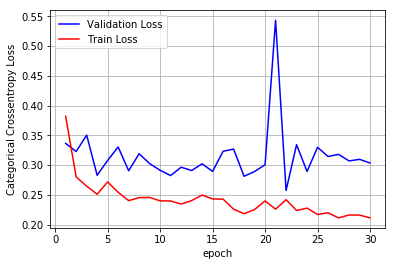

In [142]:
batch_size = 24
from keras.regularizers import L1L2
# Initiliazing the sequential model
from keras import regularizers
from keras.layers import BatchNormalization
model_stationary = Sequential()
# Configuring the parameters
model_stationary.add(LSTM(64, return_sequences=True, input_shape=(timesteps, input_dim),kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model_stationary.add(BatchNormalization())
# Adding a dropout layer
model_stationary.add(Dropout(0.5))
model_stationary.add(LSTM(48))
# Adding a dropout layer
model_stationary.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model_stationary.add(Dense(3, activation='softmax'))
model_stationary.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model_stationary.summary())

# Training the model
history=model_stationary.fit(X_stationary_train,
          Y_stationary_train,
          batch_size=batch_size,
          validation_data=(X_stationary_test, Y_stationary_test),
          epochs=epochs)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

#print(confusion_matrix(Y_stationary_test, model.predict(X_stationary_test)))
score = model_stationary.evaluate(X_stationary_test, Y_stationary_test)
print(score)

In [ ]:
#### We are getting 87.82% accuracy in classifying static(stationary) activities which is low from dynamic(moving) activities

In [143]:
Y_test.shape

(2947, 6)

In [144]:
X_test.shape

(2947, 128, 9)

In [145]:
Y_test[920]

array([0, 0, 0, 0, 1, 0], dtype=uint8)

In [146]:
X_test[920].shape

(128, 9)

In [147]:
np.expand_dims(X_test[120],axis=0).shape

(1, 128, 9)

In [148]:
np.argmax(model_stationary.predict(np.expand_dims(X_test[920],axis=0)))

1

In [149]:
Y_test[2666]

array([0, 0, 0, 0, 0, 1], dtype=uint8)

In [150]:
np.argmax(model_stationary.predict(np.expand_dims(X_test[2666],axis=0)))

2

In [151]:
np.argmax(model_first.predict(np.expand_dims(X_test[920],axis=0)))

1

## Predicting Activity by using divide and conquer approach

In [152]:
pred=[]
for i in tqdm(range(2947)):
    if (np.argmax(model_first.predict(np.expand_dims(X_test[i],axis=0)))==0):
        y=np.argmax(model_moving.predict(np.expand_dims(X_test[i],axis=0)))
        if y==0:
            pred.append([1,0,0,0,0,0])
        elif y==1:
            pred.append([0,1,0,0,0,0])
        elif y==2:
            pred.append([0,0,1,0,0,0])
    else:
        y=np.argmax(model_stationary.predict(np.expand_dims(X_test[i],axis=0)))
        if y==0:
            pred.append([0,0,0,1,0,0])
        elif y==1:
            pred.append([0,0,0,0,1,0])
        elif y==2:
            pred.append([0,0,0,0,0,1])
        
    

100%|██████████████████████████████████████████████████████████████████████████████| 2947/2947 [07:13<00:00,  7.01it/s]


In [153]:
pred=np.array(pred)

In [154]:
pred.shape

(2947, 6)

In [155]:
Y_test.shape

(2947, 6)

In [156]:
from sklearn.metrics import accuracy_score

In [157]:
accuracy_score(Y_test,pred)

0.9138106549032915

In [160]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = [ "Architecture","Test Accuracy"]

In [161]:
x.add_row(['Architecture1','90.43%'])
x.add_row(['Architecture2','81.60%'])
x.add_row(['Architecture3','90.09%'])
x.add_row(['Architecture4','90.90%'])
x.add_row(['Architecture5','89.41%'])
x.add_row(['Architecture6','89.68%'])
x.add_row(['Architecture7','88.97%'])
x.add_row(['Architecture8','90.66%'])
x.add_row(['Divide Conquer Approach','91.38%'])

In [162]:
print(x)

+-------------------------+---------------+
|       Architecture      | Test Accuracy |
+-------------------------+---------------+
|      Architecture1      |     90.43%    |
|      Architecture2      |     81.60%    |
|      Architecture3      |     90.09%    |
|      Architecture4      |     90.90%    |
|      Architecture5      |     89.41%    |
|      Architecture6      |     89.68%    |
|      Architecture7      |     88.97%    |
|      Architecture8      |     90.66%    |
| Divide Conquer Approach |     91.38%    |
+-------------------------+---------------+


# Conclusion

* We used 8 different architecture to get best accuracy and the best we got is 90.90% 
* we used different different dropouts,batch normalizations in architectures 
* then we used the divide and conquer approach in which we divided the the problem in 2 subproblem
* First we grouped 6 classes into two such as dynamic and static so we build one model just to predict whether this process is dynamic or static
* after that we build 2 seperate models for 3 classes of dynamic and static
* so when test data comes it first passes thorugh the first model which predicts whether the model is static or dynamic after that if its static activity we pass that point throught static model otherwise it passes through dynamic model
* we got approx 96% accuracy on dynamic activites prediction which is quite good 
* we can improve the model performance if we use cnn in divide and conquer approach 